<a href="https://colab.research.google.com/github/nancymatijas/OSiRV-Projekt/blob/main/task_brats2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import os
import sys
import time
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
from skimage.transform import resize
import shutil
import nibabel as nib
from IPython.display import clear_output
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

import random

In [64]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **NESTO**

In [65]:
imgs_dir='/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData_comb/'
all_dirs = glob (f'{imgs_dir}/*')
len (all_dirs)
all_dirs.sort()

In [66]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def shuffle_split(all_dirs, val_pct=0.1, test_pct=0.1, seed=42):
    seed_everything(seed)
    n_test = int(len(all_dirs) * test_pct)
    n_val = int(len(all_dirs) * val_pct)
    idx = np.random.permutation(len(all_dirs))
    all_dirs = np.array(all_dirs)[idx]
    test_dirs = all_dirs[:n_test]
    valid_dirs = all_dirs[n_test:n_test + n_val]
    train_dirs = all_dirs[n_test + n_val:]
    return train_dirs, valid_dirs, test_dirs

In [67]:
train_dirs, valid_dirs, test_dirs = shuffle_split(all_dirs)
print(len(train_dirs), len(valid_dirs), len(test_dirs))

297 36 36


In [68]:
class BratsDataset (Dataset):
    def __init__ (self, img_dirs, modality_types, transform = None):
        self.img_dirs = img_dirs
        self.transform = transform
        self.modality_types = modality_types

    def __len__ (self):
        return len (self.img_dirs)

    def __getitem__(self, index):
        imgs_path = self.img_dirs[index]
        patient_id = os.path.basename(imgs_path)
        image = self.concat_imgs(imgs_path)

        mask = np.array(Image.open(f'{imgs_path}/{patient_id}_SEG_combined.jpg'))
        mask = (mask / 255 * 4).round()
        mask = self.preprocess_mask_labels(mask)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

         # Select only the first channel from the mask
        mask = mask[..., 0]
        return image.astype(float), mask.astype(float)

    ## Spajanje slika s id-om pacijenta
    def concat_imgs(self, path: str):
      patient_id = os.path.basename(path)
      types = []
      for modality_type in modality_types:
          img = np.array(Image.open(f'{path}/{patient_id}_{modality_type}_combined.jpg'))
          img = self.normalize(img)
          types.append(img)
      #return np.array(types)
      return np.array(types)[..., 0]

    ## Ova metoda pretvara izvornu masku segmentacije u one-hot kodiranu masku s četiri kanala koji predstavljaju različite regije tumora
    ## Cijeli tumor - WT, Tumorska jezgra - TC, Povećanje tumora - ET, Pozadina - BG
    def preprocess_mask_labels(self, mask: np.ndarray):
        mask_WT = np.zeros(mask.shape)
        mask_WT[mask == 2] = 1

        mask_TC = np.zeros(mask.shape)
        mask_TC[mask == 1] = 1

        mask_ET = np.zeros(mask.shape)
        mask_ET[mask == 3] = 1

        mask_BG = np.zeros(mask.shape)
        mask_BG[mask == 0] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET, mask_BG])
        return mask

    ## Normalizacija ulaznih podataka
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        if np.max(data) == 0:
            return data
        if (np.max(data) - data_min) == 0:
            return data / data_min
        return (data - data_min) / (np.max(data) - data_min)

modality_types = ['FLAIR', 'T1', 'T1CE', 'T2']

In [69]:
batch_size = 8

#Datasets
train_ds = BratsDataset(train_dirs, modality_types)
valid_ds = BratsDataset(valid_dirs, modality_types)
test_ds = BratsDataset(test_dirs, modality_types)

#DataLoaders
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = True)

print(len(train_dl),len(valid_dl), len(test_dl))

38 5 5


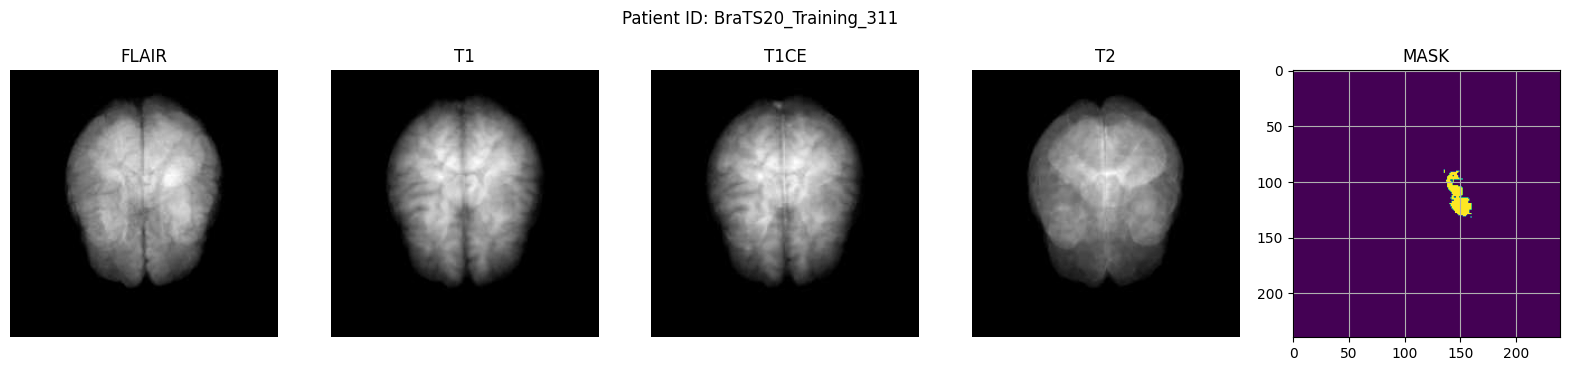

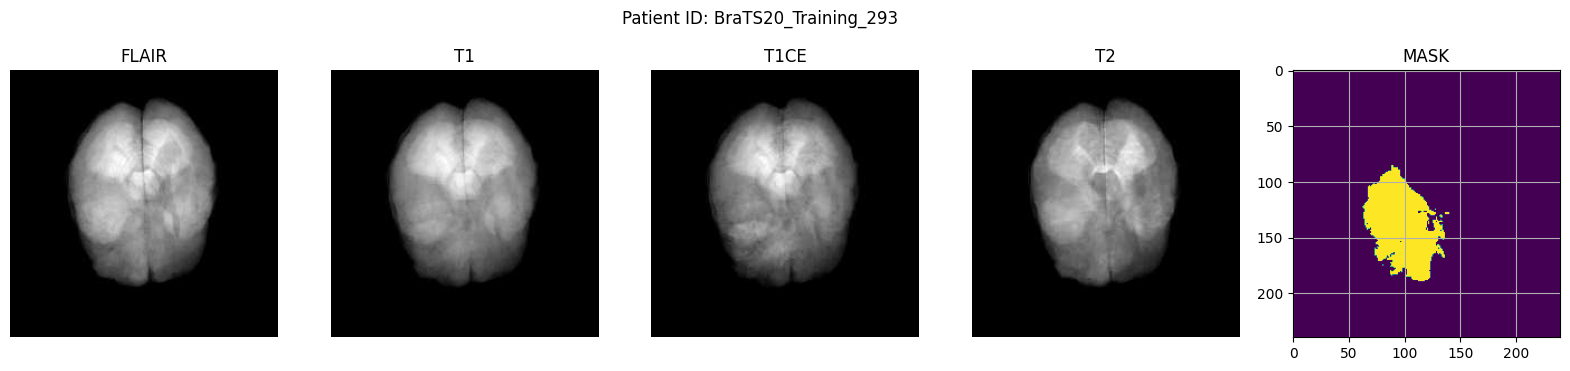

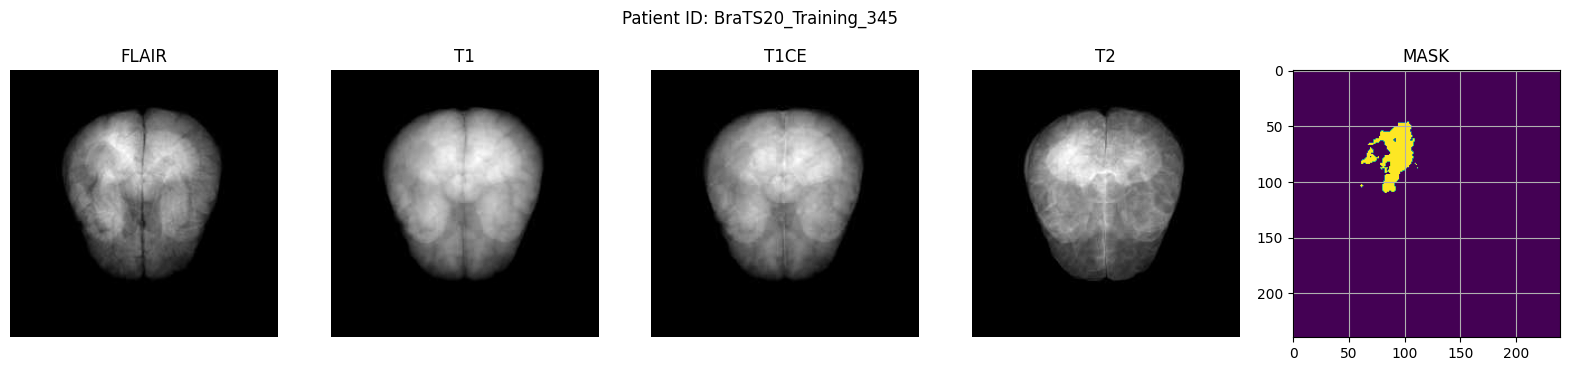

In [70]:
def visualize_samples(dataset, modality_types, num_samples):
    for i in range(num_samples):
        image, mask = dataset[i]

        # Extract patient ID
        patient_id = os.path.basename(dataset.img_dirs[i])

        # Create a single figure with one row and (len(modality_types) + 1) columns
        plt.figure(figsize=(20, 4))

        # Visualize all MRI modalities in the first len(modality_types) columns
        for j in range(len(modality_types)):
            plt.subplot(1, len(modality_types) + 1, j + 1)
            plt.imshow(image[j], cmap='gray')
            plt.axis('off')
            plt.title(f"{modality_types[j]}")

        # Visualize mask in the last column
        plt.subplot(1, len(modality_types) + 1, len(modality_types) + 1)
        plt.imshow(mask[1], cmap='viridis')
        plt.grid()
        plt.title("MASK")

        plt.suptitle(f"Patient ID: {patient_id}")
        plt.show()

# Prikazivanje uzoraka u istom redu
visualize_samples(train_ds, modality_types, num_samples=3)

In [71]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.down5 = Down(1024,2048)

        self.up0 = Up(2048,1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)

        x = self.up0(x6,x5)
        x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [72]:
## Računa Dice koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti (probabilities) i stvarnih oznaka (truth)
## Dice koeficijent mjeri sličnost između predviđenih i stvarnih područja
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

## Računa Jaccard koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti i stvarnih oznaka
## Jaccard koeficijent mjeri sličnost između predviđenih i stvarnih područja
def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

In [73]:
## Klasa koja služi za praćenje i ažuriranje Dice i Jaccard koeficijenata tijekom evaluacije modela
class Meter:
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)

        self.dice_scores.append(dice)
        self.iou_scores.append(iou)

    def get_metrics(self) -> np.ndarray:
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou

In [74]:
def bce_dice_loss(input, target, alpha, beta, smooth=1):
    # BCE loss
    bce_loss = F.binary_cross_entropy_with_logits(input, target)

    # Dice loss
    input = torch.sigmoid(input)
    input_flat = input.view(-1)
    target_flat = target.view(-1)
    intersection = (input_flat * target_flat).sum()
    dice_loss = 1 - (2 * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth)

    # Combined loss
    loss = alpha * bce_loss + beta * dice_loss

    return loss

In [75]:
class Trainer:
    def __init__(self,
                 net: nn.Module,
                 train_dl: DataLoader,
                 val_dl: DataLoader,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 num_epochs: int,
                 display_plot: bool = True,

                ):

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr, betas=(0.9,0.999))
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs
        self.dataloaders = {
            "train": train_dl,
            "val"  : val_dl
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self, images: torch.Tensor, targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images.float())
        loss = bce_dice_loss(logits, targets, alpha=0.5, beta=0.5)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()

        for itr, (images, targets) in enumerate(tqdm(dataloader, desc=f"{phase} epoch {epoch + 1}/{self.num_epochs}")):
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(), targets.detach().cpu())

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        print(f"Loss: {epoch_loss:.4f} | Dice: {epoch_dice:.4f} | IoU: {epoch_iou:.4f}")
        return epoch_loss

    ## Pokretanje treniranja kroz sve epohe
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()
        self._save_train_history()

    ## Prikaz grafa gubitaka, Dice i Jaccard koeficijenata tijekom treninga i validacije
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['pink', 'violet']
        labels = [
            f"Train Loss: {self.losses['train'][-1]:.4f} \nValidation Loss: {self.losses['val'][-1]:.4f}",
            f"Train Dice: {self.dice_scores['train'][-1]:.4f} \nValidation Dice: {self.dice_scores['val'][-1]:.4f}",
            f"Train Jaccard: {self.jaccard_scores['train'][-1]:.4f} \nValidation Jaccard: {self.jaccard_scores['val'][-1]:.4f}"
        ]

        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))

            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="Validation")
                ax.plot(data[i]['train'], c=colors[1], label="Training")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

    ## Spremanje težine modela i rezultate treniranja
    def _save_train_history(self):
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i]
                     for i in list(range(len(logs_)))
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)

In [76]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=4, n_classes=4).to(device)

In [77]:
trainer = Trainer(net = model,
                  train_dl = train_dl,
                  val_dl = valid_dl,
                  lr = 1e-5,
                  accumulation_steps = batch_size,
                  batch_size = batch_size,
                  num_epochs = 70,
                 )

device: cuda


train epoch 1/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.6327 | Dice: 0.3513 | IoU: 0.2175


val epoch 1/70: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


Loss: 0.6320 | Dice: 0.6346 | IoU: 0.4650


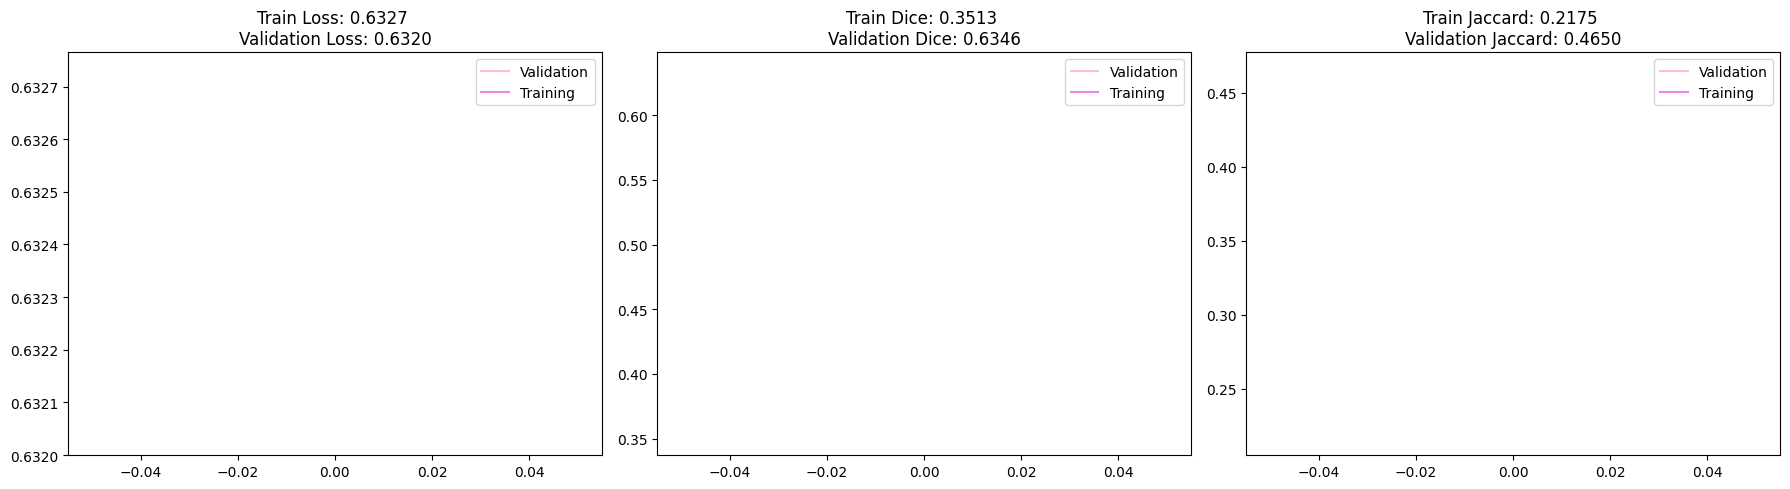

train epoch 2/70: 100%|██████████| 38/38 [00:30<00:00,  1.23it/s]


Loss: 0.6036 | Dice: 0.7437 | IoU: 0.6044


val epoch 2/70: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Loss: 0.5849 | Dice: 0.8950 | IoU: 0.8107


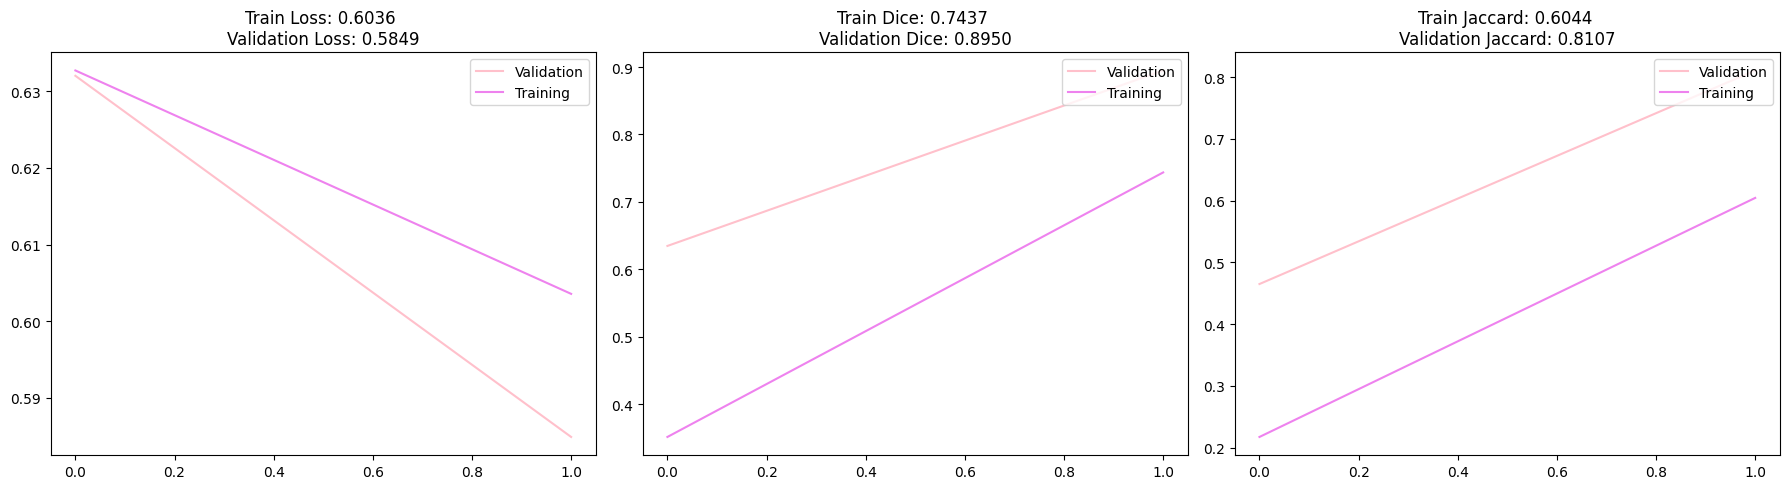

train epoch 3/70: 100%|██████████| 38/38 [00:31<00:00,  1.22it/s]


Loss: 0.5815 | Dice: 0.8918 | IoU: 0.8067


val epoch 3/70: 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Loss: 0.5686 | Dice: 0.9255 | IoU: 0.8622


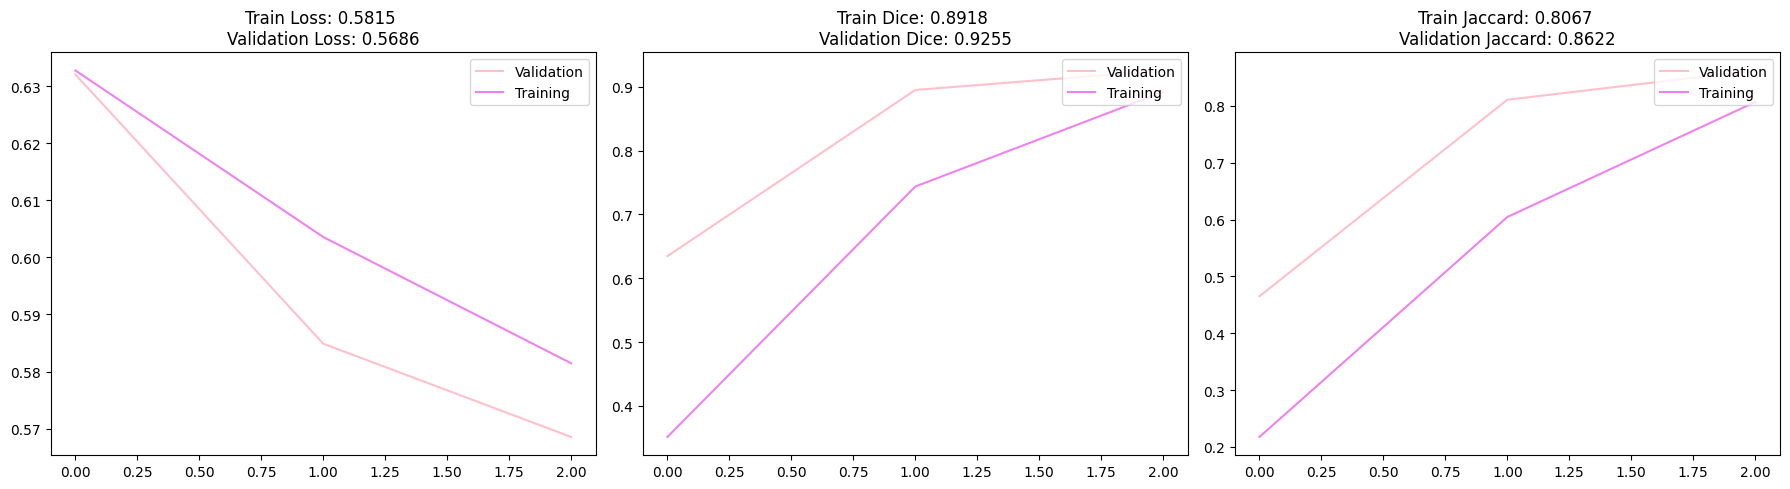

train epoch 4/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.5647 | Dice: 0.9328 | IoU: 0.8747


val epoch 4/70: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Loss: 0.5594 | Dice: 0.9401 | IoU: 0.8877


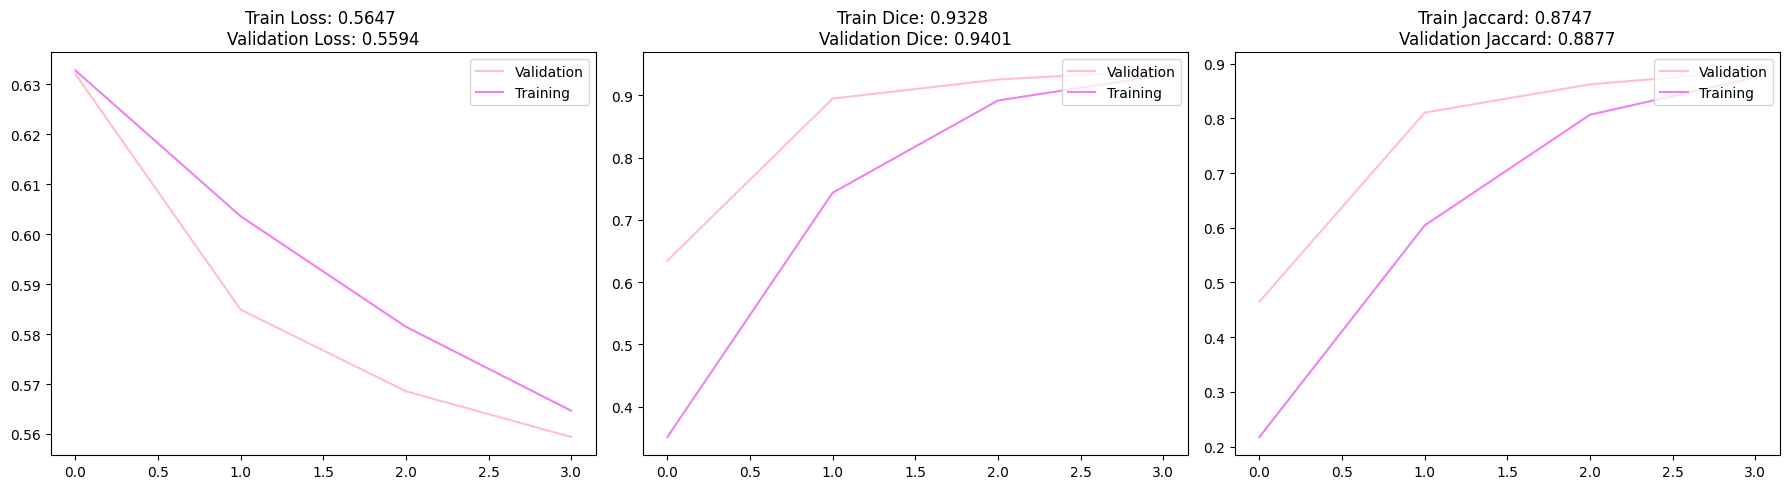

train epoch 5/70: 100%|██████████| 38/38 [00:30<00:00,  1.23it/s]


Loss: 0.5524 | Dice: 0.9541 | IoU: 0.9125


val epoch 5/70: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Loss: 0.5445 | Dice: 0.9645 | IoU: 0.9317


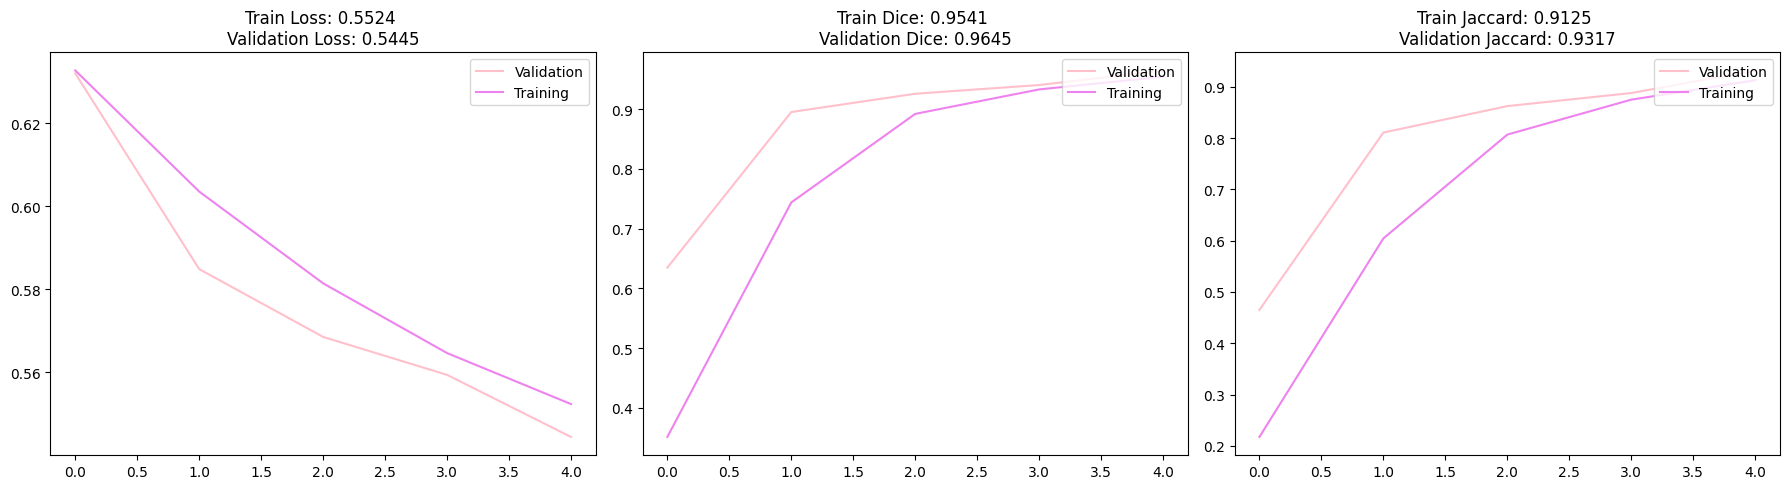

train epoch 6/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.5432 | Dice: 0.9653 | IoU: 0.9332


val epoch 6/70: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


Loss: 0.5389 | Dice: 0.9685 | IoU: 0.9392


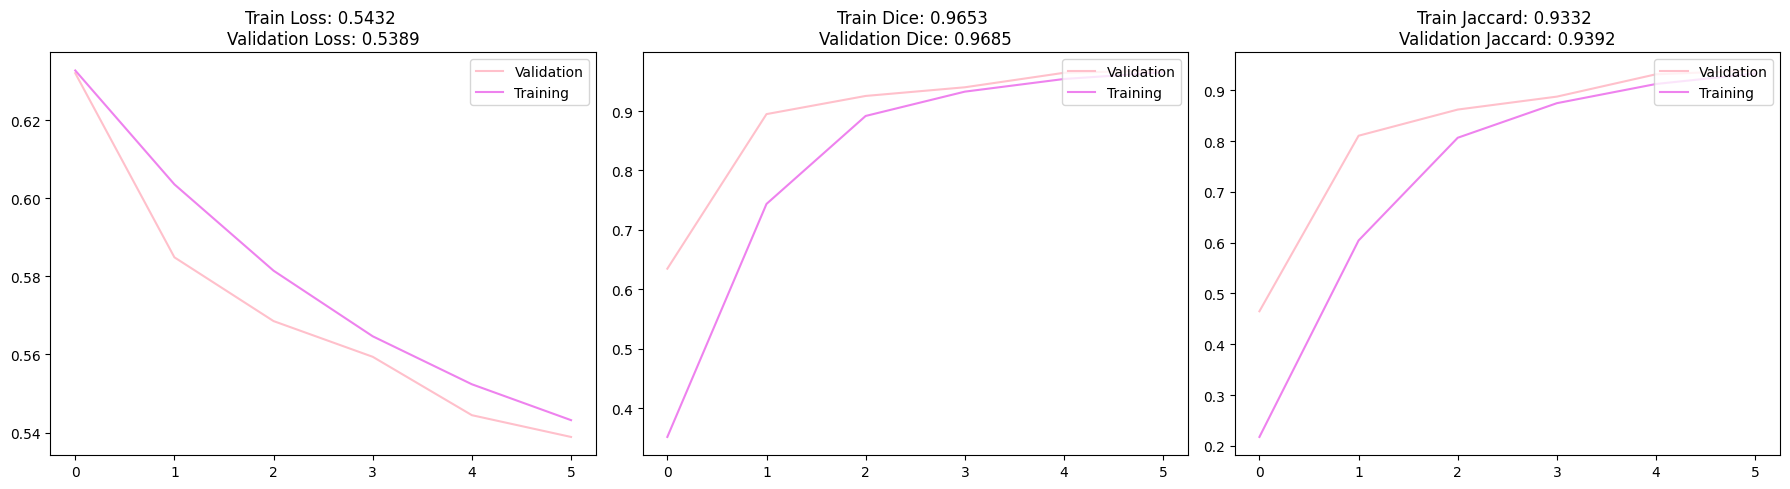

train epoch 7/70: 100%|██████████| 38/38 [00:32<00:00,  1.18it/s]


Loss: 0.5363 | Dice: 0.9729 | IoU: 0.9473


val epoch 7/70: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Loss: 0.5394 | Dice: 0.9618 | IoU: 0.9272


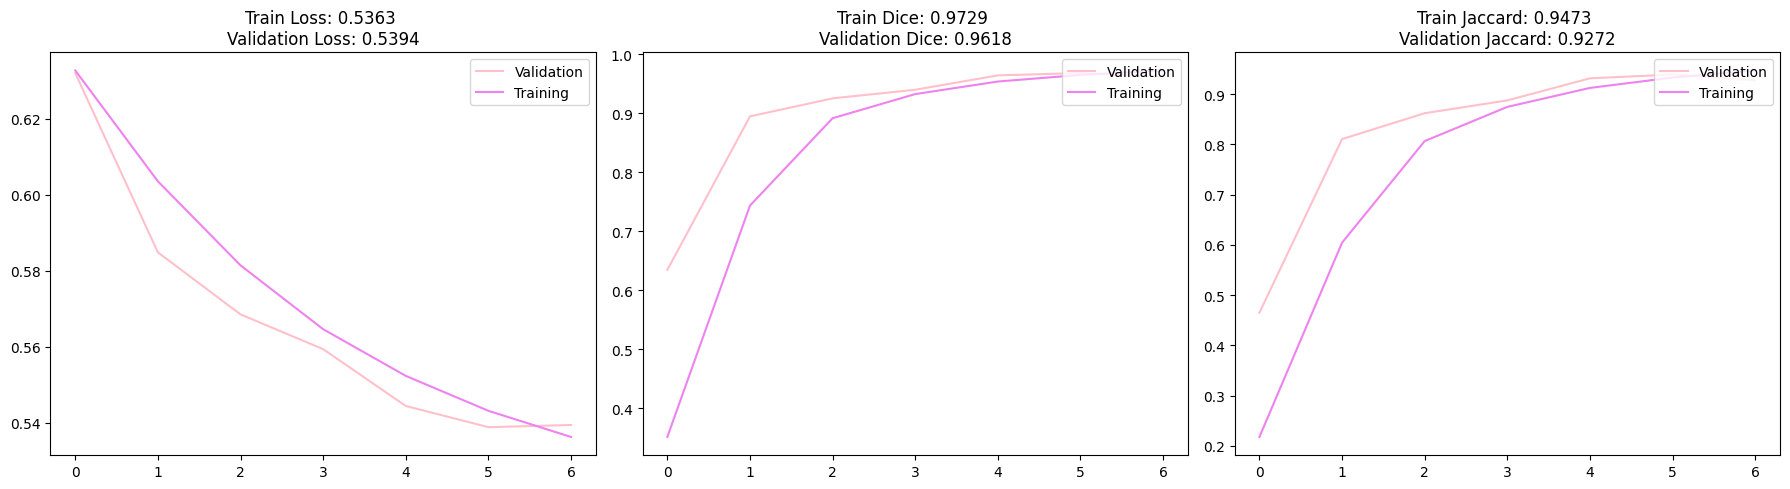

train epoch 8/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.5306 | Dice: 0.9767 | IoU: 0.9547


val epoch 8/70: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Loss: 0.5293 | Dice: 0.9731 | IoU: 0.9479


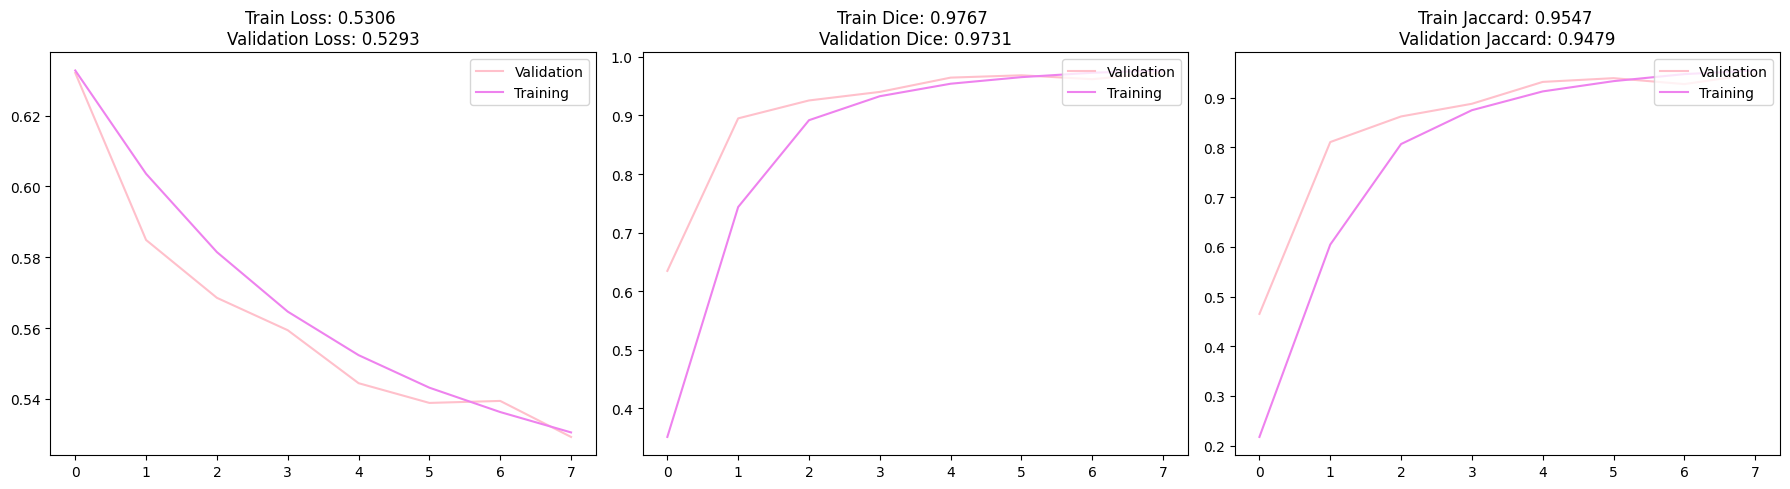

train epoch 9/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.5262 | Dice: 0.9797 | IoU: 0.9603


val epoch 9/70: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Loss: 0.5248 | Dice: 0.9791 | IoU: 0.9595


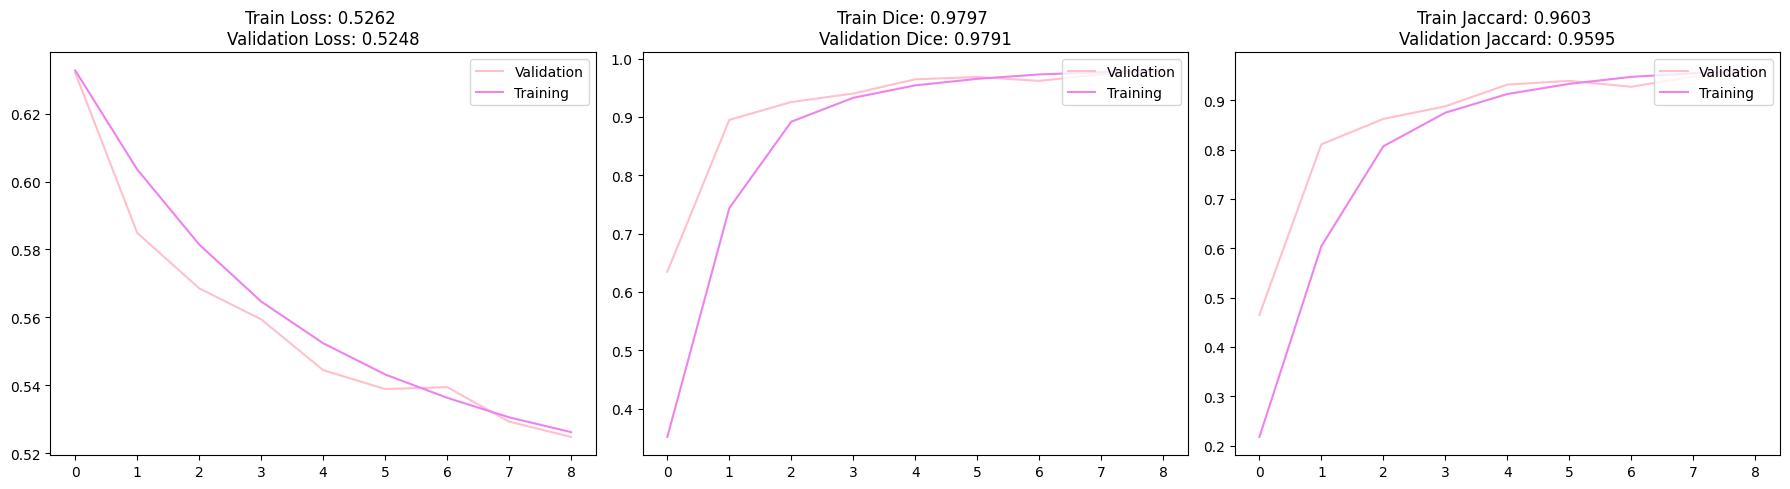

train epoch 10/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.5217 | Dice: 0.9828 | IoU: 0.9663


val epoch 10/70: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Loss: 0.5227 | Dice: 0.9758 | IoU: 0.9533


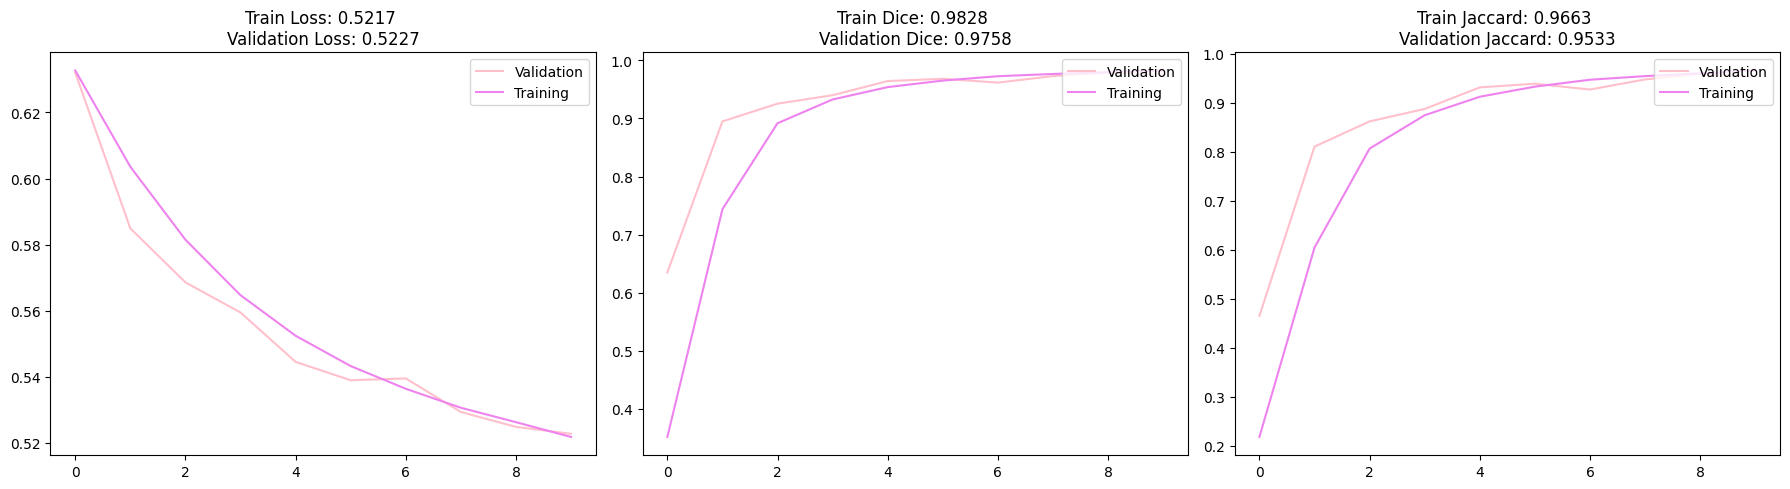

train epoch 11/70: 100%|██████████| 38/38 [00:31<00:00,  1.19it/s]


Loss: 0.5181 | Dice: 0.9842 | IoU: 0.9690


val epoch 11/70: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


Loss: 0.5164 | Dice: 0.9829 | IoU: 0.9666


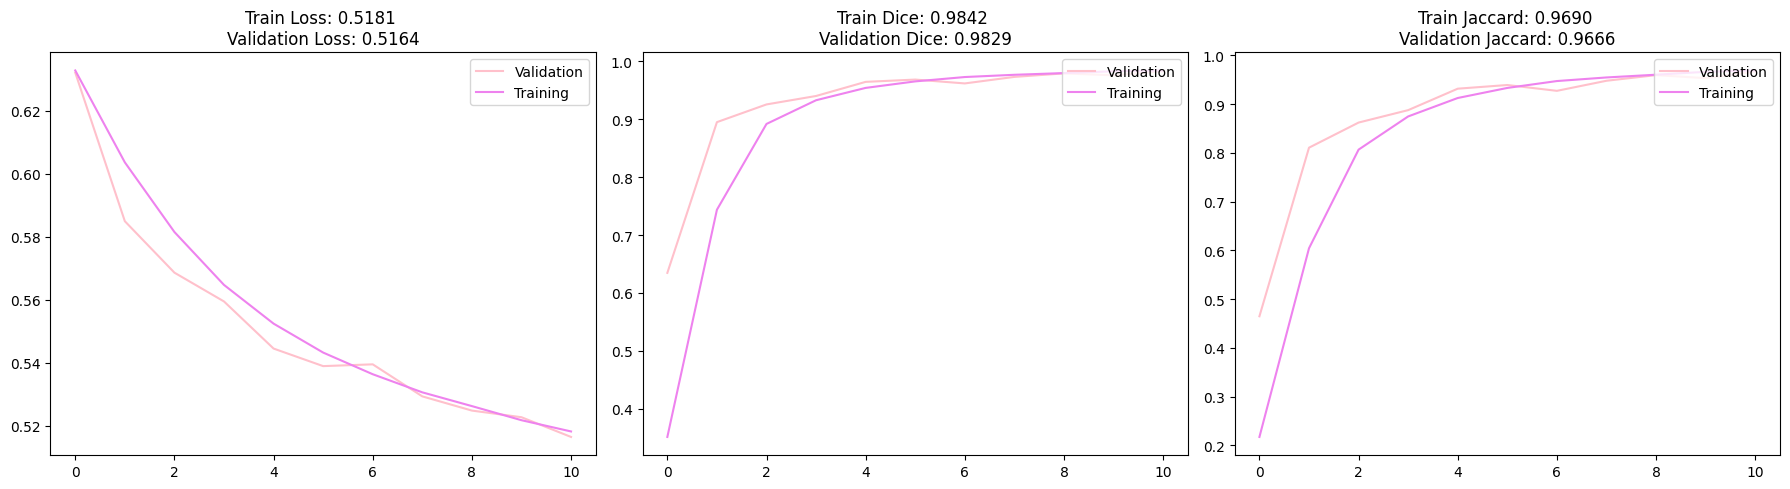

train epoch 12/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.5142 | Dice: 0.9852 | IoU: 0.9710


val epoch 12/70: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


Loss: 0.5138 | Dice: 0.9840 | IoU: 0.9686


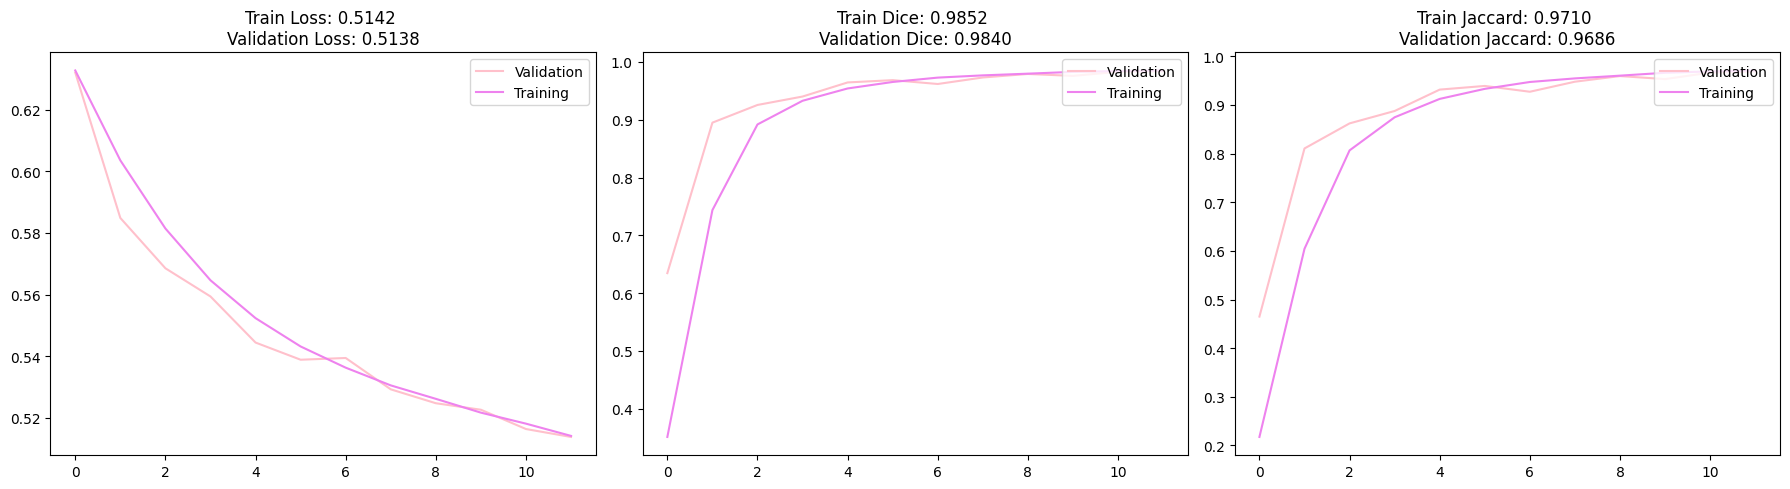

train epoch 13/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.5093 | Dice: 0.9862 | IoU: 0.9729


val epoch 13/70: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Loss: 0.5120 | Dice: 0.9769 | IoU: 0.9551


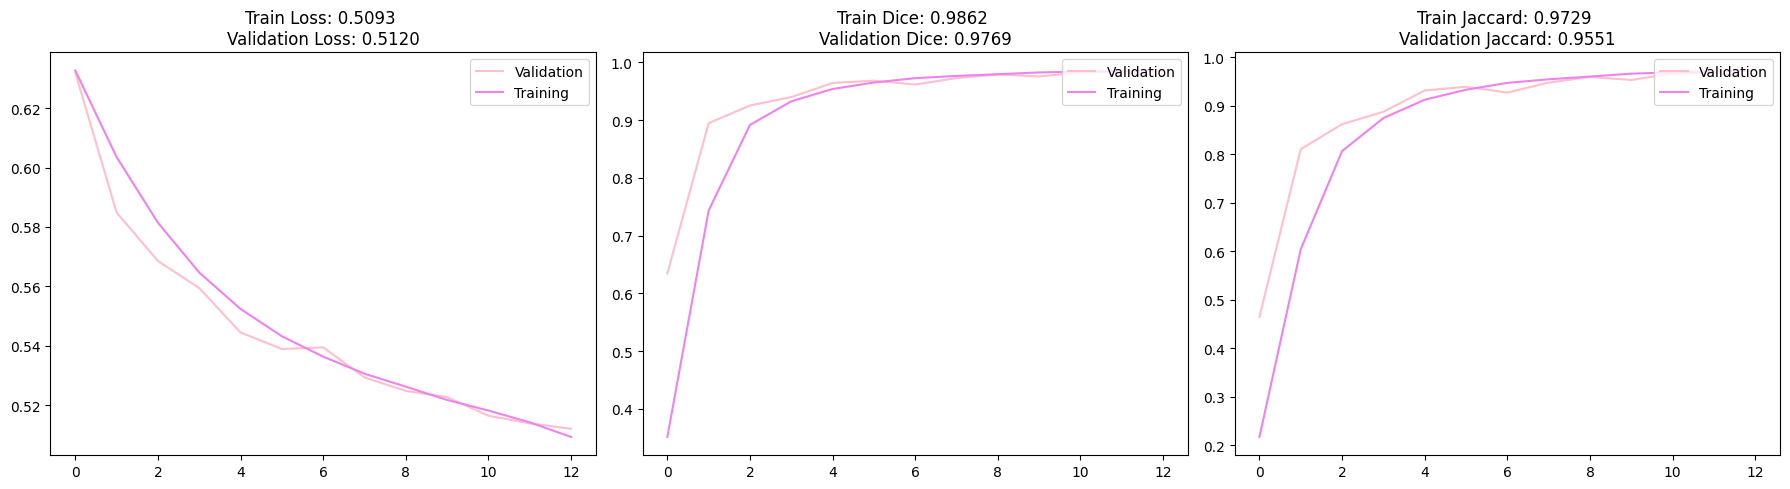

train epoch 14/70: 100%|██████████| 38/38 [00:31<00:00,  1.19it/s]


Loss: 0.5047 | Dice: 0.9852 | IoU: 0.9711


val epoch 14/70: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Loss: 0.5170 | Dice: 0.9628 | IoU: 0.9299


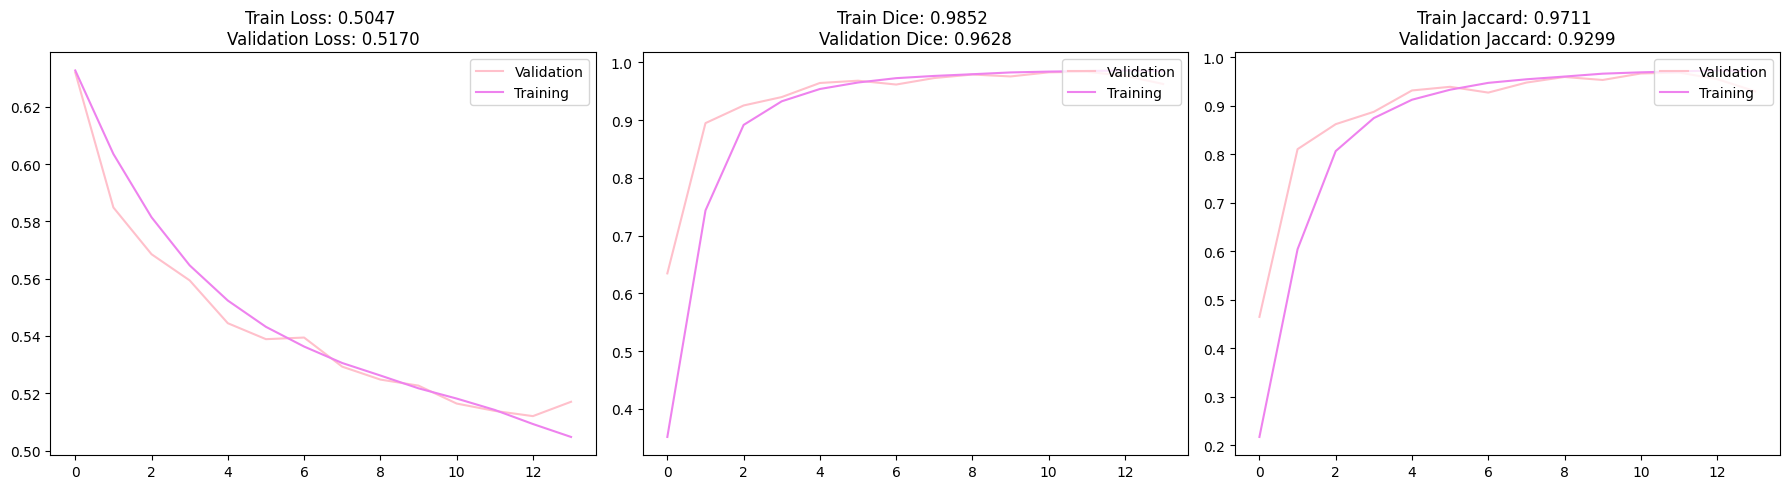

train epoch 15/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.5009 | Dice: 0.9830 | IoU: 0.9667


val epoch 15/70: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Loss: 0.4977 | Dice: 0.9855 | IoU: 0.9717


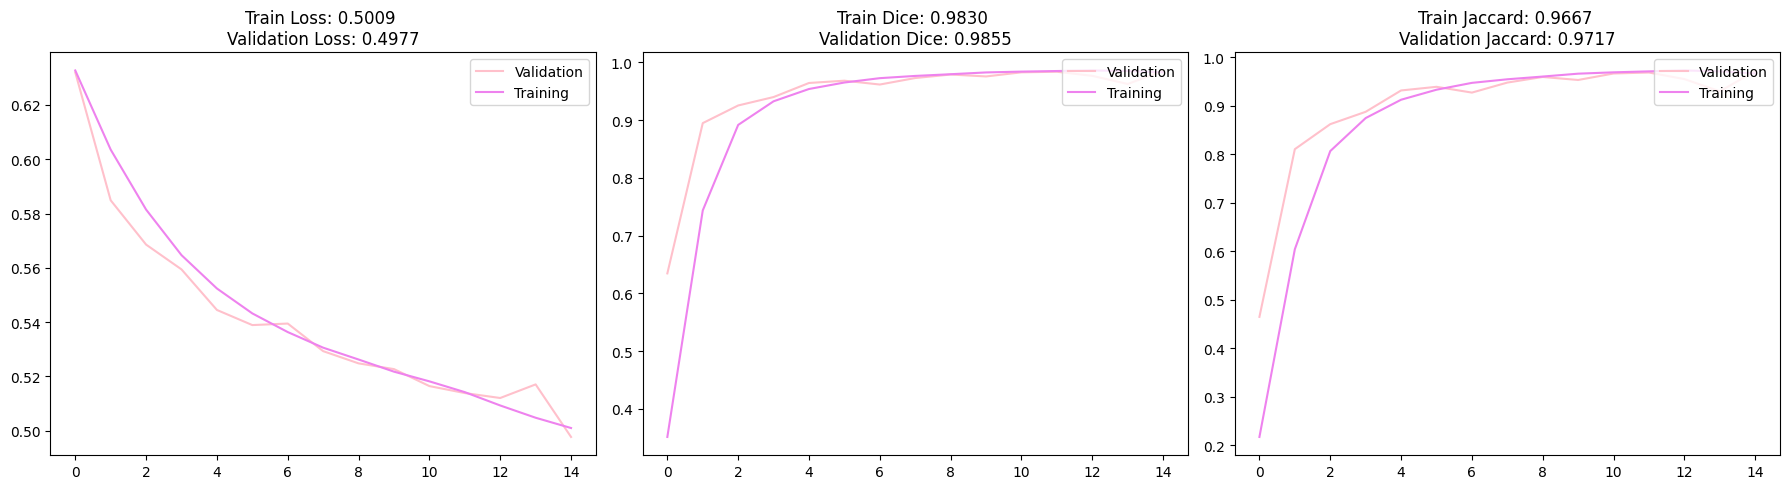

train epoch 16/70: 100%|██████████| 38/38 [00:31<00:00,  1.19it/s]


Loss: 0.4956 | Dice: 0.9848 | IoU: 0.9703


val epoch 16/70: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Loss: 0.4949 | Dice: 0.9828 | IoU: 0.9663


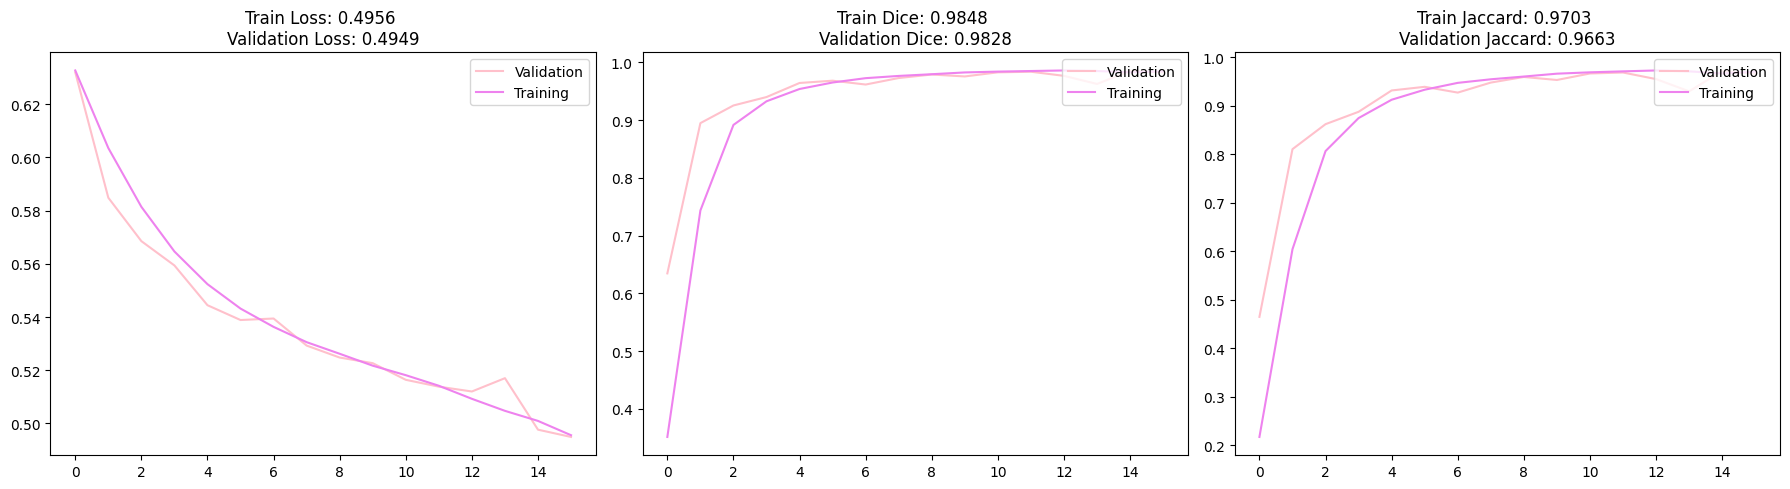

train epoch 17/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.4908 | Dice: 0.9854 | IoU: 0.9714


val epoch 17/70: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Loss: 0.4901 | Dice: 0.9868 | IoU: 0.9740


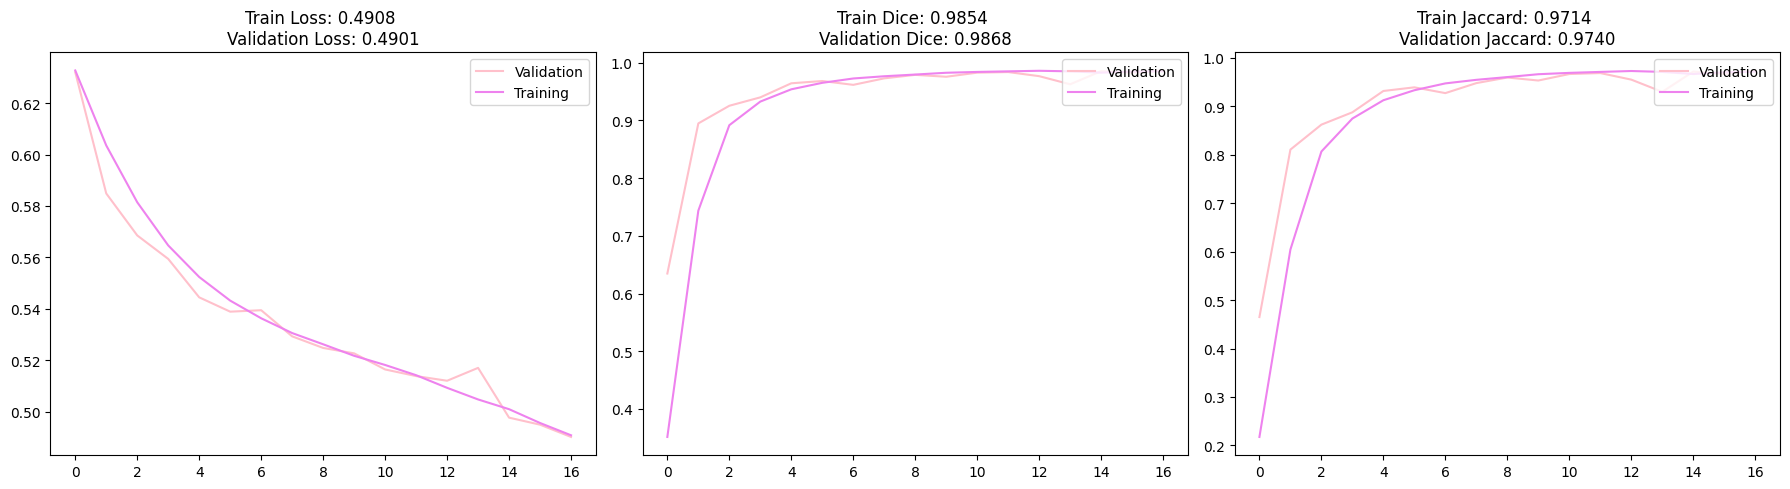

train epoch 18/70: 100%|██████████| 38/38 [00:31<00:00,  1.22it/s]


Loss: 0.4880 | Dice: 0.9849 | IoU: 0.9706


val epoch 18/70: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


Loss: 0.4965 | Dice: 0.9660 | IoU: 0.9357


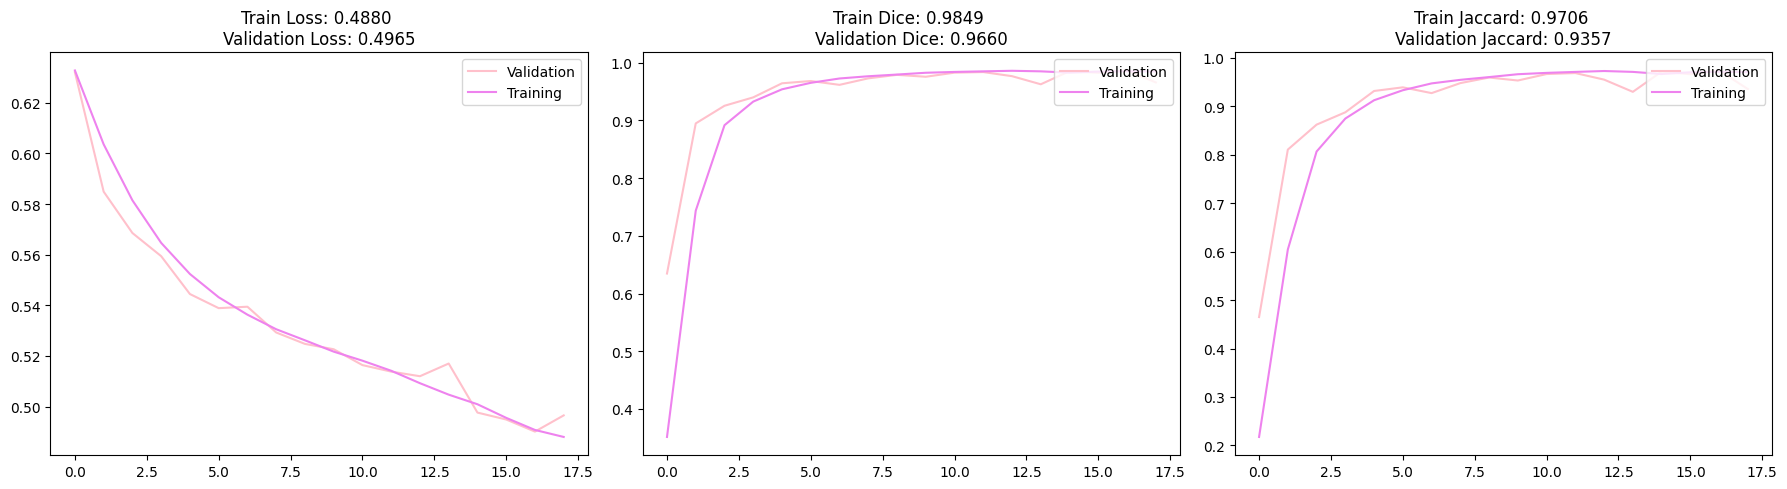

train epoch 19/70: 100%|██████████| 38/38 [00:31<00:00,  1.22it/s]


Loss: 0.4852 | Dice: 0.9837 | IoU: 0.9680


val epoch 19/70: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Loss: 0.4836 | Dice: 0.9843 | IoU: 0.9691


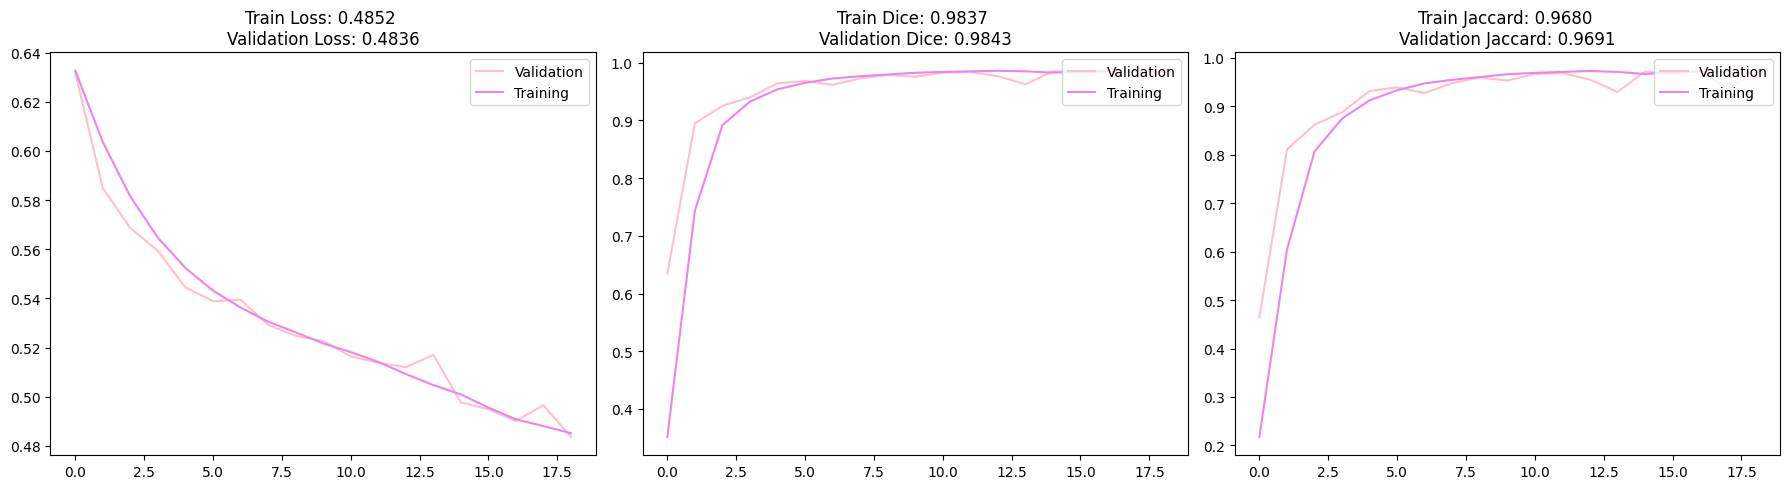

train epoch 20/70: 100%|██████████| 38/38 [00:31<00:00,  1.19it/s]


Loss: 0.4812 | Dice: 0.9853 | IoU: 0.9711


val epoch 20/70: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Loss: 0.4788 | Dice: 0.9858 | IoU: 0.9722


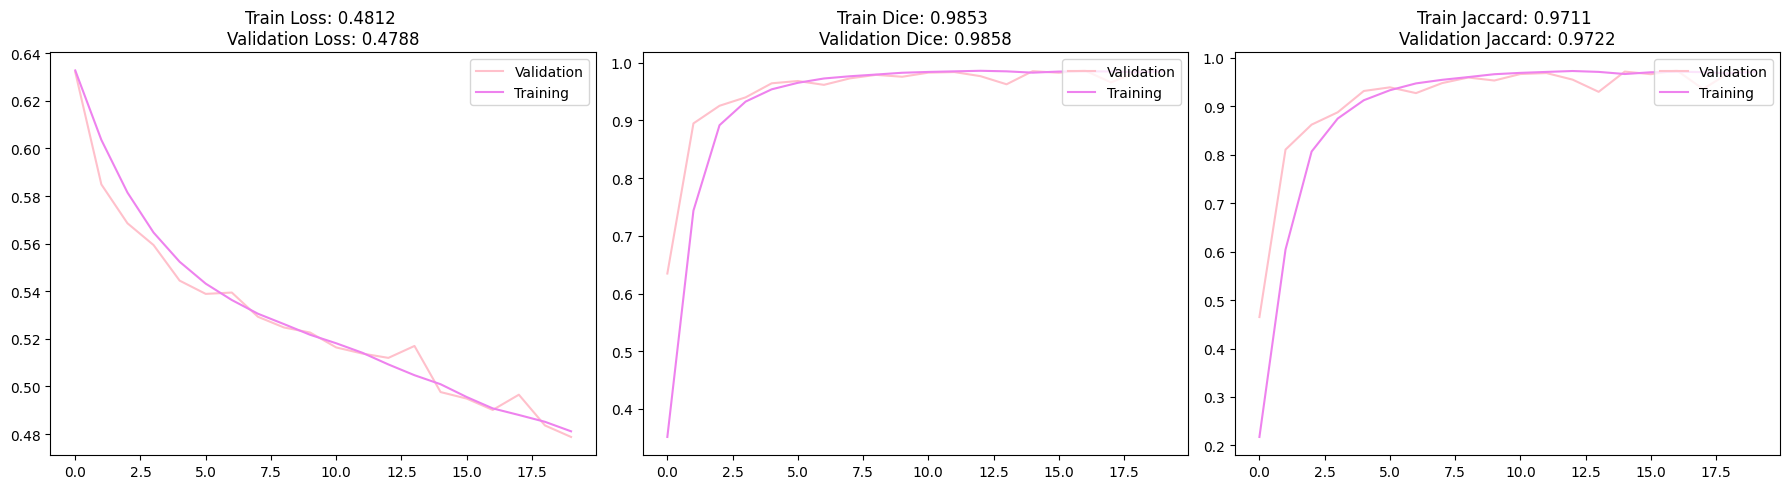

train epoch 21/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.4774 | Dice: 0.9871 | IoU: 0.9747


val epoch 21/70: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


Loss: 0.4776 | Dice: 0.9872 | IoU: 0.9748


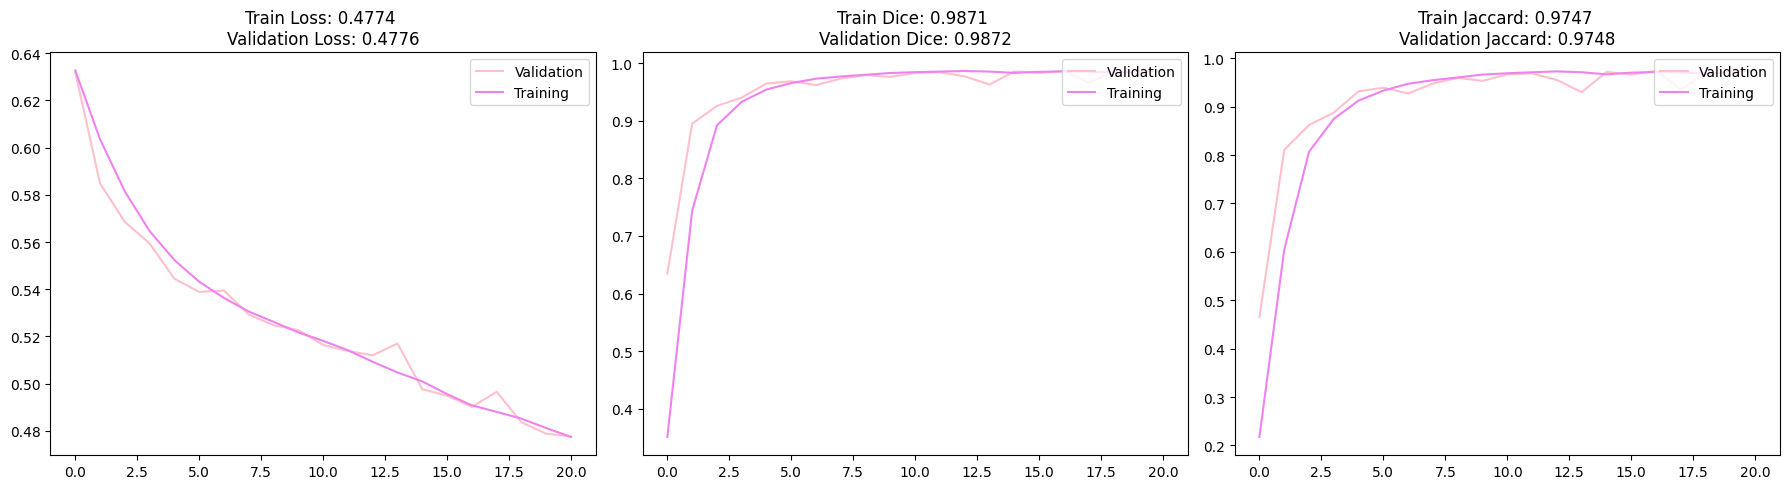

train epoch 22/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.4742 | Dice: 0.9873 | IoU: 0.9750


val epoch 22/70: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


Loss: 0.4744 | Dice: 0.9832 | IoU: 0.9672


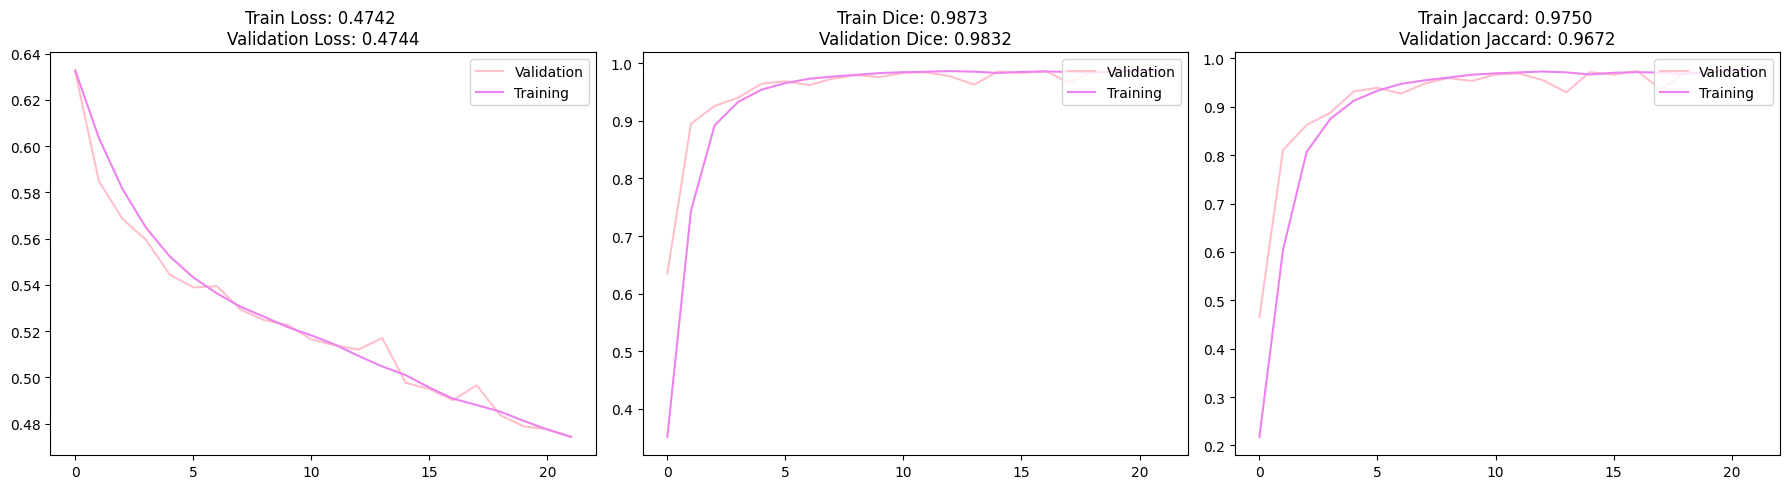

train epoch 23/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.4713 | Dice: 0.9880 | IoU: 0.9765


val epoch 23/70: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Loss: 0.4719 | Dice: 0.9835 | IoU: 0.9677


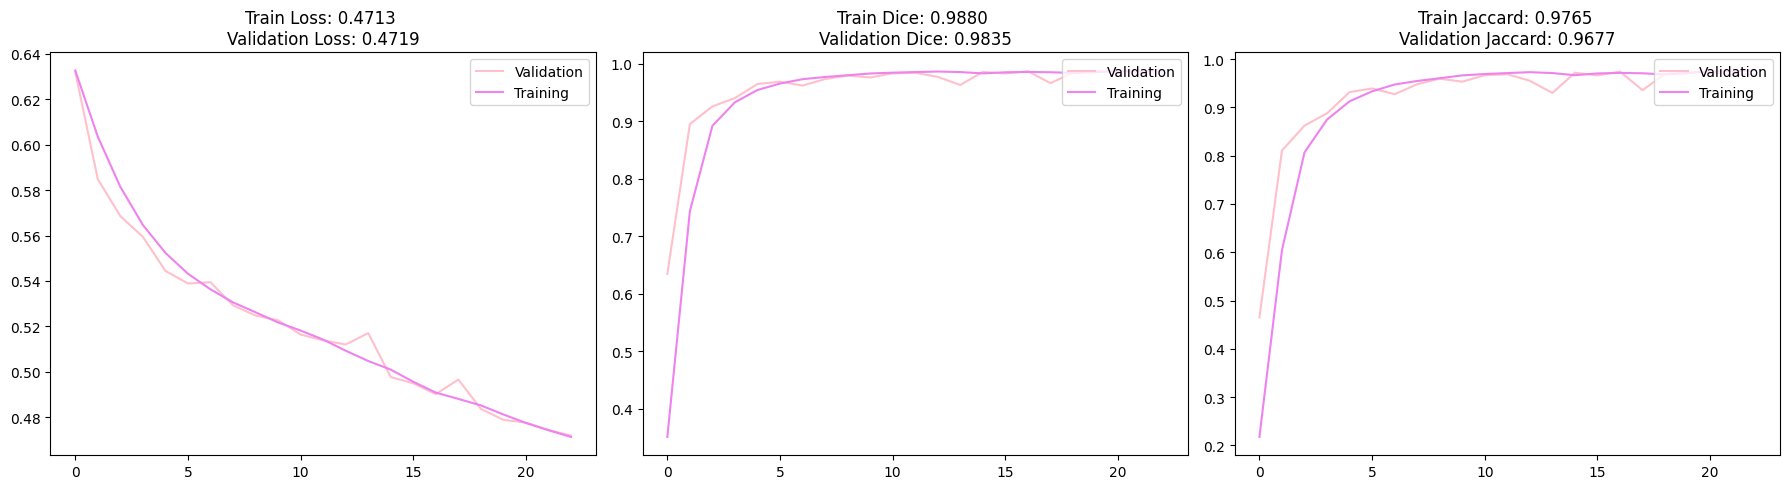

train epoch 24/70: 100%|██████████| 38/38 [00:32<00:00,  1.18it/s]


Loss: 0.4684 | Dice: 0.9885 | IoU: 0.9774


val epoch 24/70: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Loss: 0.4703 | Dice: 0.9811 | IoU: 0.9633


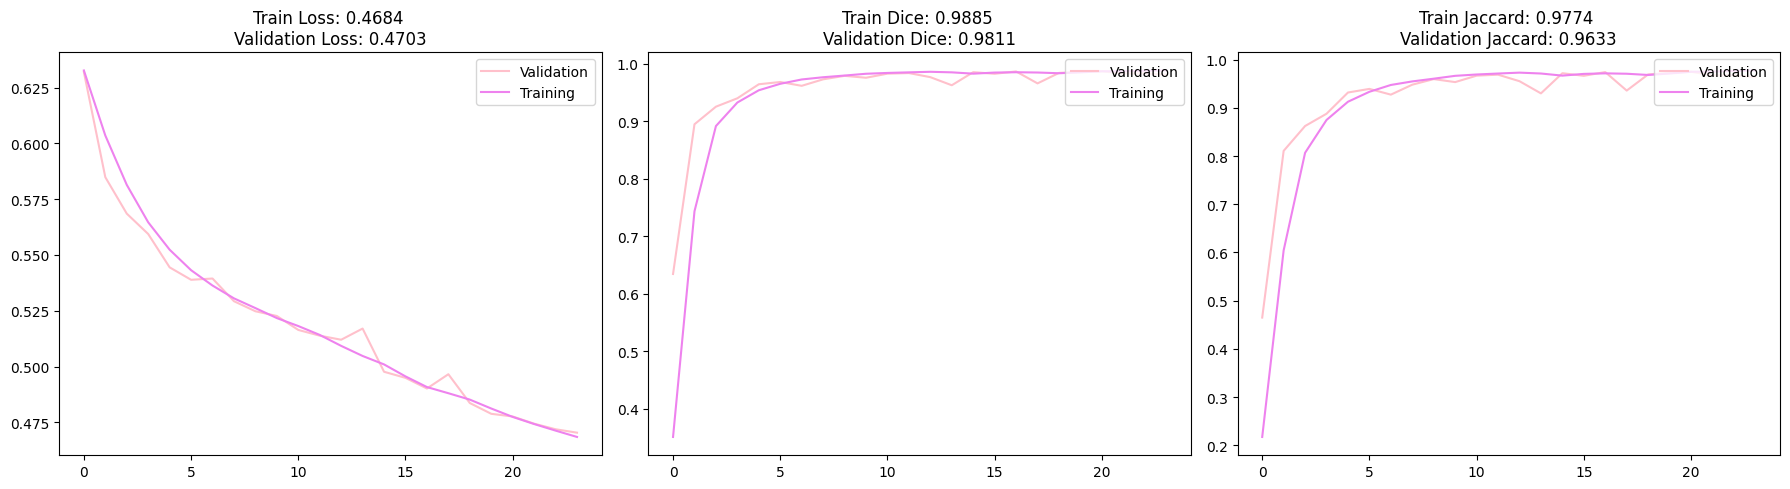

train epoch 25/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.4667 | Dice: 0.9861 | IoU: 0.9727


val epoch 25/70: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Loss: 0.4657 | Dice: 0.9853 | IoU: 0.9711


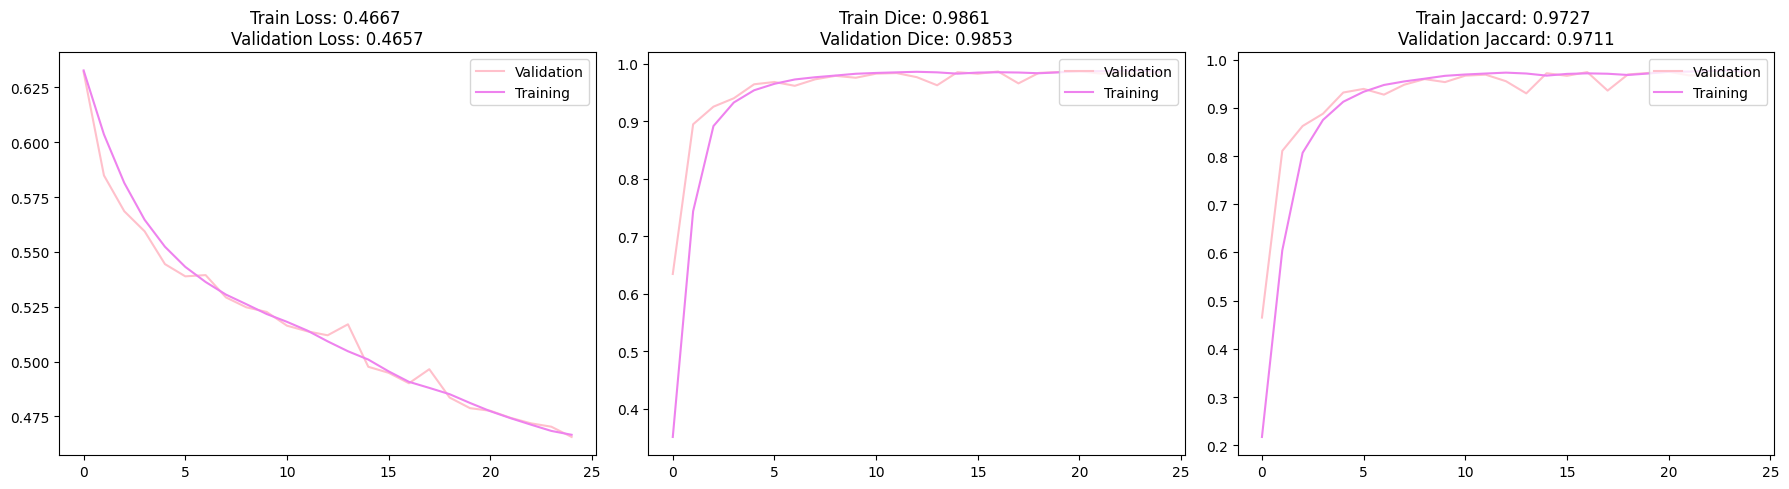

train epoch 26/70: 100%|██████████| 38/38 [00:31<00:00,  1.19it/s]


Loss: 0.4629 | Dice: 0.9883 | IoU: 0.9770


val epoch 26/70: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Loss: 0.4627 | Dice: 0.9853 | IoU: 0.9712


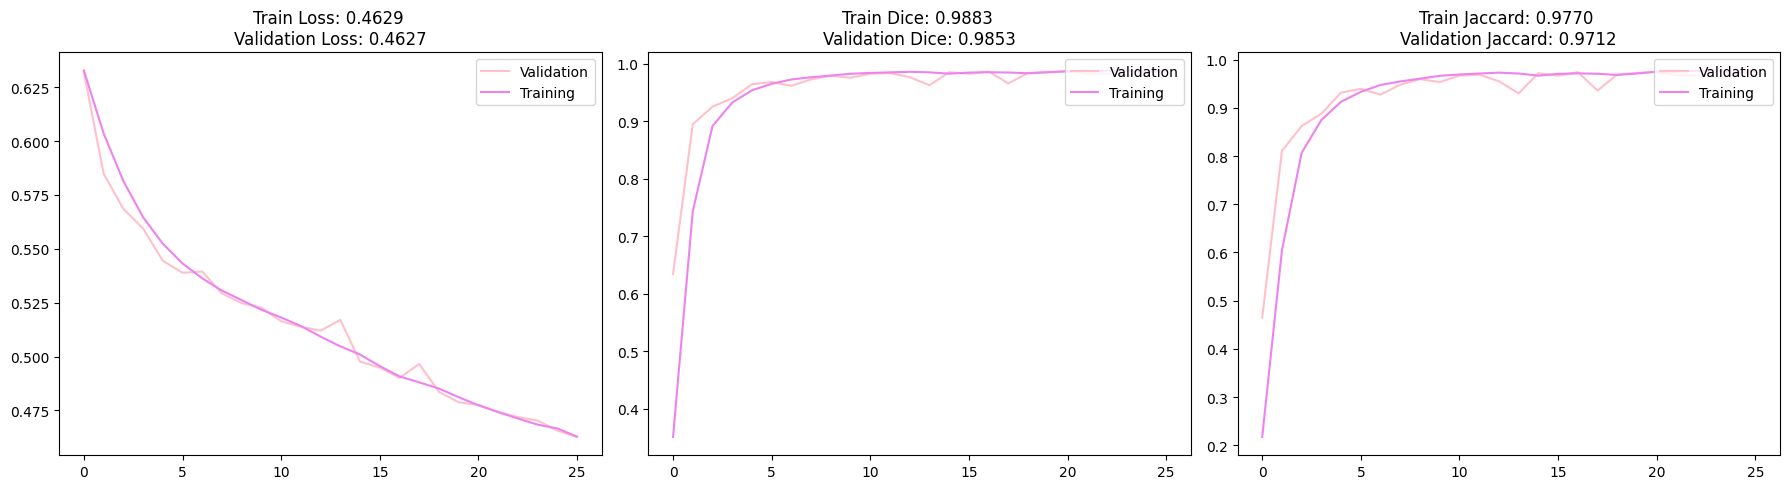

train epoch 27/70: 100%|██████████| 38/38 [00:32<00:00,  1.18it/s]


Loss: 0.4602 | Dice: 0.9887 | IoU: 0.9778


val epoch 27/70: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Loss: 0.4605 | Dice: 0.9860 | IoU: 0.9725


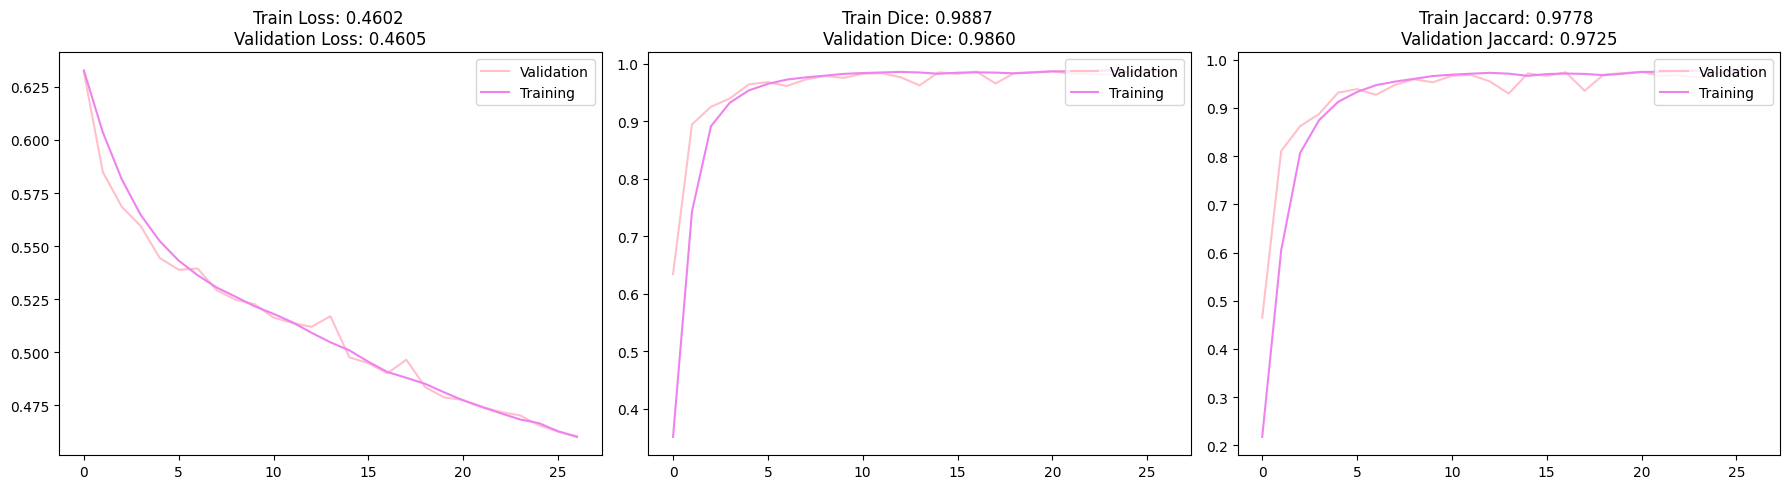

train epoch 28/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.4572 | Dice: 0.9888 | IoU: 0.9778


val epoch 28/70: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Loss: 0.4584 | Dice: 0.9875 | IoU: 0.9754


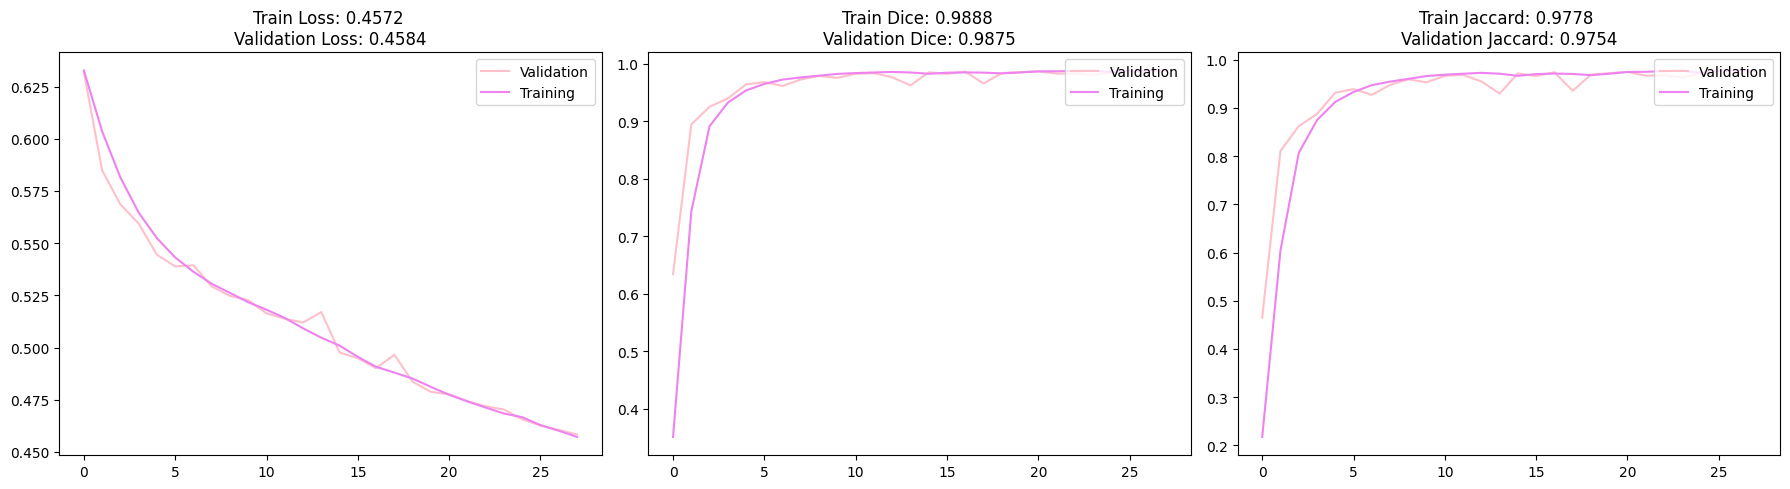

train epoch 29/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.4545 | Dice: 0.9891 | IoU: 0.9786


val epoch 29/70: 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Loss: 0.4574 | Dice: 0.9833 | IoU: 0.9674


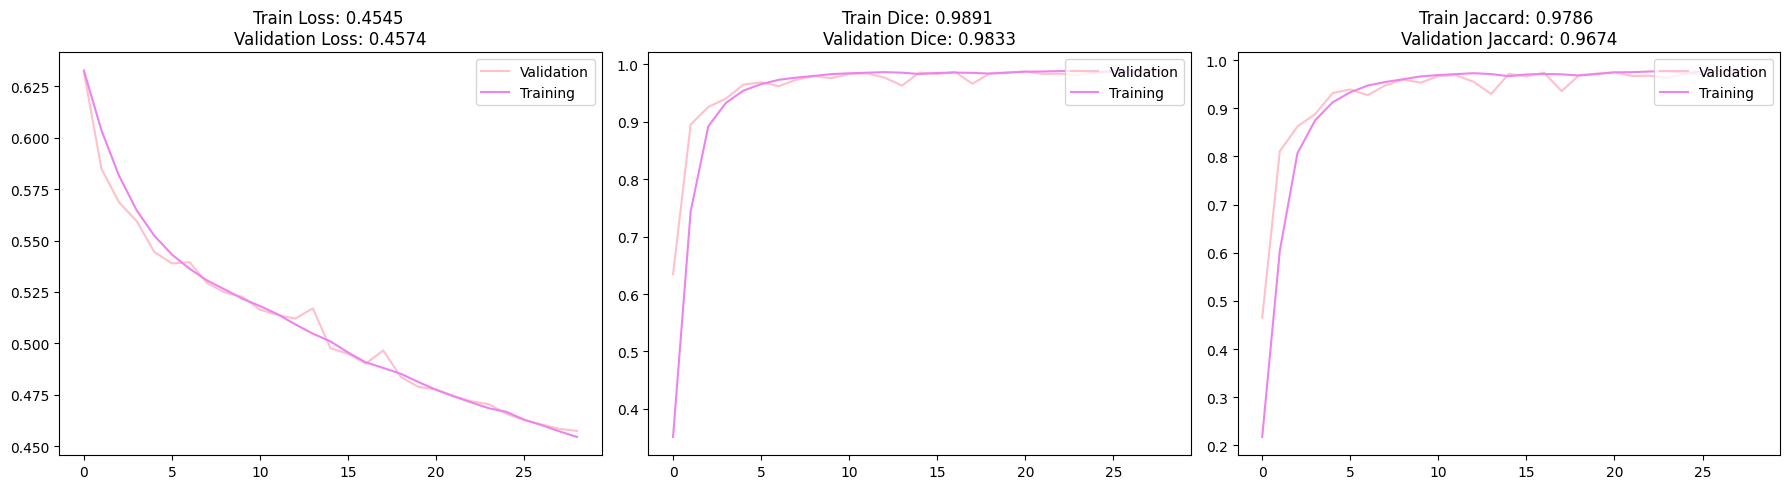

train epoch 30/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.4515 | Dice: 0.9895 | IoU: 0.9794


val epoch 30/70: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Loss: 0.4511 | Dice: 0.9881 | IoU: 0.9765


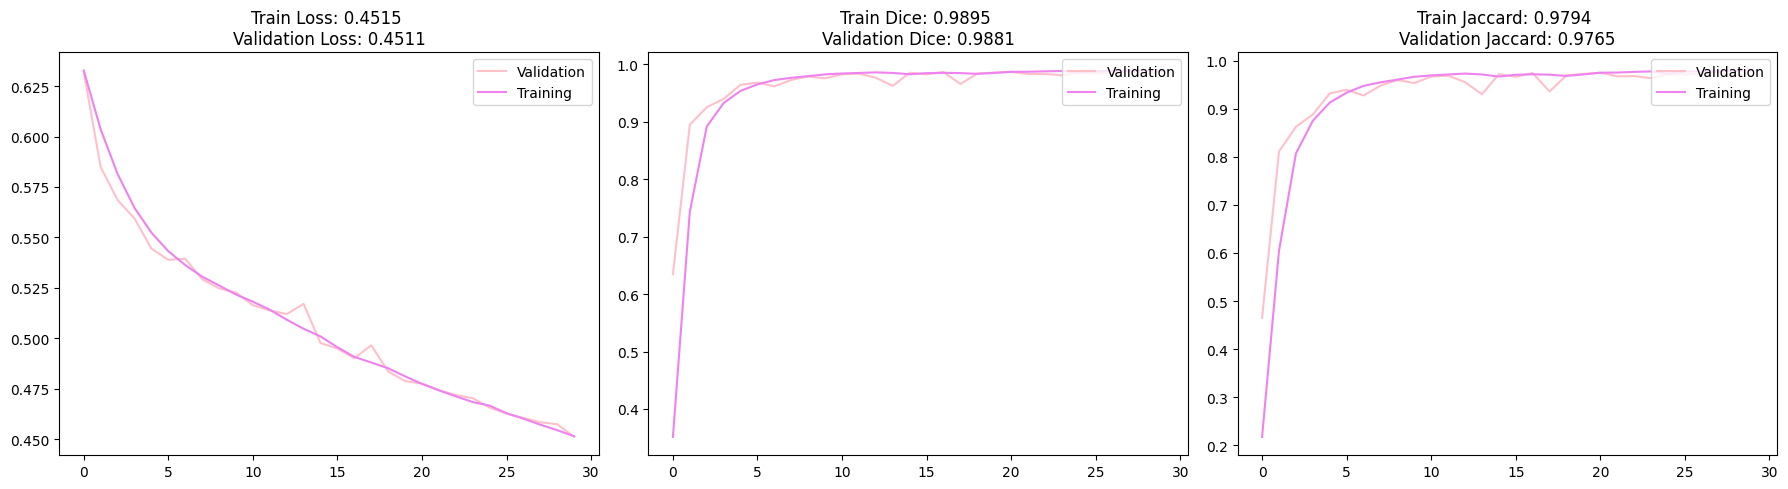

train epoch 31/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.4489 | Dice: 0.9898 | IoU: 0.9798


val epoch 31/70: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Loss: 0.4513 | Dice: 0.9830 | IoU: 0.9666


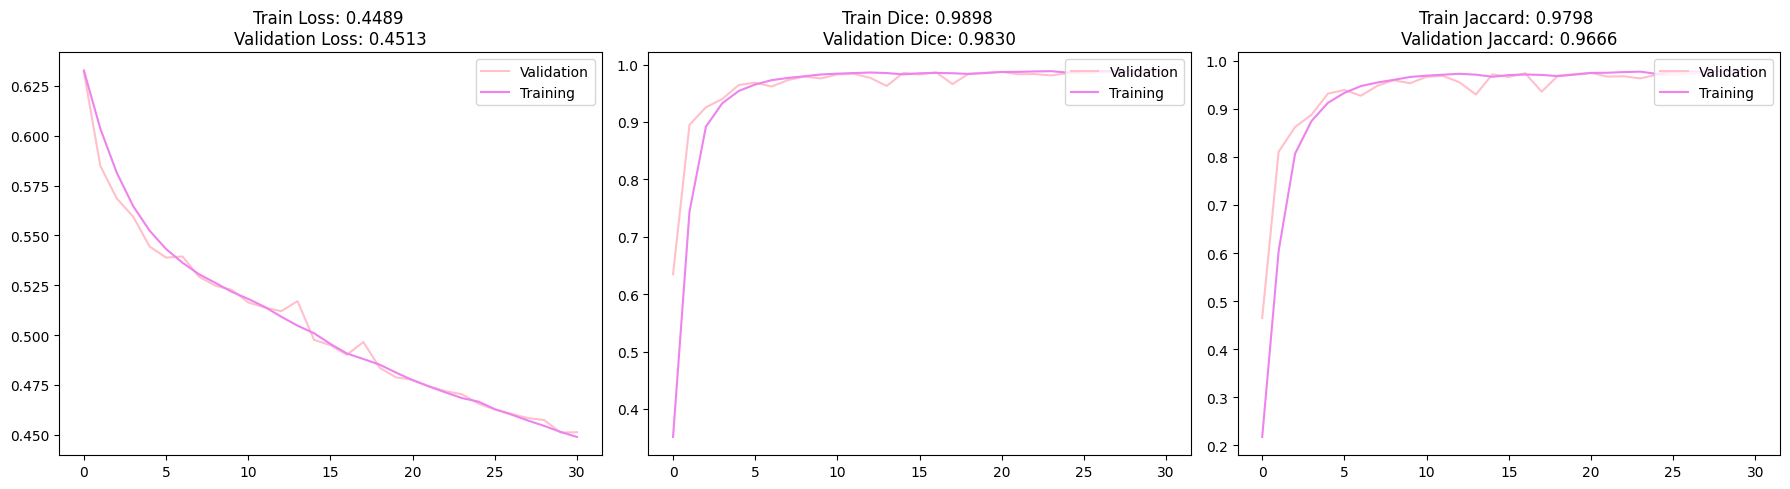

train epoch 32/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.4482 | Dice: 0.9857 | IoU: 0.9719


val epoch 32/70: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


Loss: 0.4483 | Dice: 0.9823 | IoU: 0.9653


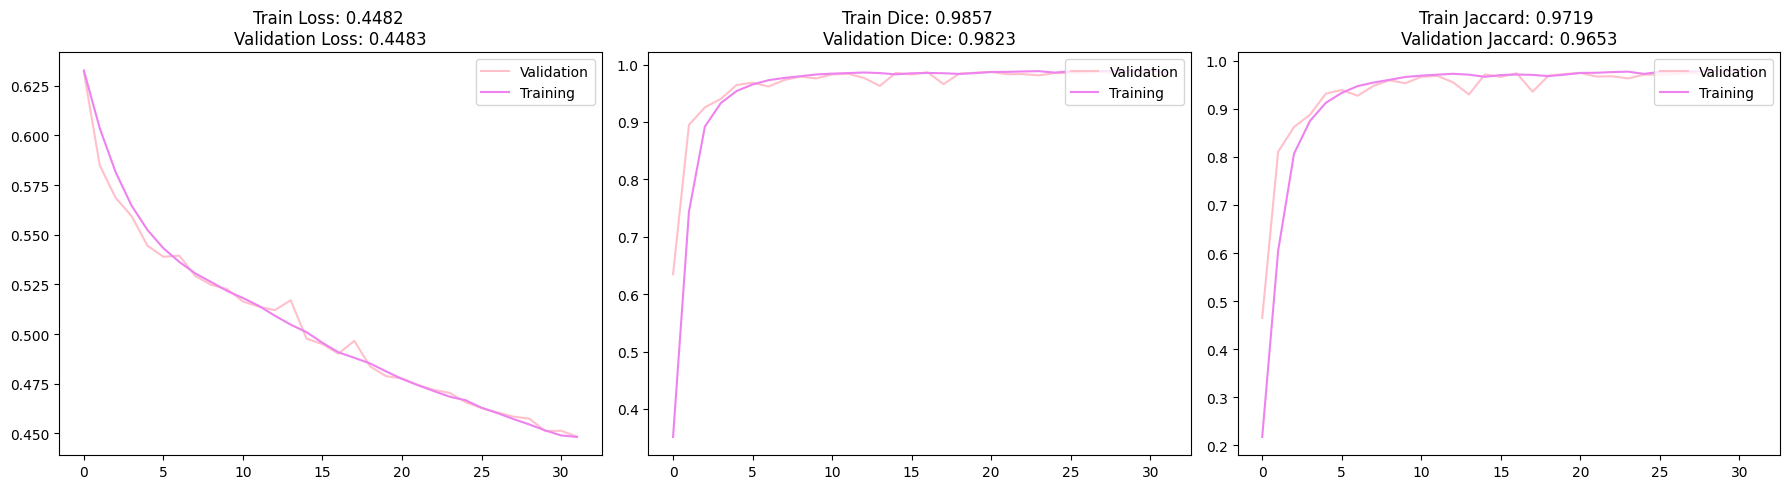

train epoch 33/70: 100%|██████████| 38/38 [00:32<00:00,  1.18it/s]


Loss: 0.4439 | Dice: 0.9894 | IoU: 0.9791


val epoch 33/70: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Loss: 0.4437 | Dice: 0.9872 | IoU: 0.9748


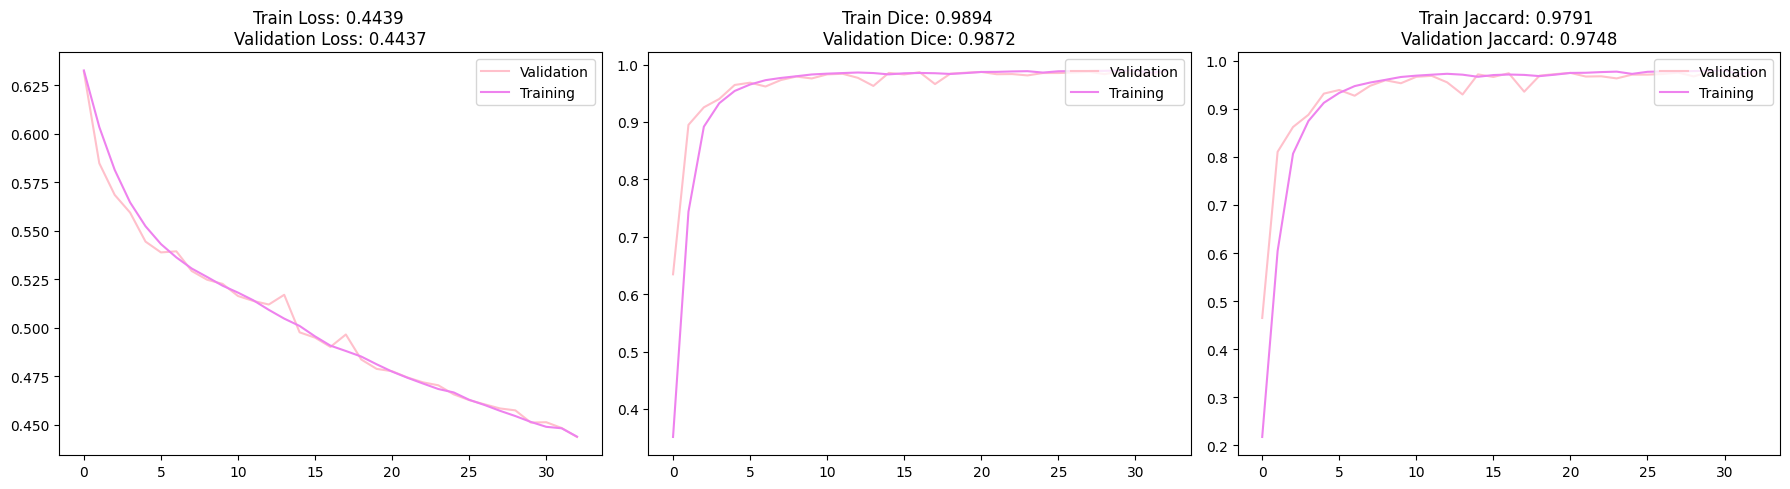

train epoch 34/70: 100%|██████████| 38/38 [00:32<00:00,  1.18it/s]


Loss: 0.4406 | Dice: 0.9904 | IoU: 0.9810


val epoch 34/70: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Loss: 0.4416 | Dice: 0.9880 | IoU: 0.9764


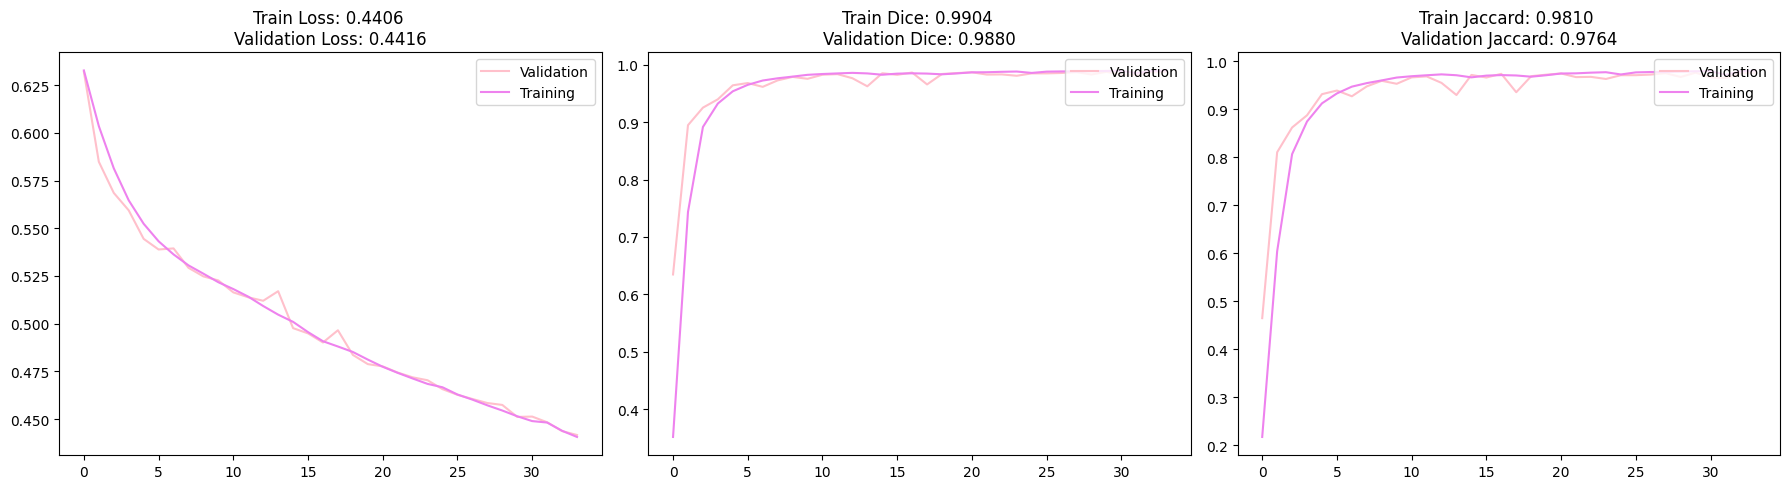

train epoch 35/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.4378 | Dice: 0.9910 | IoU: 0.9823


val epoch 35/70: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


Loss: 0.4375 | Dice: 0.9889 | IoU: 0.9781


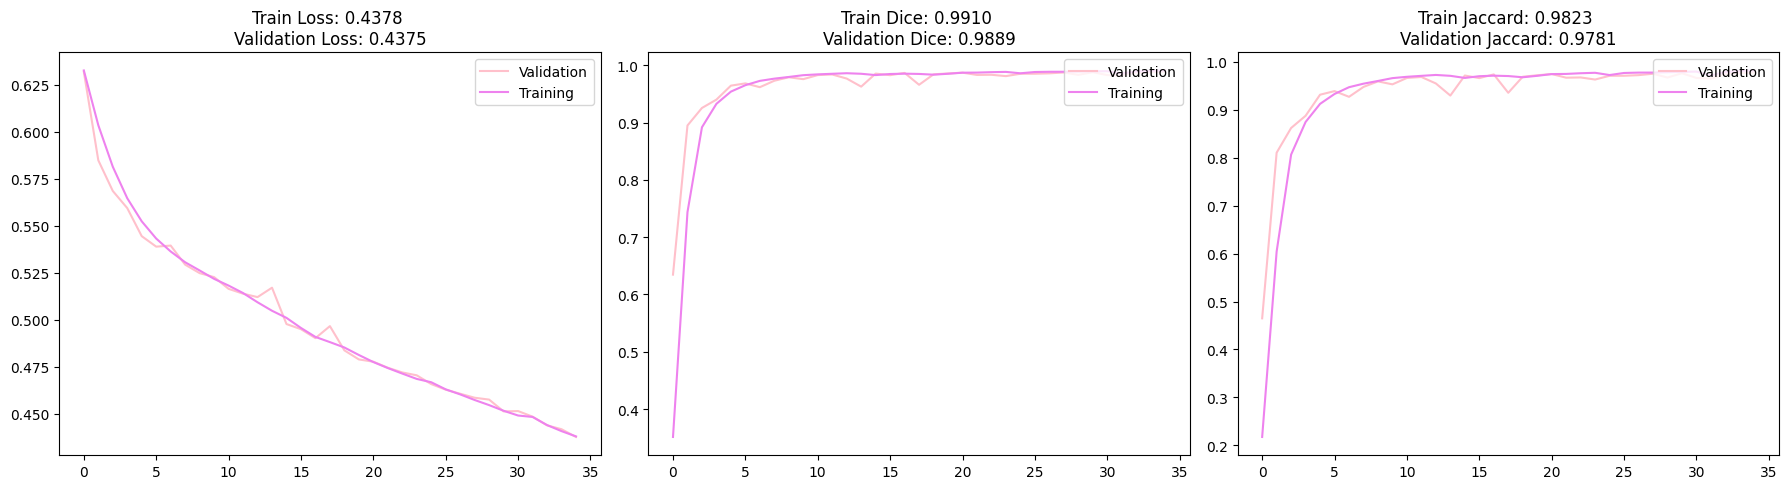

train epoch 36/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.4358 | Dice: 0.9912 | IoU: 0.9826


val epoch 36/70: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Loss: 0.4375 | Dice: 0.9852 | IoU: 0.9709


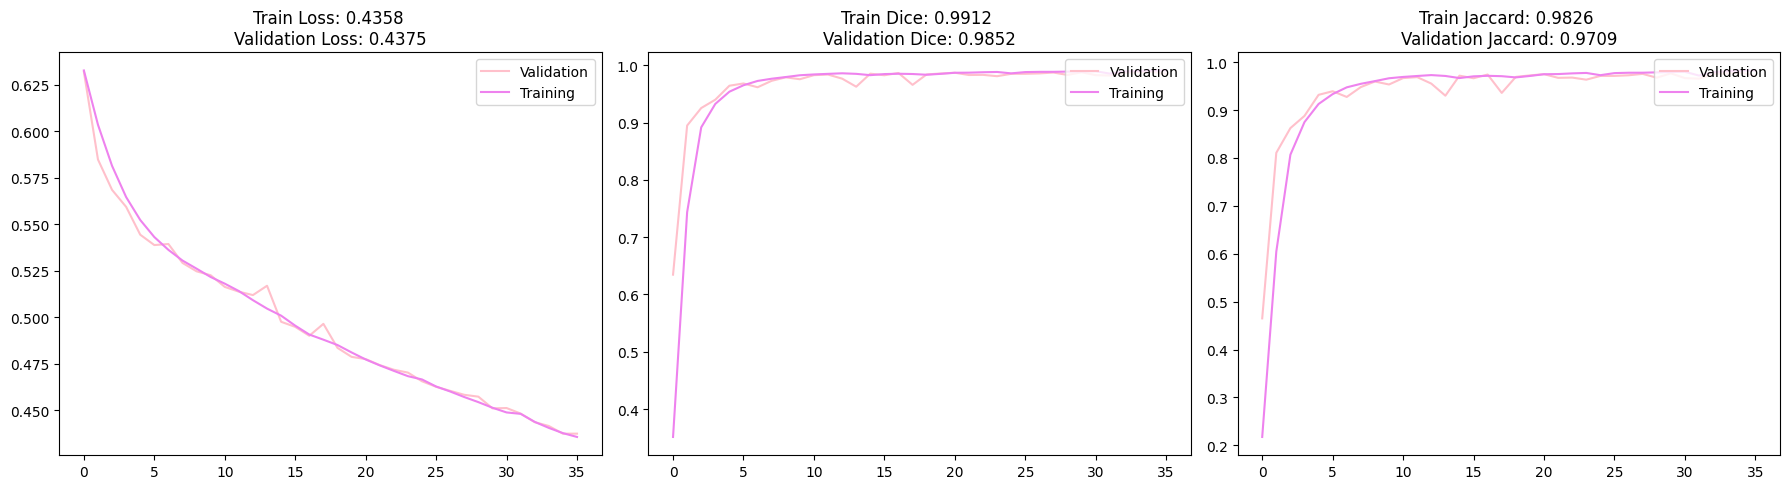

train epoch 37/70: 100%|██████████| 38/38 [00:31<00:00,  1.22it/s]


Loss: 0.4326 | Dice: 0.9915 | IoU: 0.9832


val epoch 37/70: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Loss: 0.4325 | Dice: 0.9889 | IoU: 0.9781


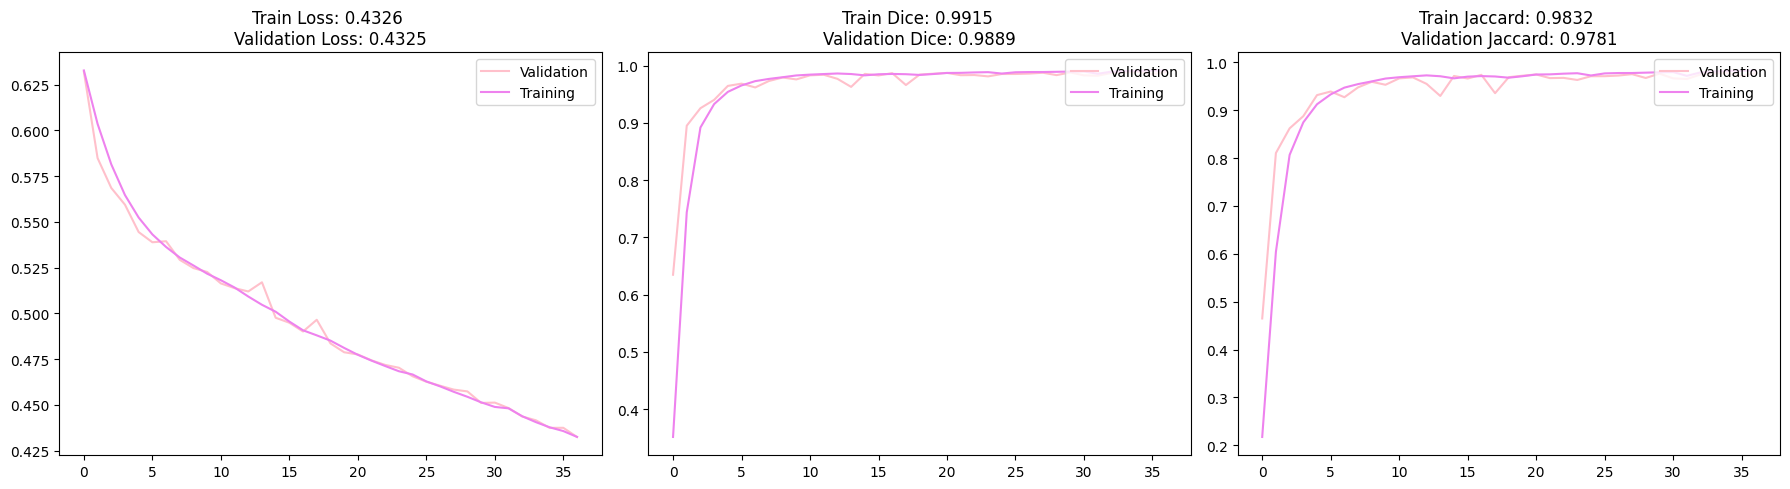

train epoch 38/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.4296 | Dice: 0.9925 | IoU: 0.9851


val epoch 38/70: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Loss: 0.4310 | Dice: 0.9879 | IoU: 0.9762


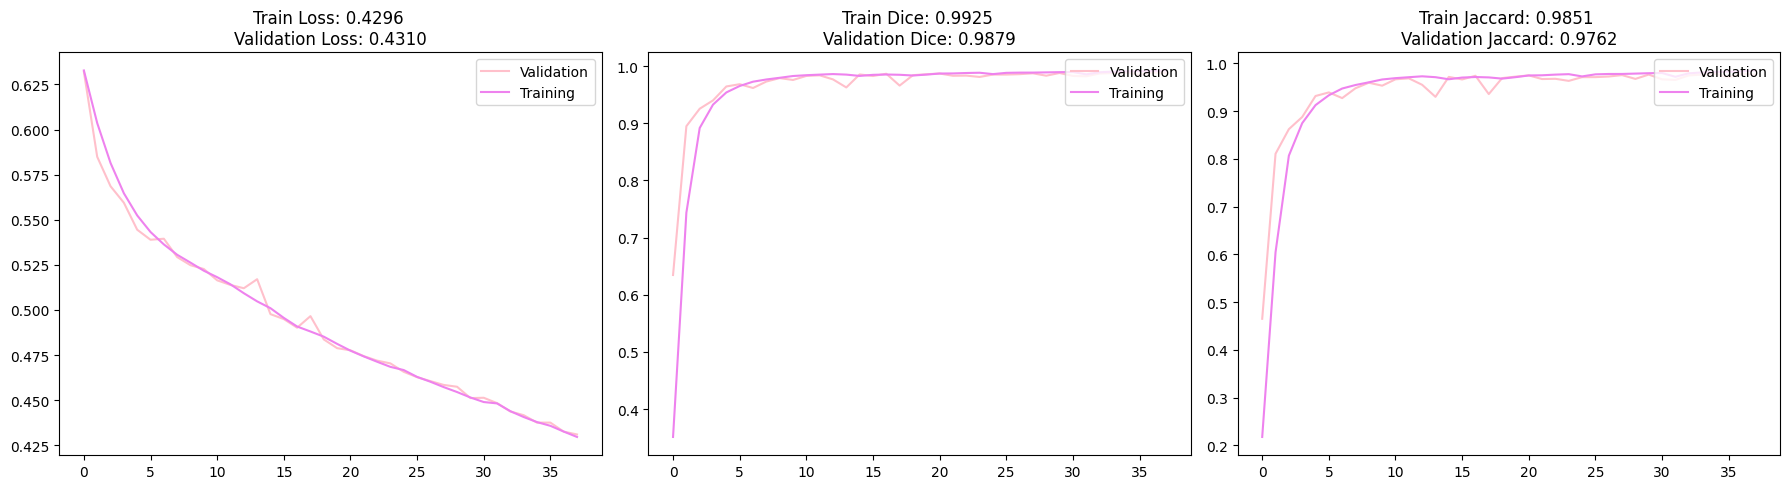

train epoch 39/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.4267 | Dice: 0.9926 | IoU: 0.9854


val epoch 39/70: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Loss: 0.4284 | Dice: 0.9876 | IoU: 0.9756


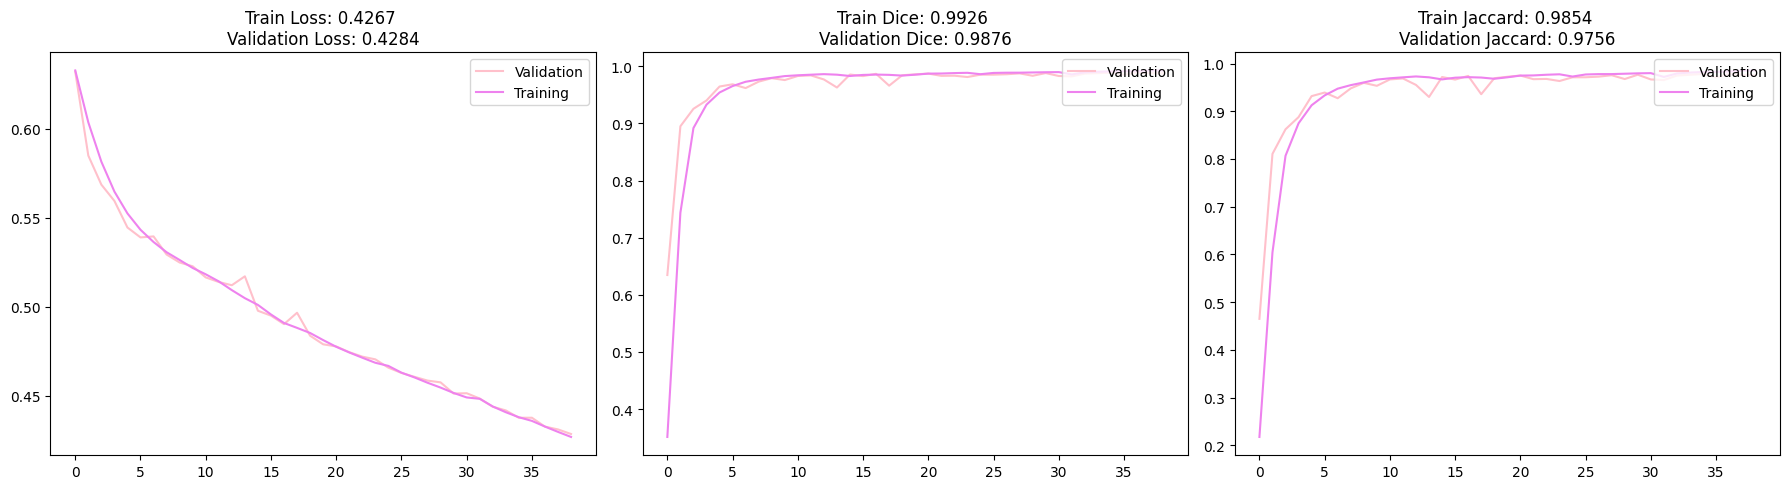

train epoch 40/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.4243 | Dice: 0.9923 | IoU: 0.9848


val epoch 40/70: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


Loss: 0.4244 | Dice: 0.9888 | IoU: 0.9779


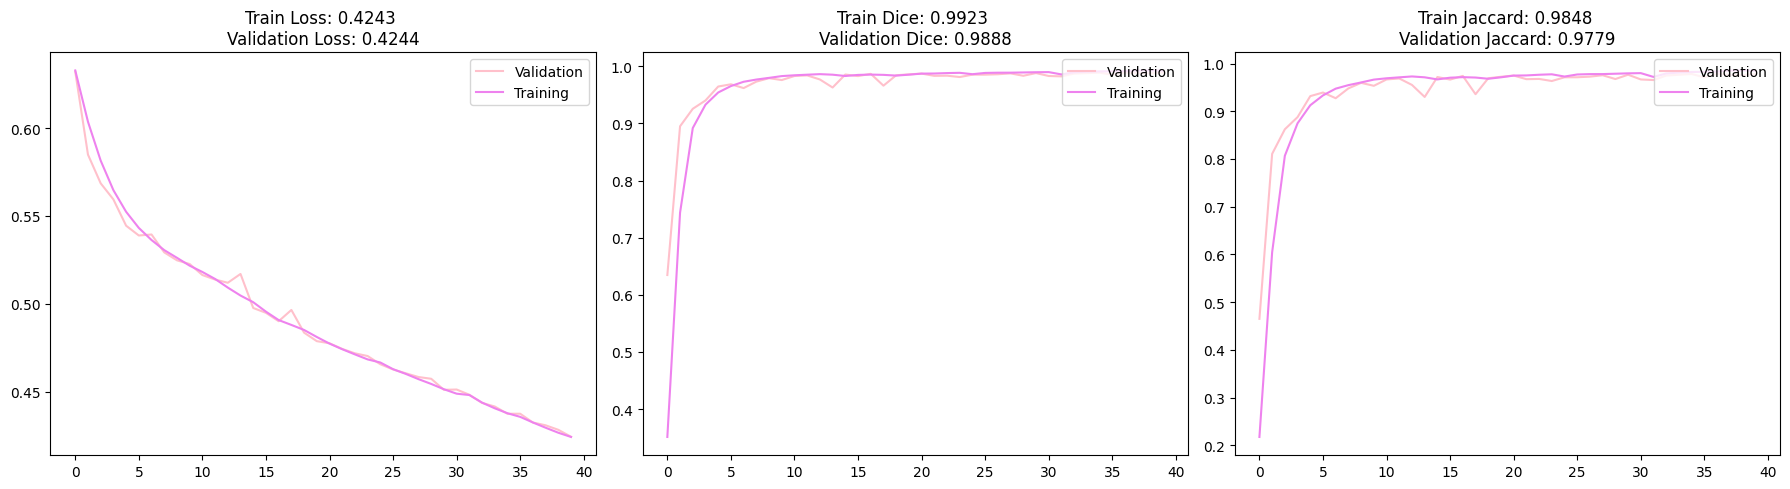

train epoch 41/70: 100%|██████████| 38/38 [00:31<00:00,  1.19it/s]


Loss: 0.4220 | Dice: 0.9926 | IoU: 0.9853


val epoch 41/70: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Loss: 0.4238 | Dice: 0.9876 | IoU: 0.9756


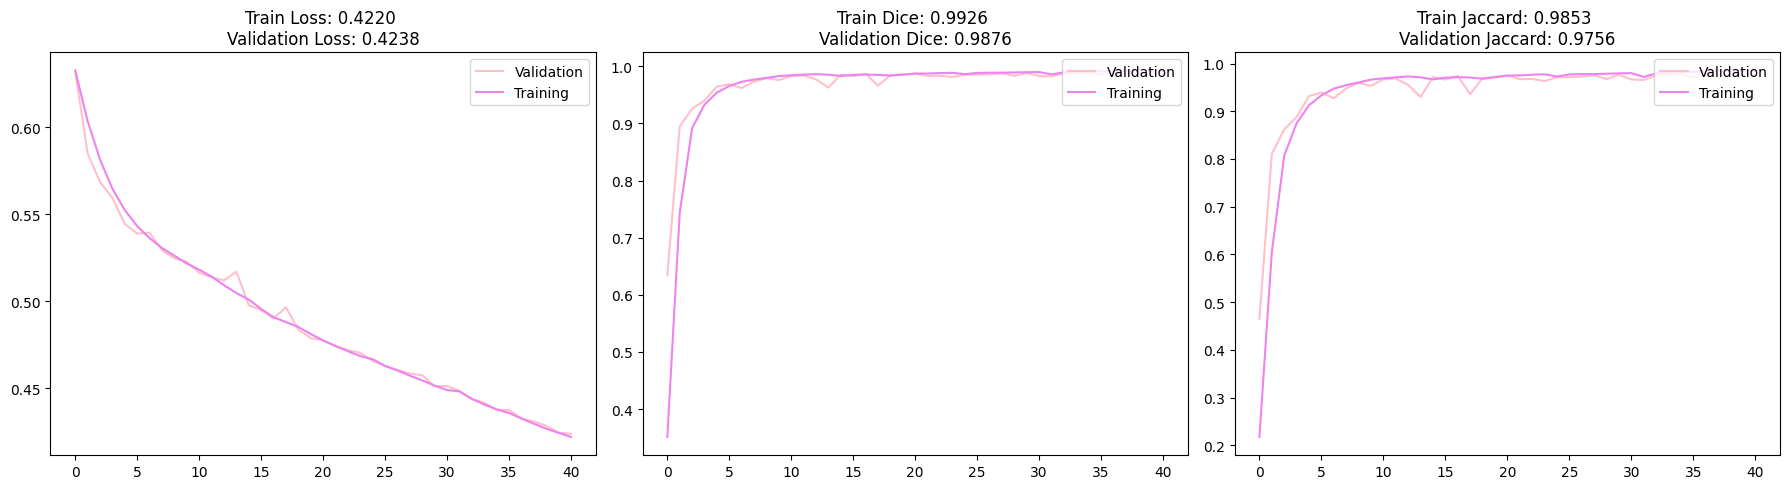

train epoch 42/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.4194 | Dice: 0.9927 | IoU: 0.9856


val epoch 42/70: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Loss: 0.4210 | Dice: 0.9881 | IoU: 0.9765


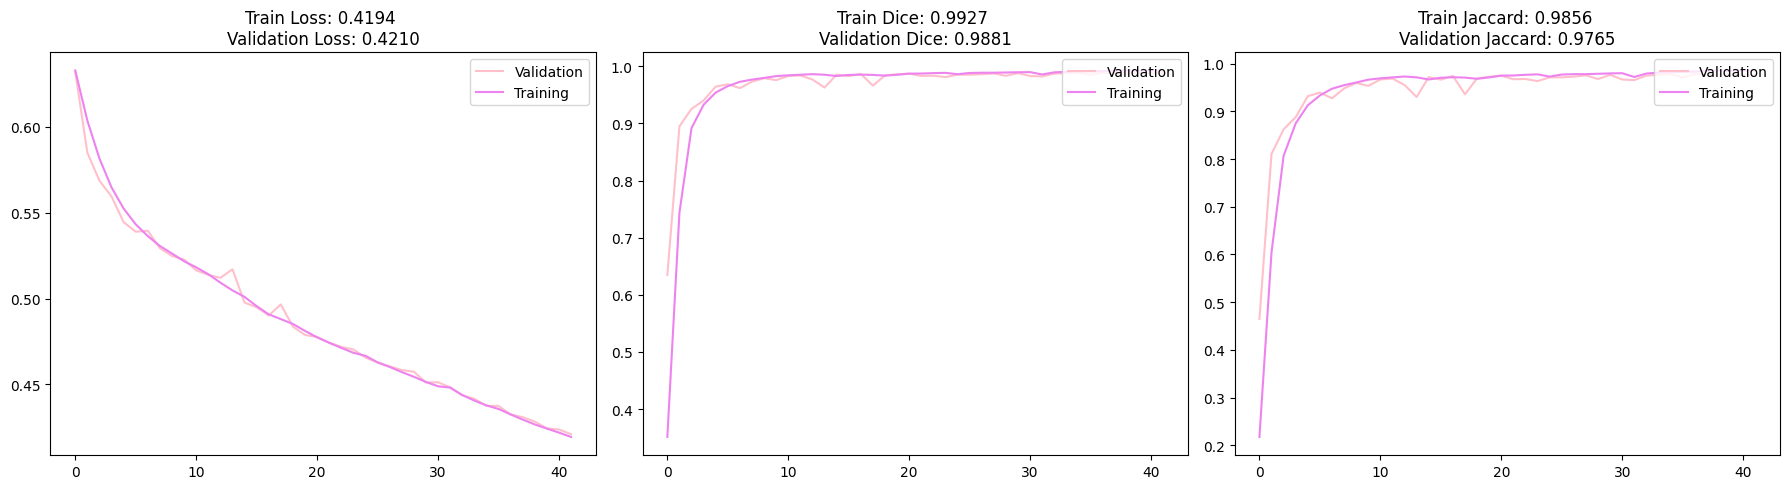

train epoch 43/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.4158 | Dice: 0.9938 | IoU: 0.9878


val epoch 43/70: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Loss: 0.4180 | Dice: 0.9872 | IoU: 0.9748


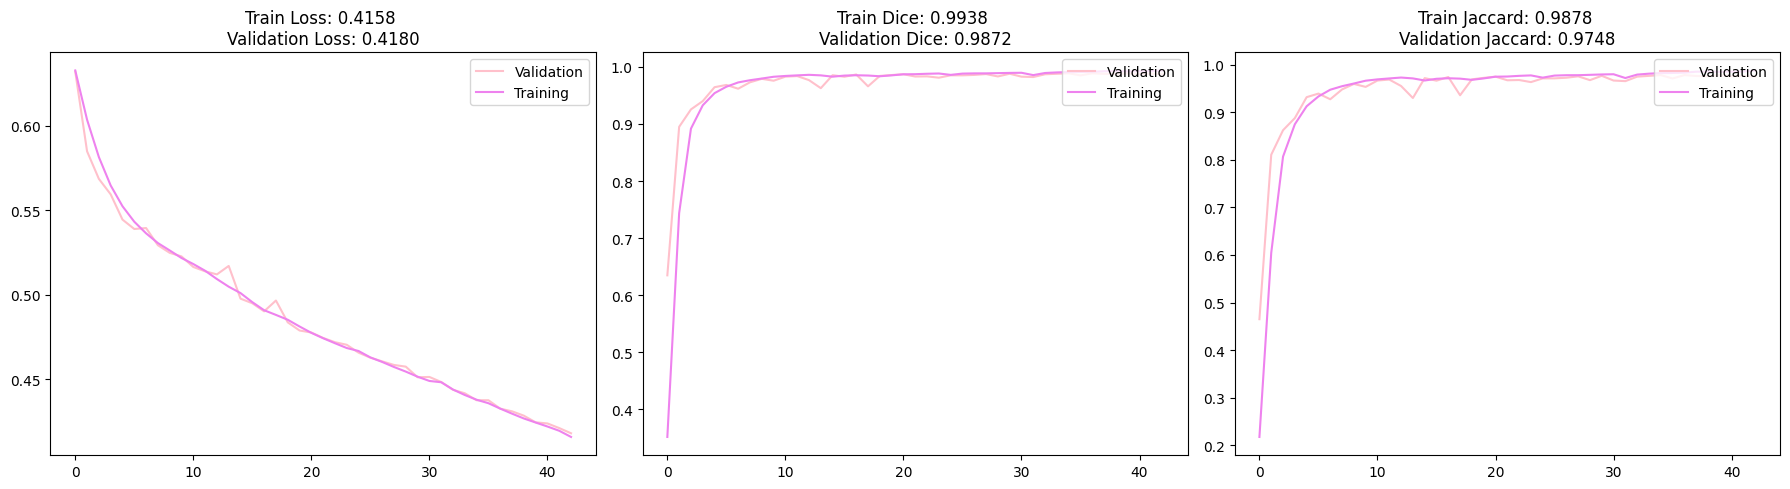

train epoch 44/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.4131 | Dice: 0.9936 | IoU: 0.9872


val epoch 44/70: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Loss: 0.4151 | Dice: 0.9886 | IoU: 0.9775


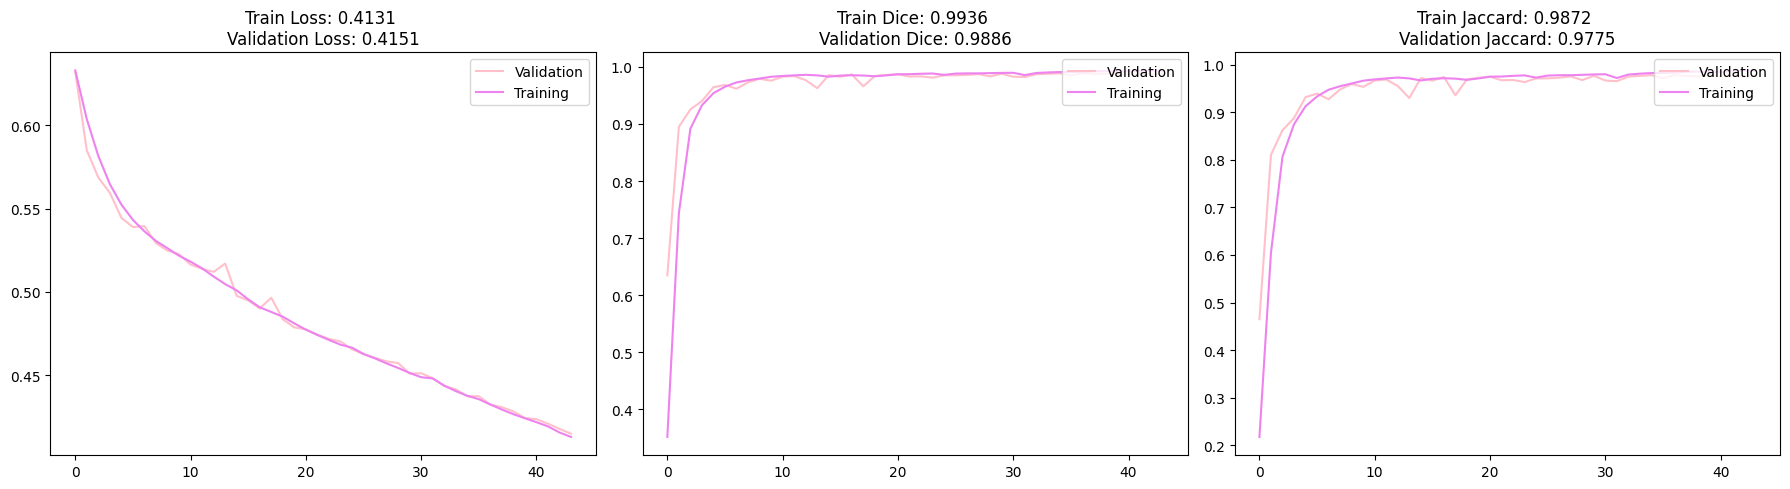

train epoch 45/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.4105 | Dice: 0.9937 | IoU: 0.9876


val epoch 45/70: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Loss: 0.4117 | Dice: 0.9882 | IoU: 0.9768


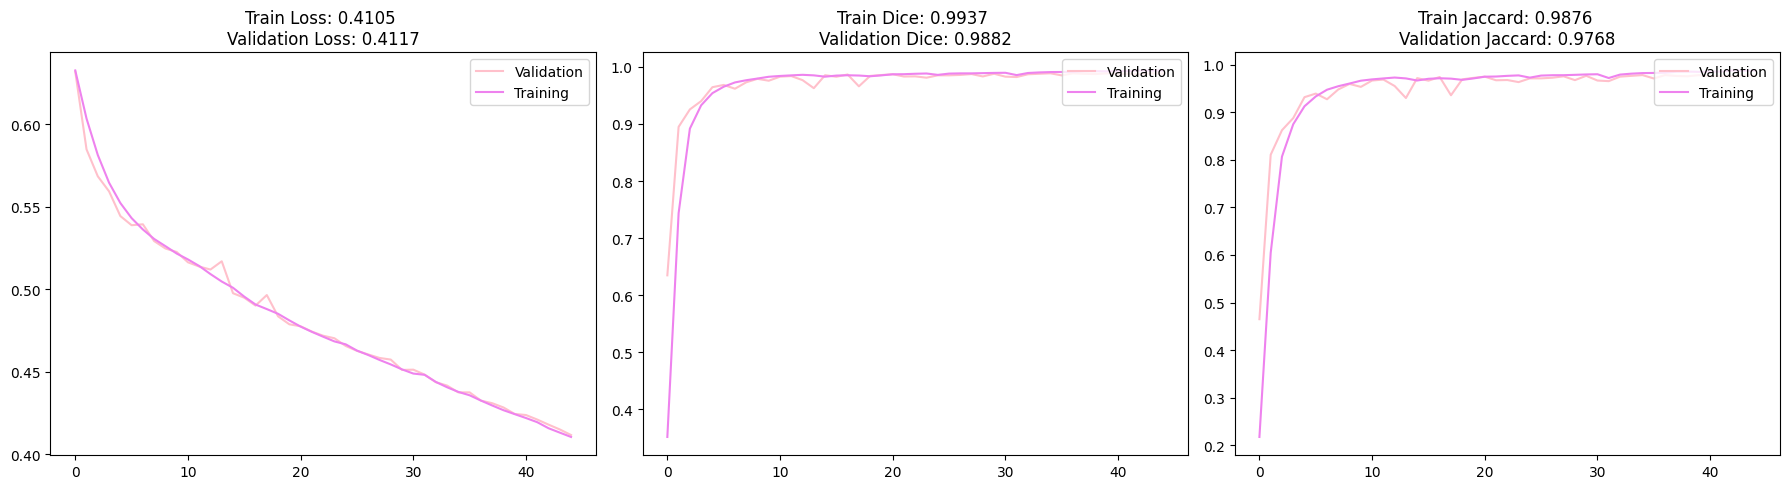

train epoch 46/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.4081 | Dice: 0.9934 | IoU: 0.9869


val epoch 46/70: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


Loss: 0.4098 | Dice: 0.9880 | IoU: 0.9764


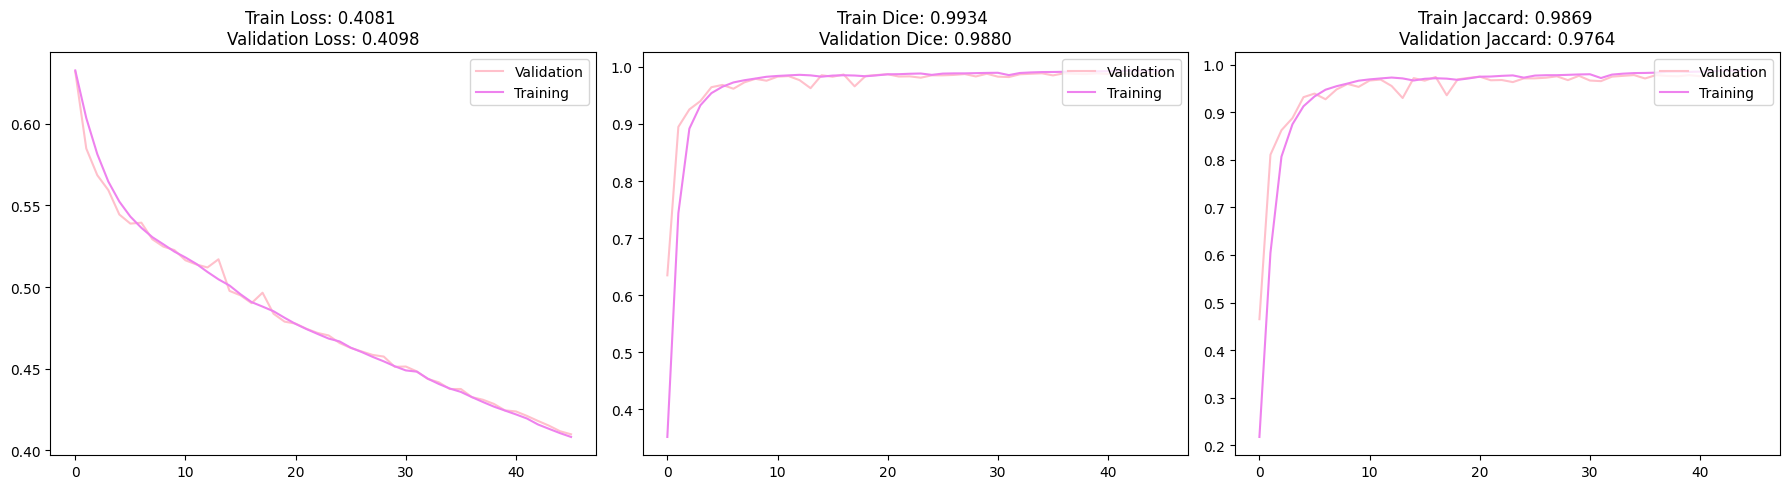

train epoch 47/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.4054 | Dice: 0.9932 | IoU: 0.9866


val epoch 47/70: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Loss: 0.4075 | Dice: 0.9876 | IoU: 0.9756


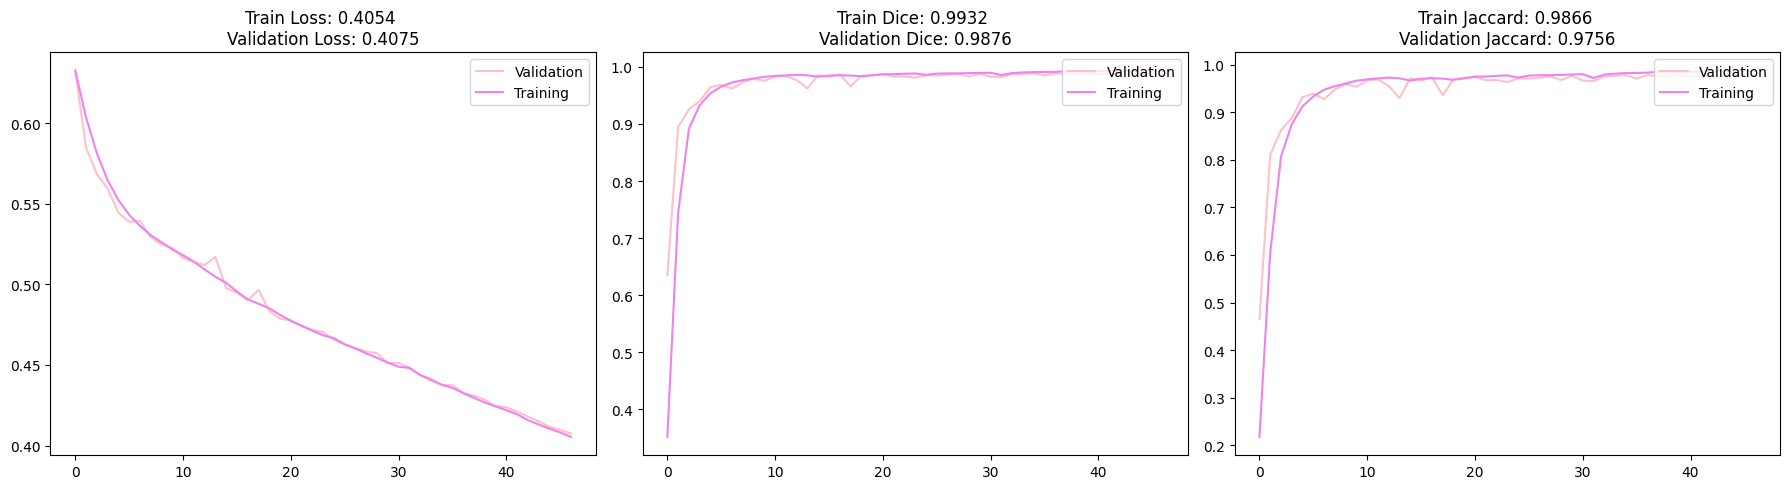

train epoch 48/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.4024 | Dice: 0.9937 | IoU: 0.9875


val epoch 48/70: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Loss: 0.4043 | Dice: 0.9874 | IoU: 0.9752


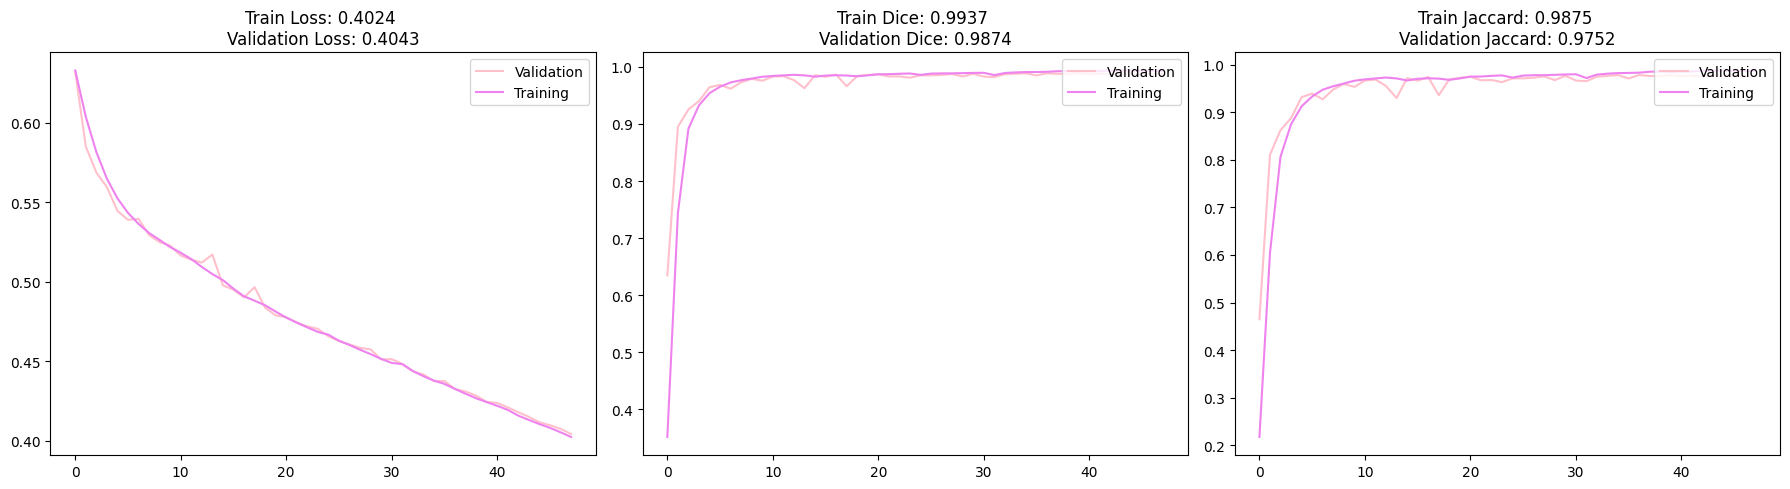

train epoch 49/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.3998 | Dice: 0.9936 | IoU: 0.9874


val epoch 49/70: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Loss: 0.4013 | Dice: 0.9885 | IoU: 0.9773


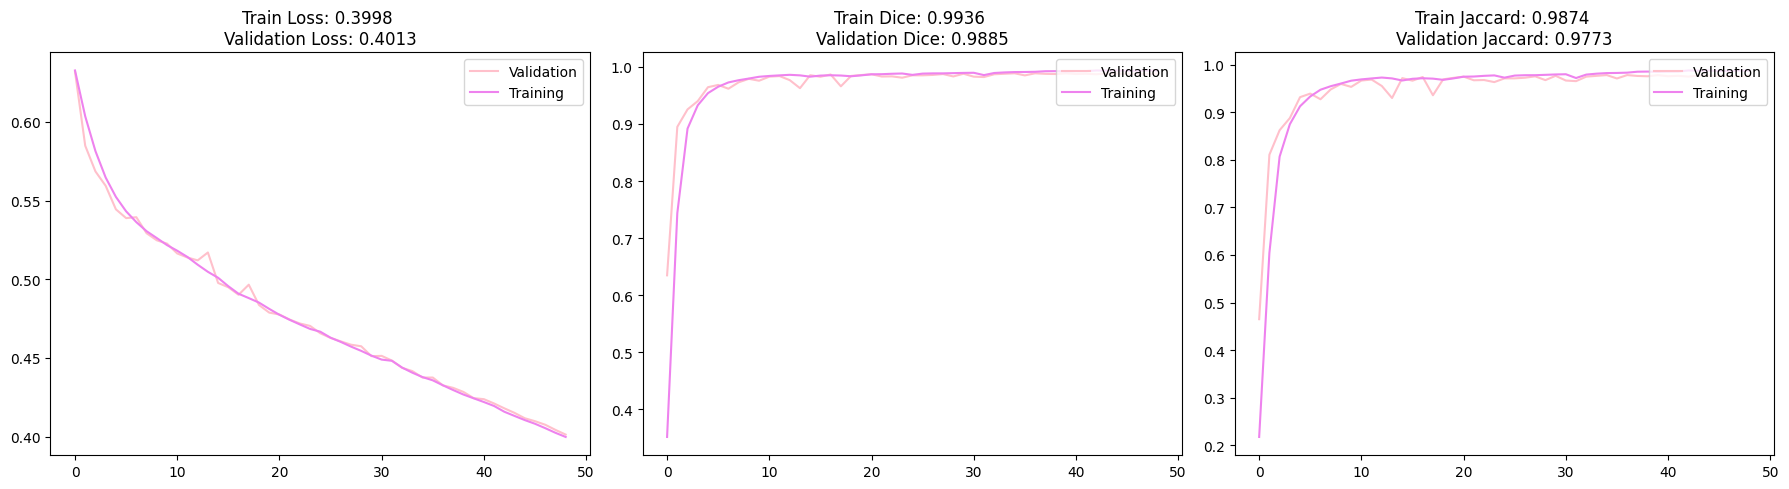

train epoch 50/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.3971 | Dice: 0.9942 | IoU: 0.9885


val epoch 50/70: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


Loss: 0.3992 | Dice: 0.9889 | IoU: 0.9782


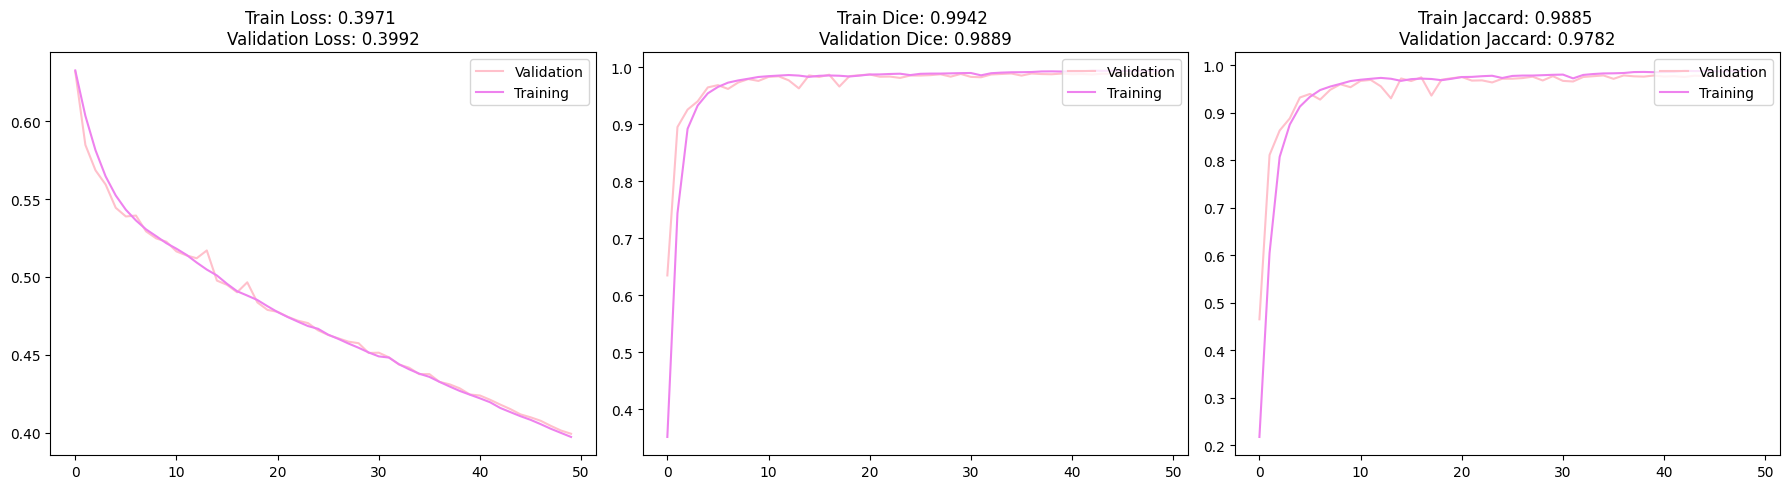

train epoch 51/70: 100%|██████████| 38/38 [00:32<00:00,  1.17it/s]


Loss: 0.3943 | Dice: 0.9942 | IoU: 0.9884


val epoch 51/70: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Loss: 0.3982 | Dice: 0.9871 | IoU: 0.9745


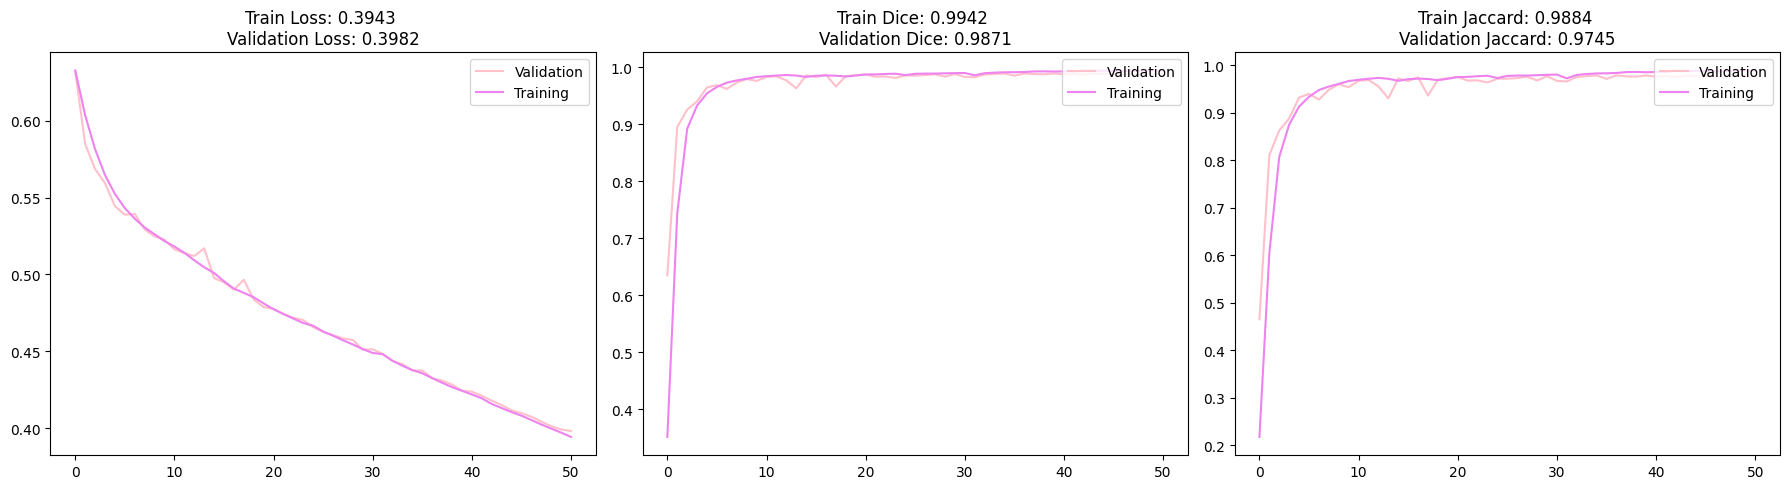

train epoch 52/70: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.3925 | Dice: 0.9934 | IoU: 0.9869


val epoch 52/70: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Loss: 0.3949 | Dice: 0.9883 | IoU: 0.9769


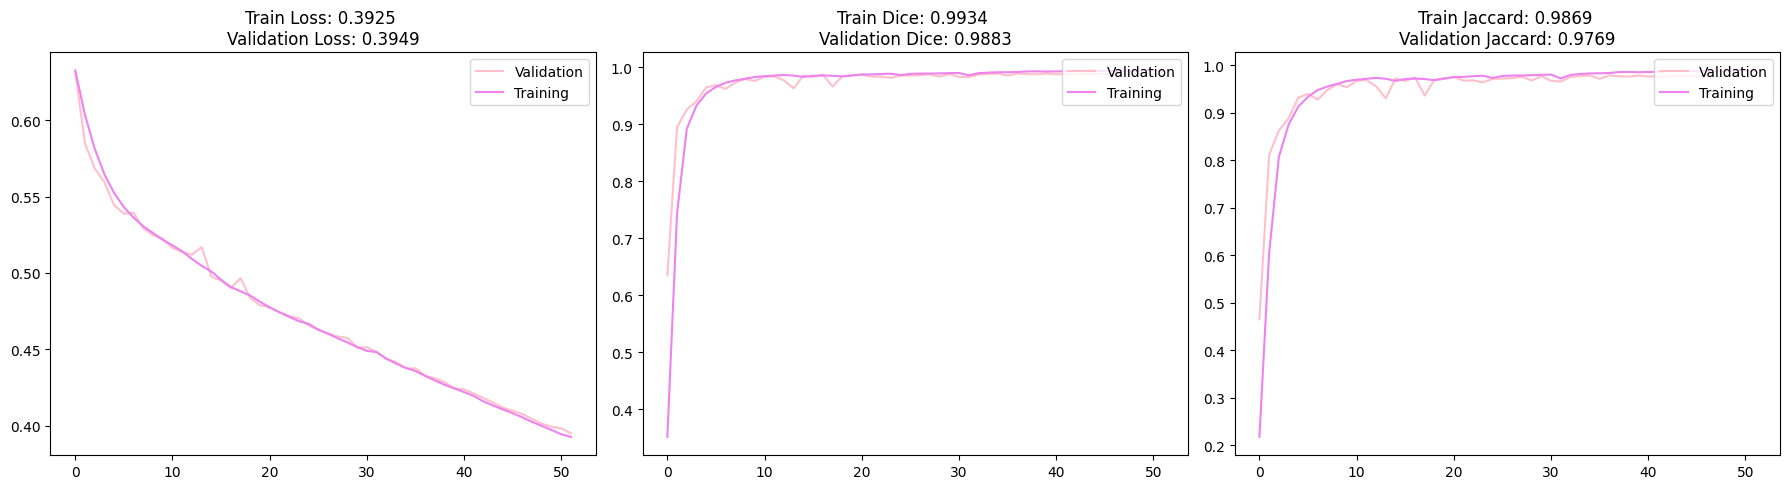

train epoch 53/70: 100%|██████████| 38/38 [00:31<00:00,  1.19it/s]


Loss: 0.3900 | Dice: 0.9931 | IoU: 0.9863


val epoch 53/70: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Loss: 0.3918 | Dice: 0.9884 | IoU: 0.9772


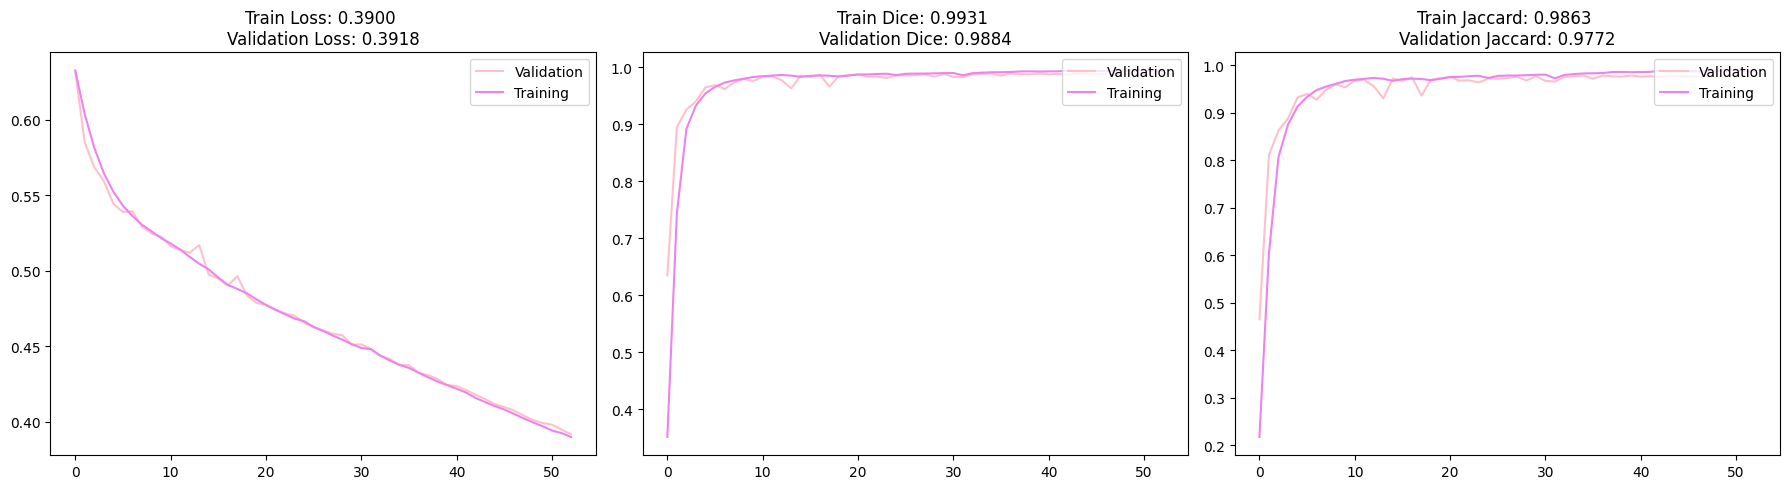

train epoch 54/70: 100%|██████████| 38/38 [00:31<00:00,  1.19it/s]


Loss: 0.3870 | Dice: 0.9941 | IoU: 0.9883


val epoch 54/70: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Loss: 0.3896 | Dice: 0.9884 | IoU: 0.9772


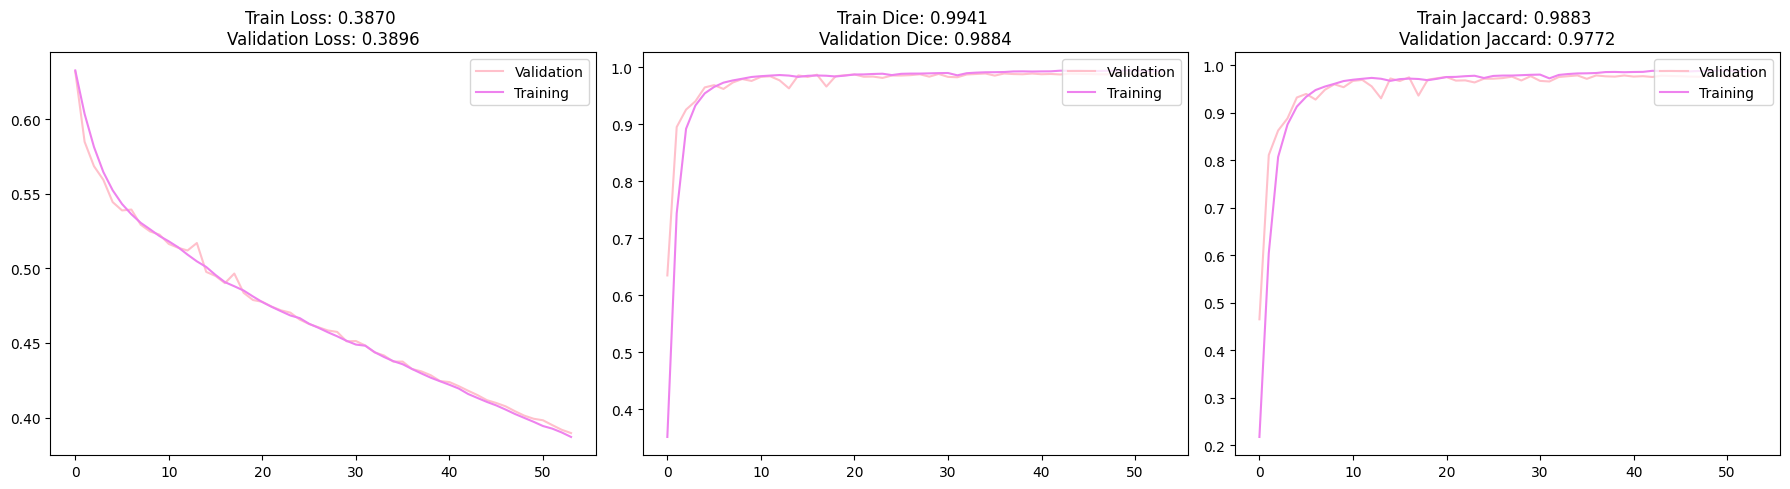

train epoch 55/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.3839 | Dice: 0.9945 | IoU: 0.9890


val epoch 55/70: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Loss: 0.3858 | Dice: 0.9891 | IoU: 0.9785


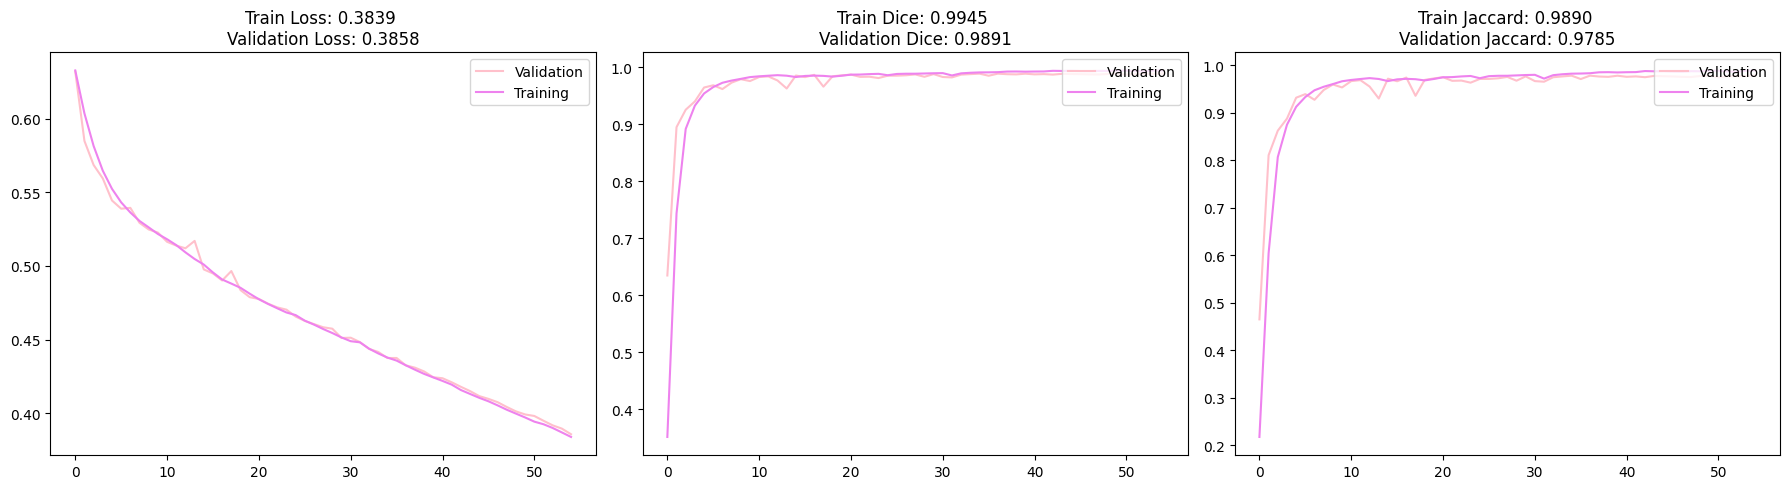

train epoch 56/70: 100%|██████████| 38/38 [00:31<00:00,  1.22it/s]


Loss: 0.3815 | Dice: 0.9945 | IoU: 0.9891


val epoch 56/70: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Loss: 0.3845 | Dice: 0.9885 | IoU: 0.9774


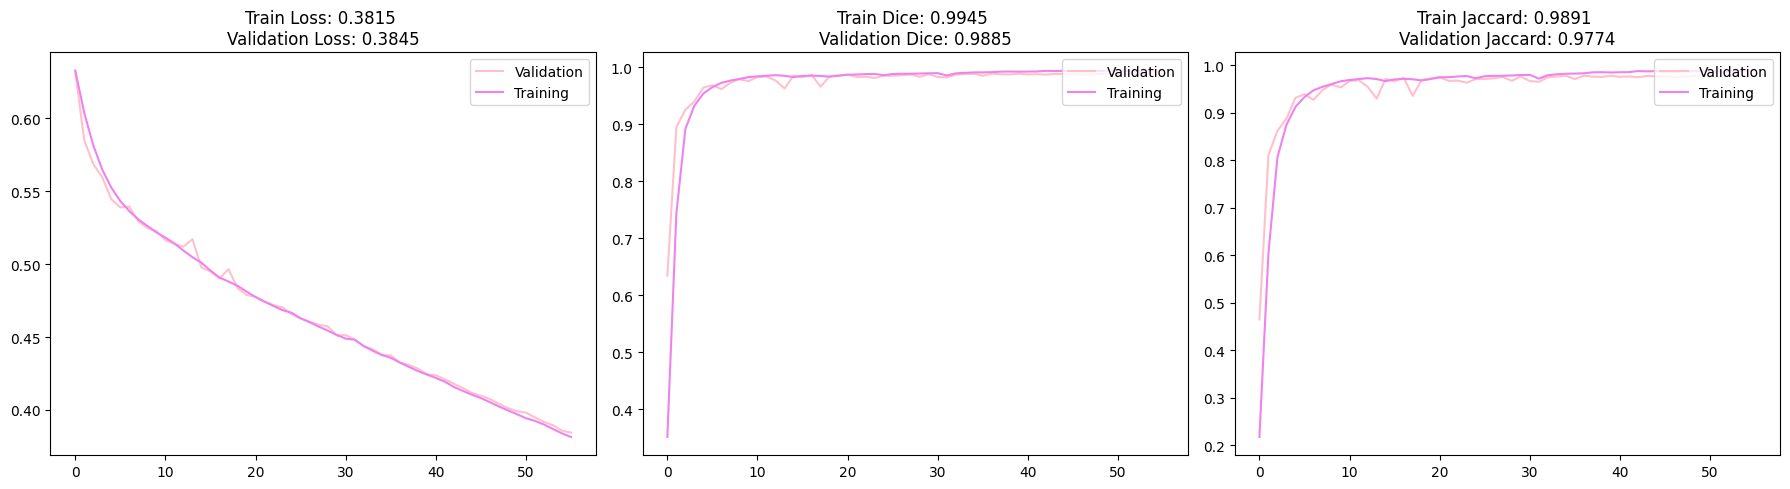

train epoch 57/70: 100%|██████████| 38/38 [00:31<00:00,  1.19it/s]


Loss: 0.3789 | Dice: 0.9947 | IoU: 0.9895


val epoch 57/70: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


Loss: 0.3831 | Dice: 0.9872 | IoU: 0.9748


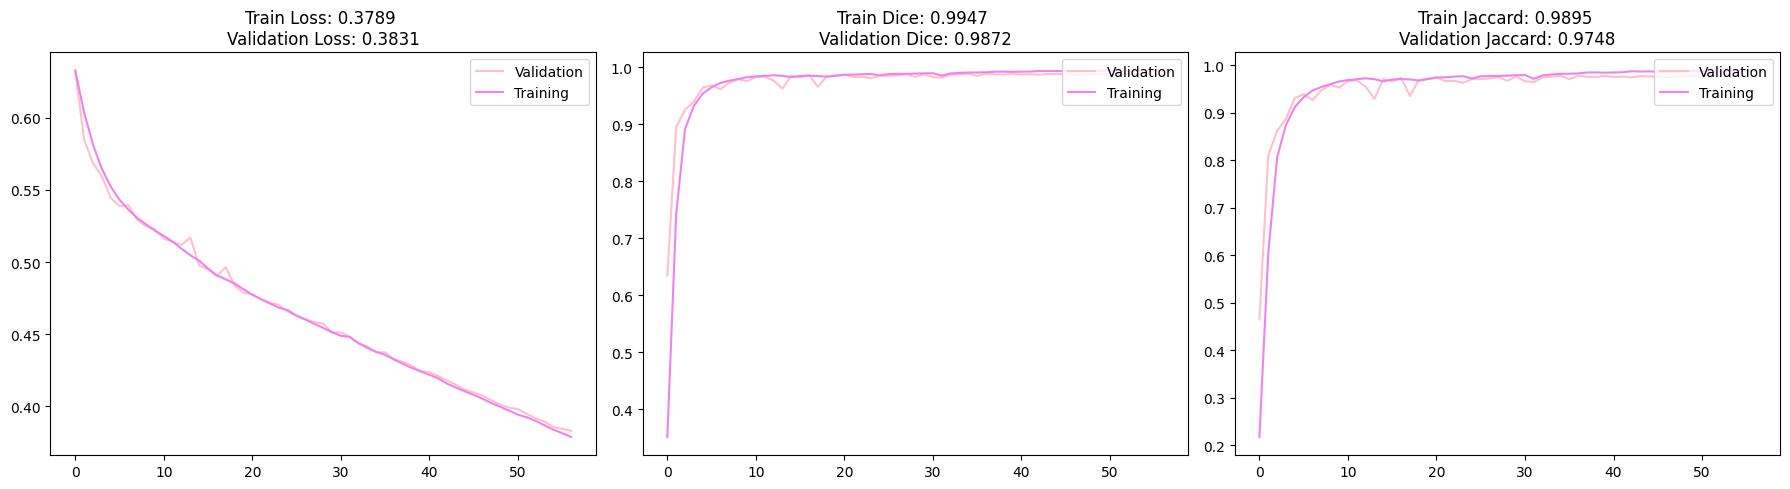

train epoch 58/70: 100%|██████████| 38/38 [00:32<00:00,  1.19it/s]


Loss: 0.3765 | Dice: 0.9945 | IoU: 0.9891


val epoch 58/70: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Loss: 0.3792 | Dice: 0.9875 | IoU: 0.9755


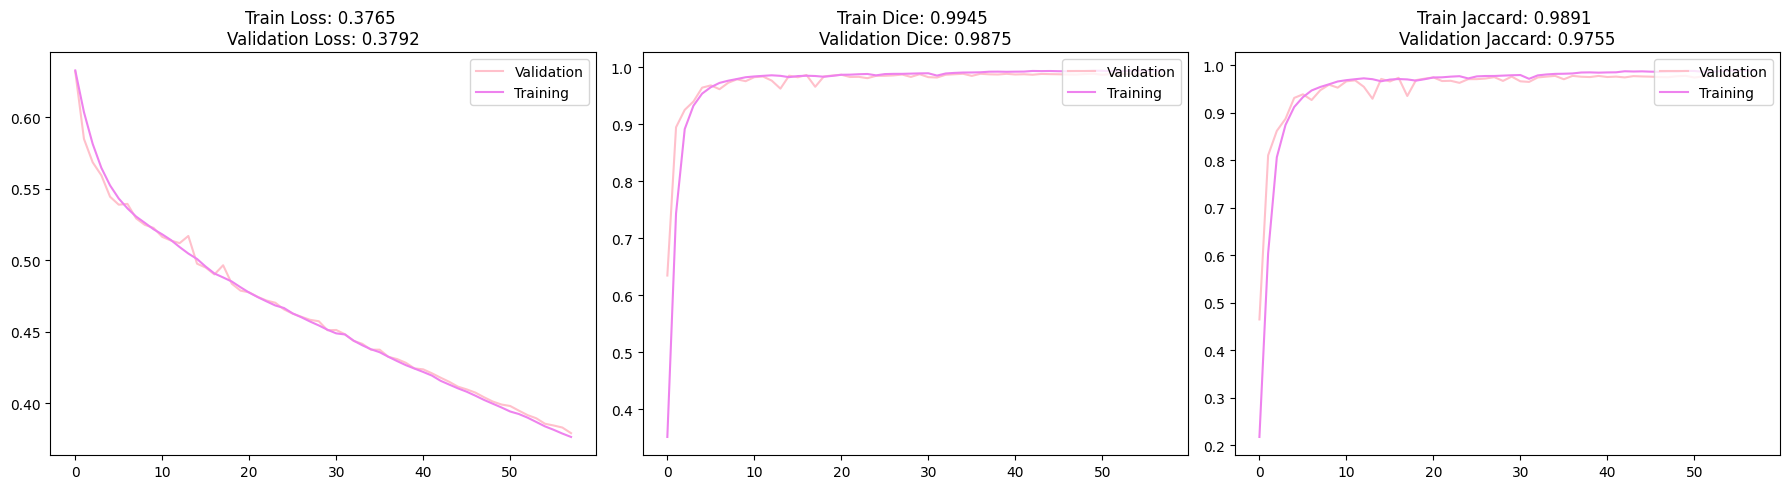

train epoch 59/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.3746 | Dice: 0.9939 | IoU: 0.9879


val epoch 59/70: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Loss: 0.3770 | Dice: 0.9887 | IoU: 0.9777


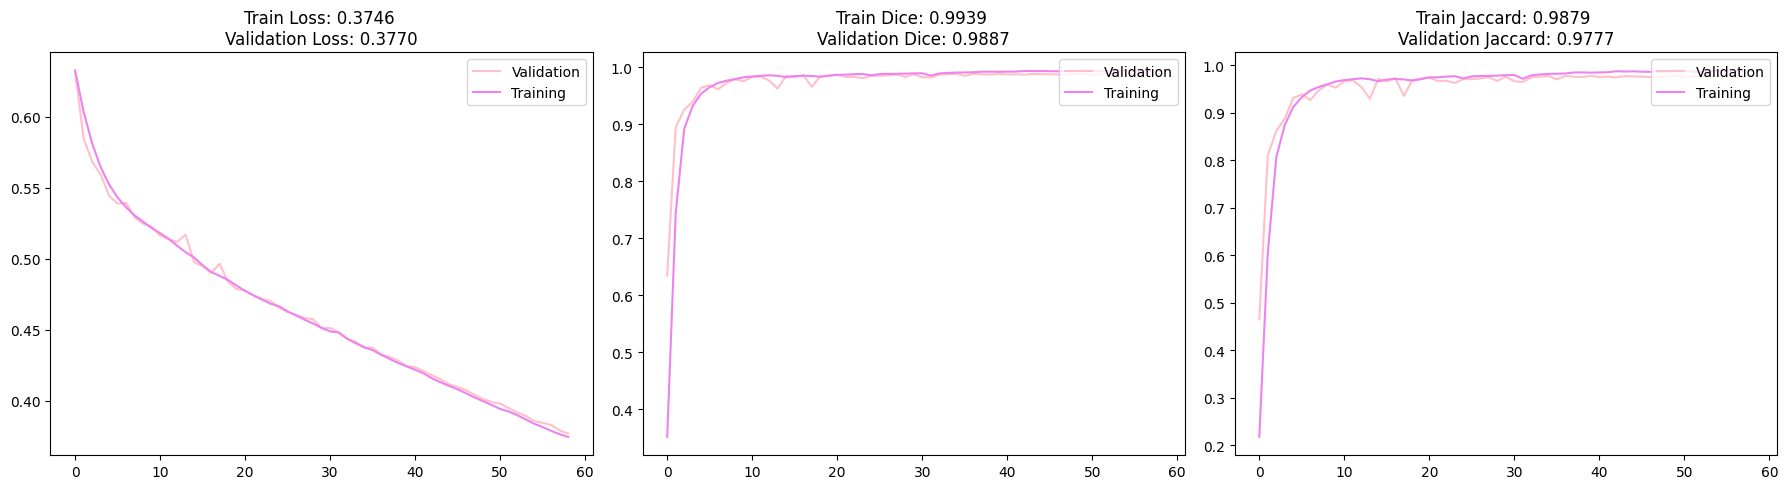

train epoch 60/70: 100%|██████████| 38/38 [00:32<00:00,  1.18it/s]


Loss: 0.3714 | Dice: 0.9945 | IoU: 0.9892


val epoch 60/70: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Loss: 0.3740 | Dice: 0.9873 | IoU: 0.9750


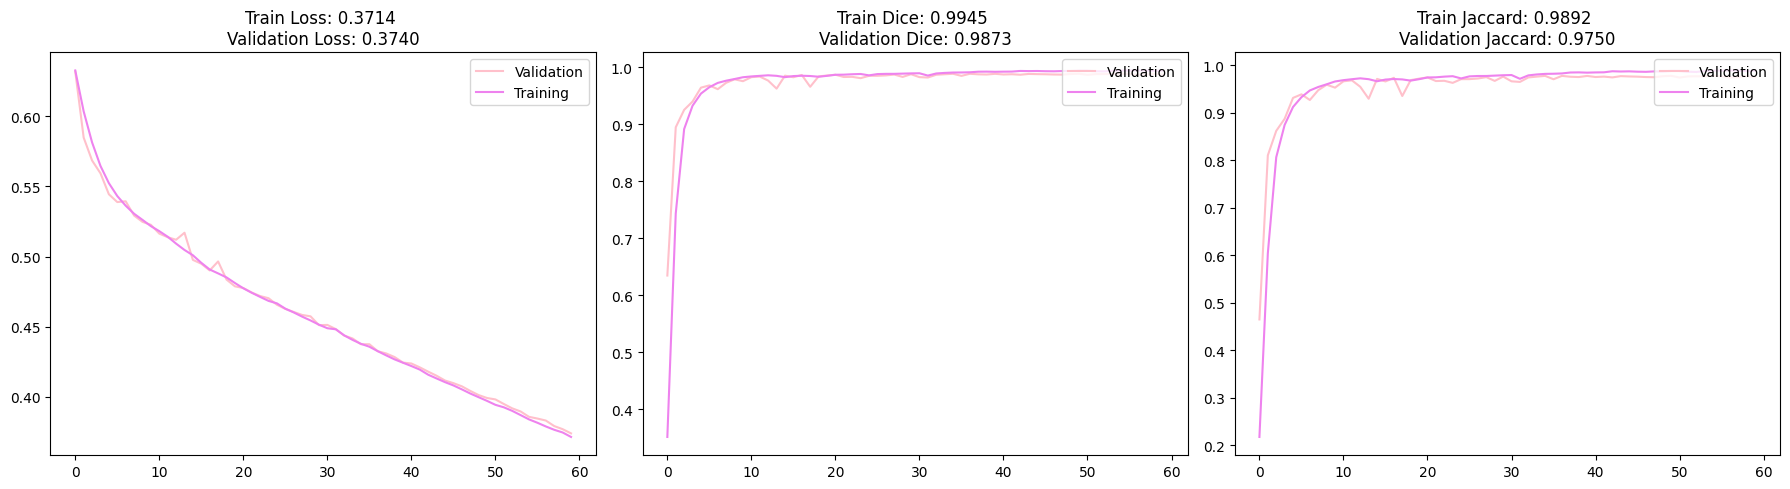

train epoch 61/70: 100%|██████████| 38/38 [00:32<00:00,  1.18it/s]


Loss: 0.3690 | Dice: 0.9946 | IoU: 0.9893


val epoch 61/70: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Loss: 0.3710 | Dice: 0.9883 | IoU: 0.9771


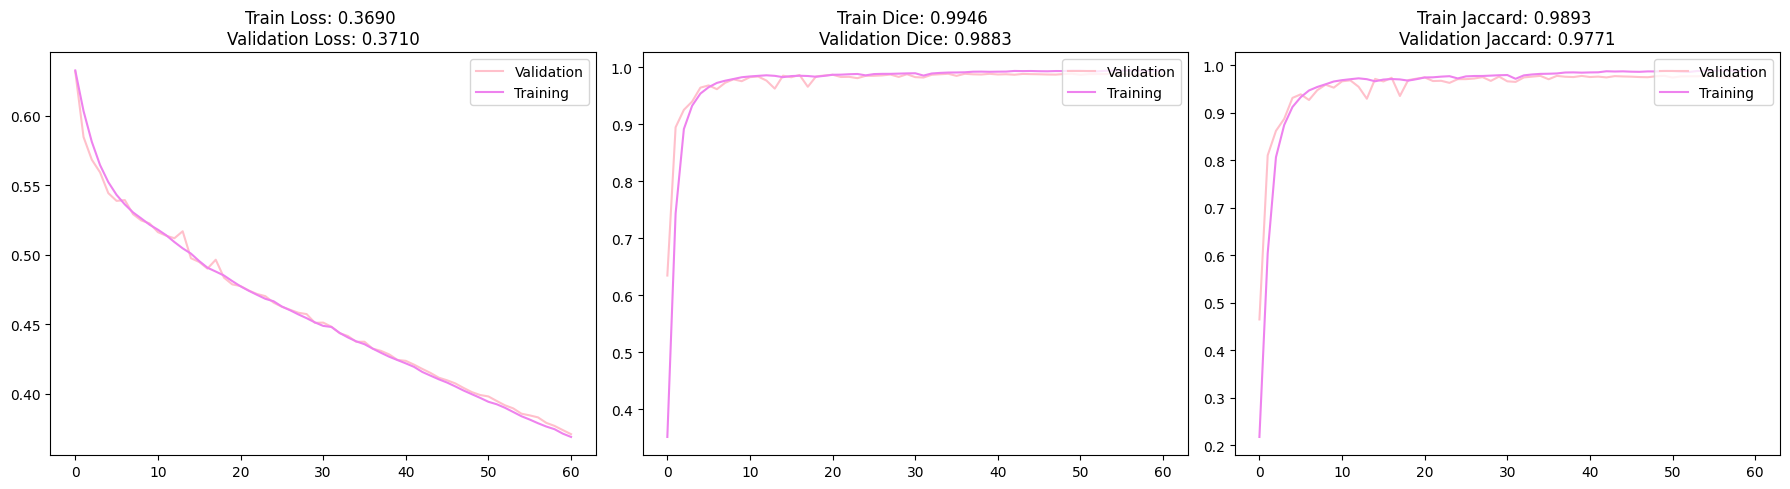

train epoch 62/70: 100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Loss: 0.3662 | Dice: 0.9951 | IoU: 0.9903


val epoch 62/70: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Loss: 0.3691 | Dice: 0.9886 | IoU: 0.9776


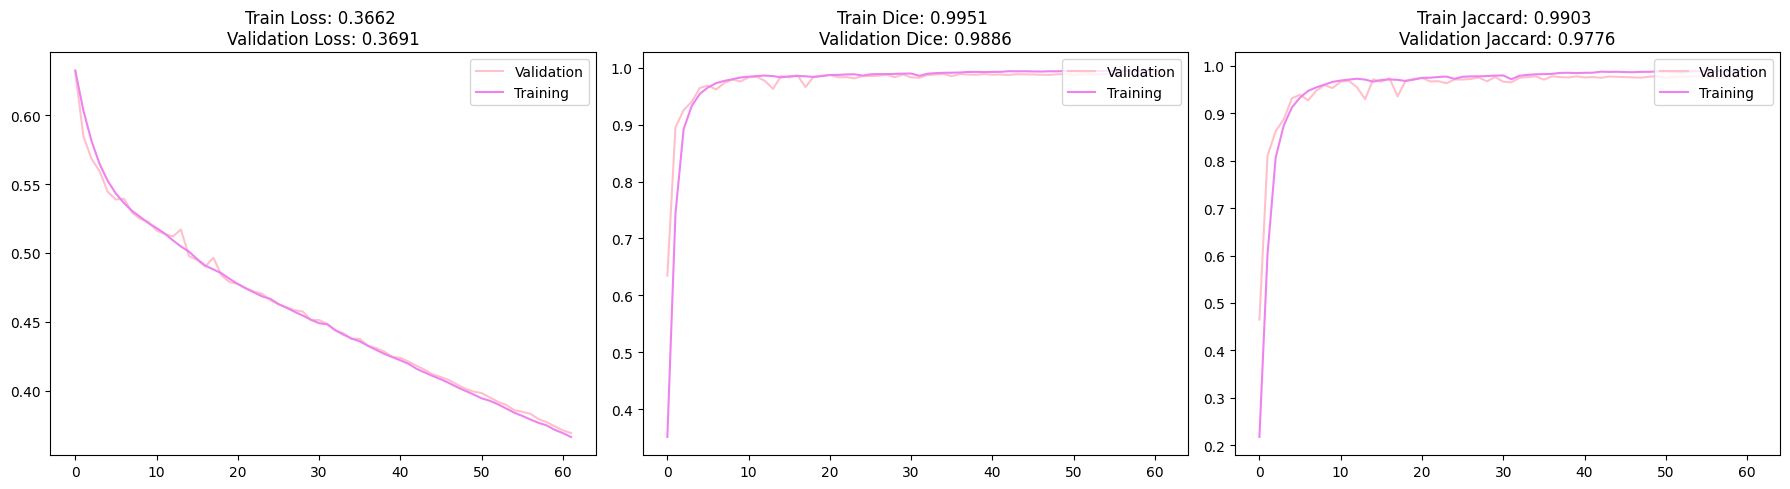

train epoch 63/70: 100%|██████████| 38/38 [00:32<00:00,  1.17it/s]


Loss: 0.3639 | Dice: 0.9953 | IoU: 0.9907


val epoch 63/70: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Loss: 0.3674 | Dice: 0.9884 | IoU: 0.9772


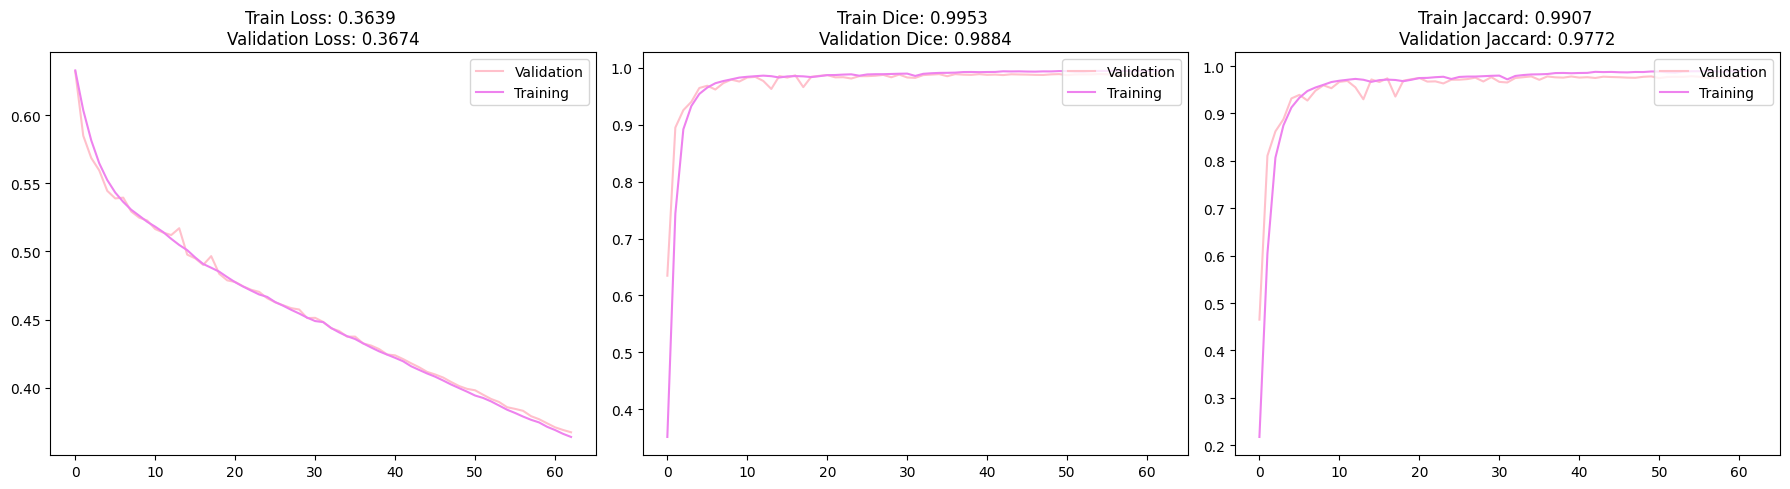

train epoch 64/70: 100%|██████████| 38/38 [00:32<00:00,  1.17it/s]


Loss: 0.3615 | Dice: 0.9946 | IoU: 0.9893


val epoch 64/70: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Loss: 0.3637 | Dice: 0.9887 | IoU: 0.9777


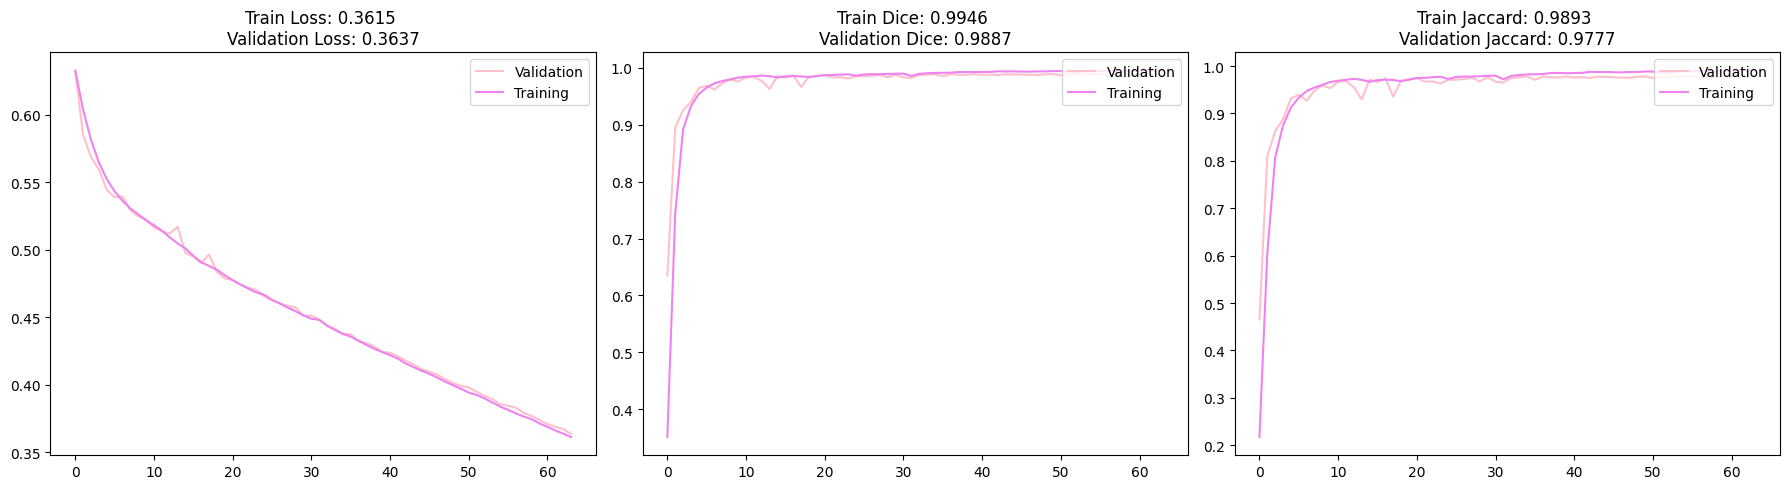

train epoch 65/70: 100%|██████████| 38/38 [00:32<00:00,  1.15it/s]


Loss: 0.3587 | Dice: 0.9950 | IoU: 0.9901


val epoch 65/70: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Loss: 0.3616 | Dice: 0.9885 | IoU: 0.9774


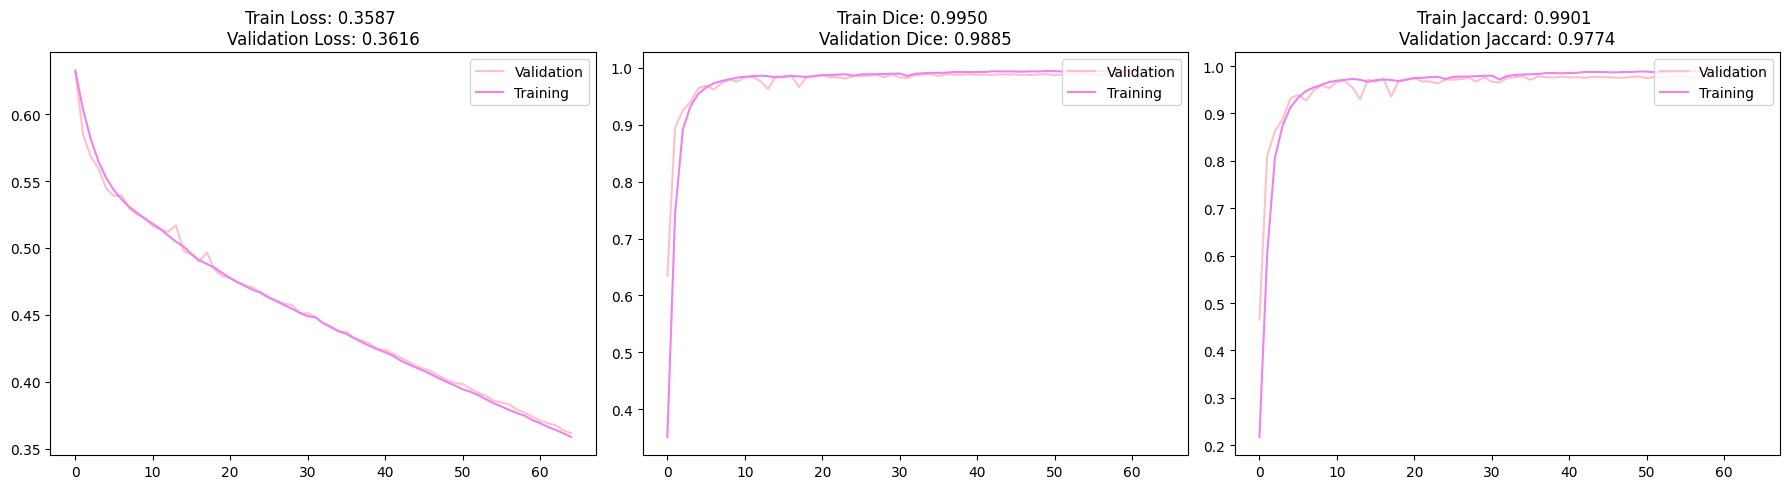

train epoch 66/70: 100%|██████████| 38/38 [00:32<00:00,  1.17it/s]


Loss: 0.3568 | Dice: 0.9947 | IoU: 0.9896


val epoch 66/70: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Loss: 0.3592 | Dice: 0.9882 | IoU: 0.9769


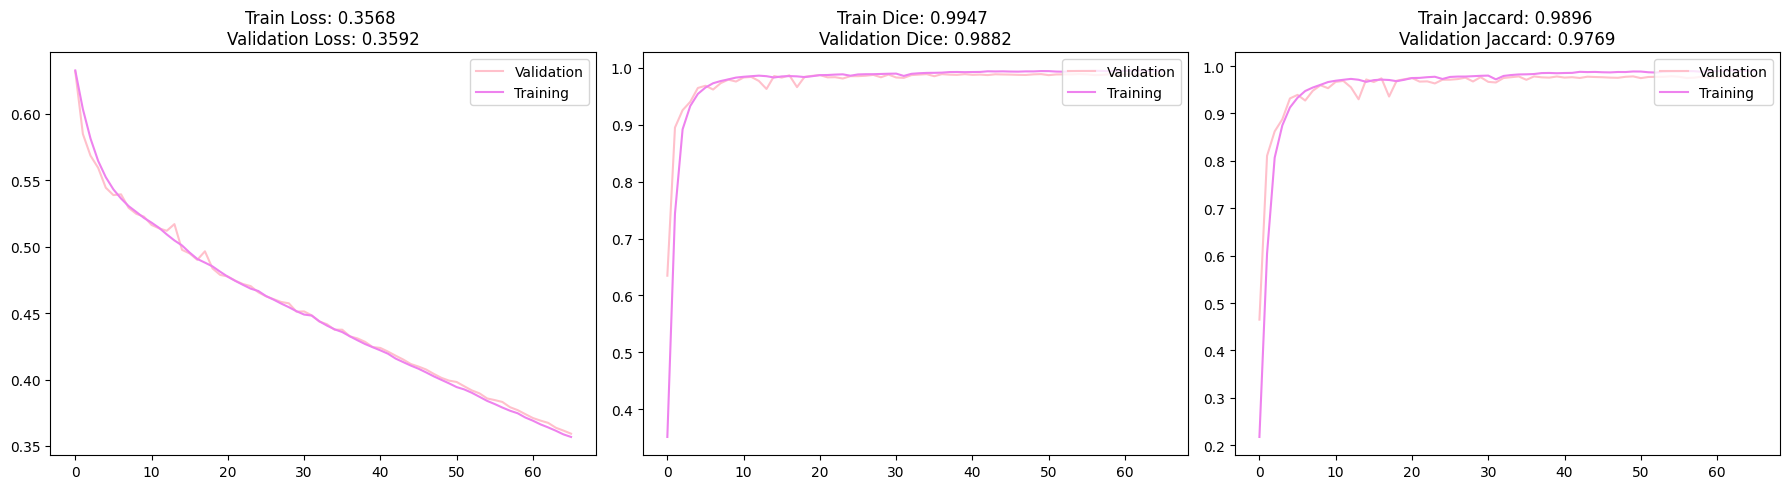

train epoch 67/70: 100%|██████████| 38/38 [00:32<00:00,  1.18it/s]


Loss: 0.3545 | Dice: 0.9937 | IoU: 0.9876


val epoch 67/70: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Loss: 0.3574 | Dice: 0.9876 | IoU: 0.9757


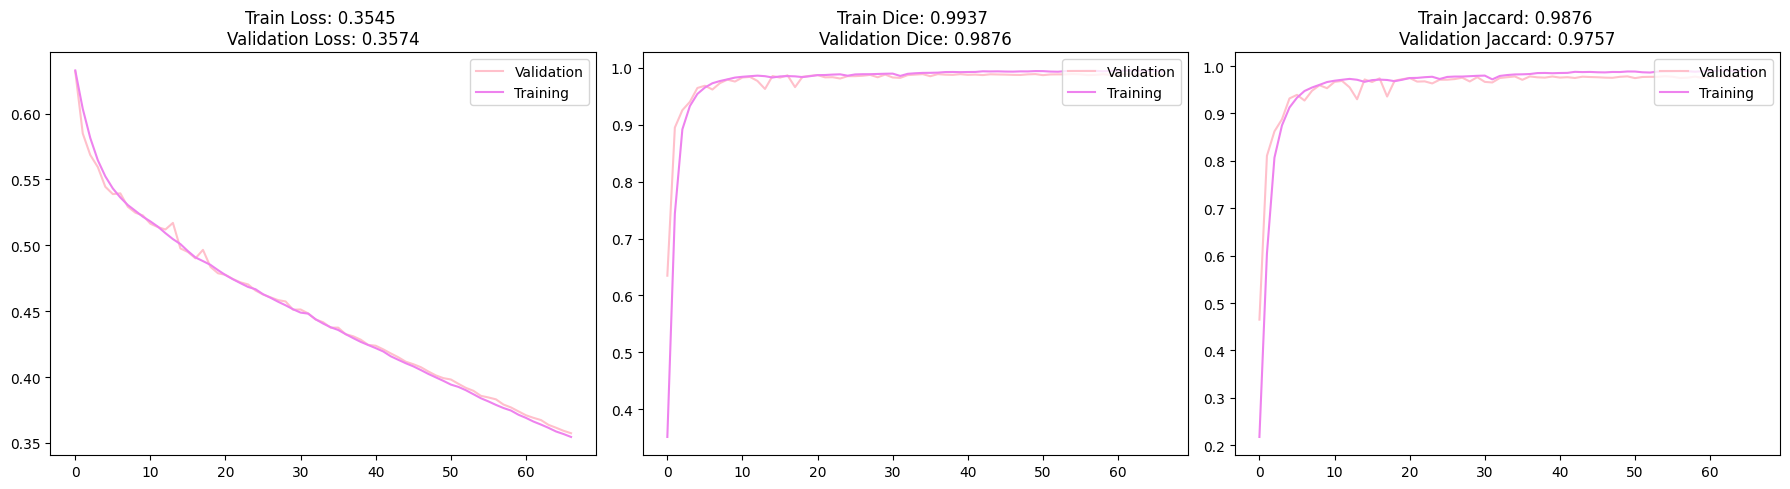

train epoch 68/70: 100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


Loss: 0.3514 | Dice: 0.9948 | IoU: 0.9896


val epoch 68/70: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Loss: 0.3553 | Dice: 0.9885 | IoU: 0.9775


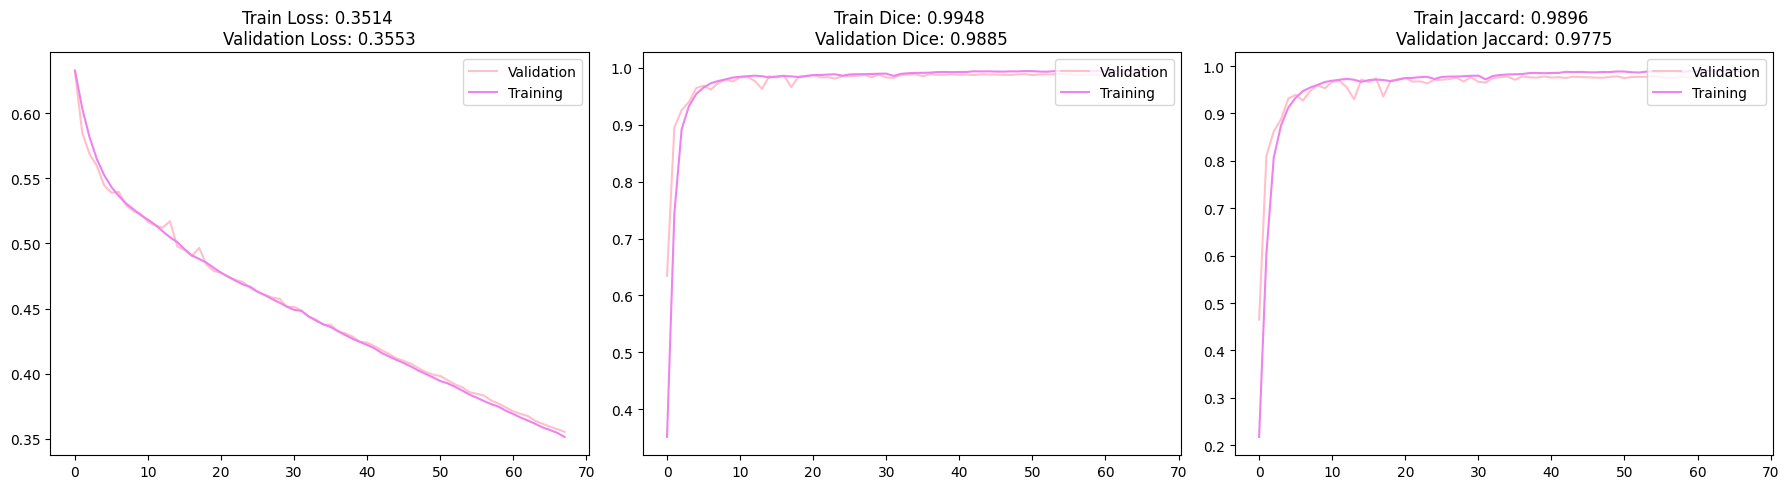

train epoch 69/70: 100%|██████████| 38/38 [00:32<00:00,  1.18it/s]


Loss: 0.3486 | Dice: 0.9953 | IoU: 0.9907


val epoch 69/70: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Loss: 0.3518 | Dice: 0.9883 | IoU: 0.9769


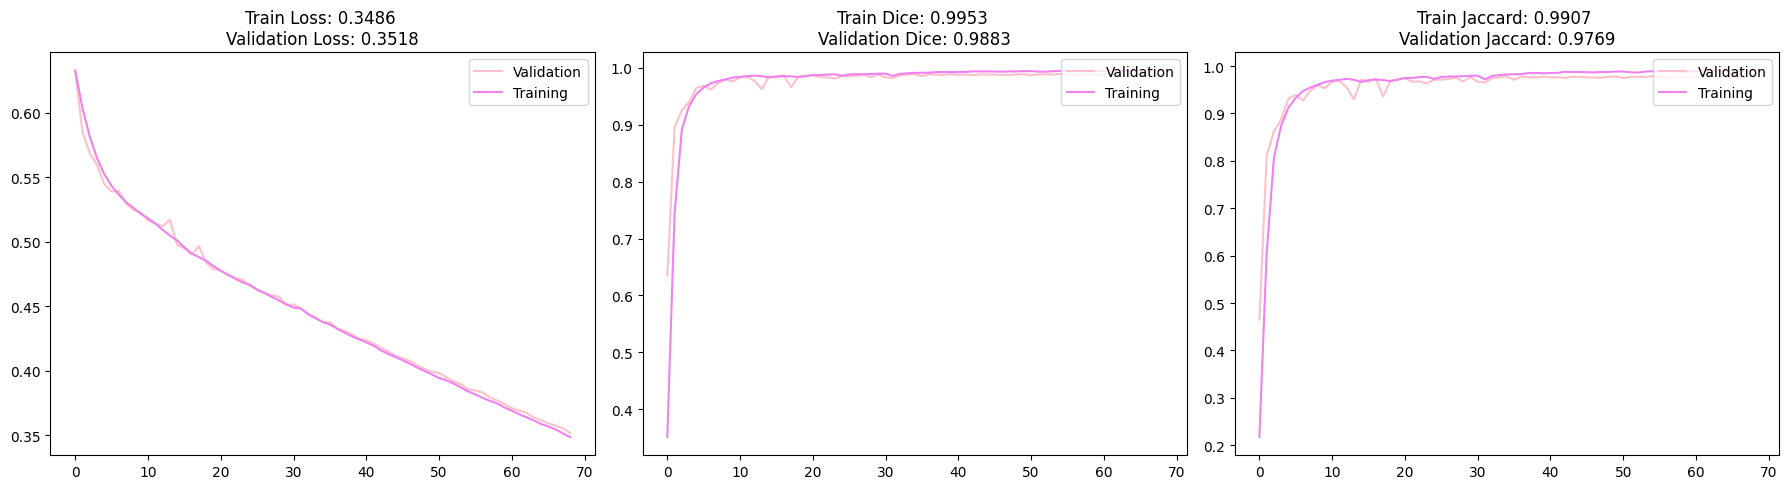

train epoch 70/70: 100%|██████████| 38/38 [00:32<00:00,  1.15it/s]


Loss: 0.3458 | Dice: 0.9956 | IoU: 0.9912


val epoch 70/70: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Loss: 0.3488 | Dice: 0.9891 | IoU: 0.9785


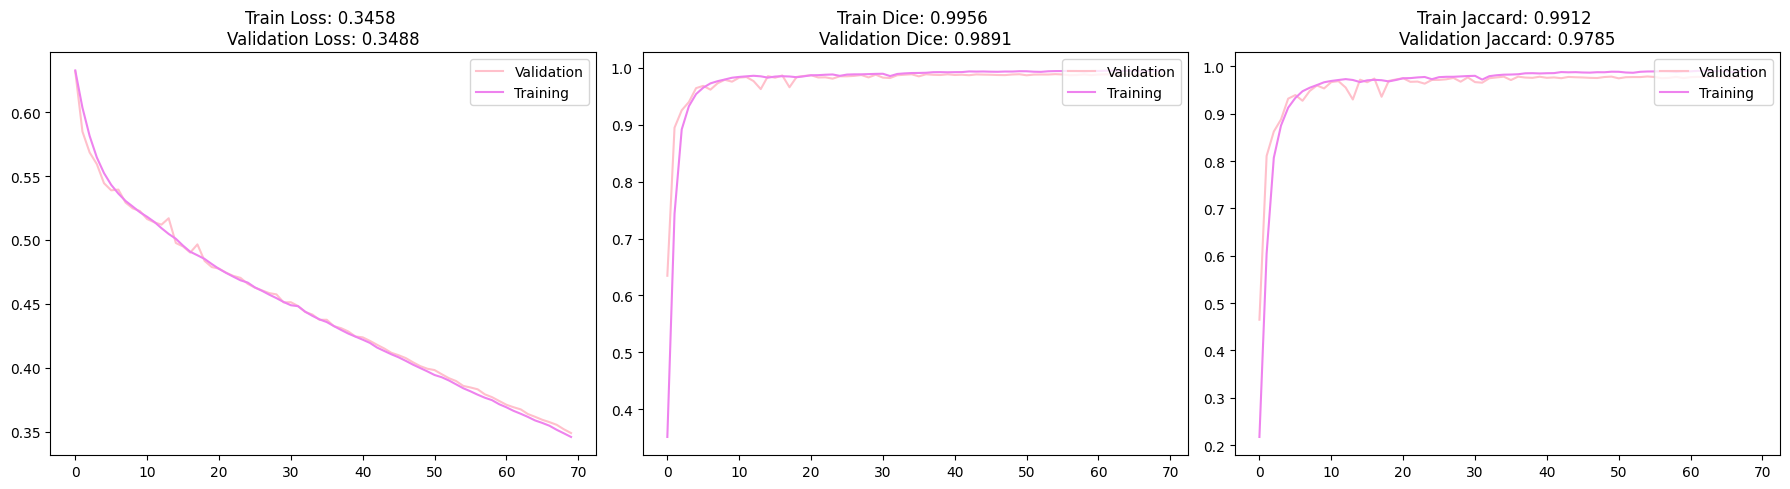


CPU times: user 33min 50s, sys: 1min 48s, total: 35min 38s
Wall time: 42min 54s


In [78]:
%%time
trainer.run()

In [114]:
def coef_metric_per_classes(probabilities, truth, threshold=0.5, eps=1e-9, classes=['WT', 'TC', 'ET', 'BG'], metric='dice'):
    scores = {key: [] for key in classes}
    predictions = (probabilities >= threshold).astype(np.float32)

    for i in range(probabilities.shape[0]):
        for class_, class_name in enumerate(classes):
            prediction = predictions[i, class_]
            truth_ = truth[i, class_]

            if metric == 'dice':
                intersection = 2.0 * np.sum(truth_ * prediction)
                union = np.sum(truth_) + np.sum(prediction)
            elif metric == 'jaccard':
                intersection = np.sum(prediction * truth_)
                union = np.sum(prediction) + np.sum(truth_) - intersection + eps
            else:
                raise ValueError("Unsupported metric. Use 'dice' or 'jaccard'.")

            if np.sum(truth_) == 0 and np.sum(prediction) == 0:
                scores[class_name].append(1.0)
            else:
                scores[class_name].append((intersection + eps) / (union + eps))

    return scores

def compute_scores_per_classes(model, dataloader, classes):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}
    loss_per_batch = []

    criterion = bce_dice_loss  # Use the appropriate loss function

    with torch.no_grad():
        for i, (imgs, targets) in enumerate(dataloader):
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs.float())

            # Compute loss
            loss = criterion(logits, targets, alpha=0.5, beta=0.5)
            loss_per_batch.append(loss.item())

            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()

            dice_scores = coef_metric_per_classes(logits, targets, metric='dice')
            iou_scores = coef_metric_per_classes(logits, targets, metric='jaccard')

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    average_loss = sum(loss_per_batch) / len(loss_per_batch)

    return average_loss, dice_scores_per_classes, iou_scores_per_classes

In [115]:
model.eval();

In [116]:
average_test_loss, dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(model, test_dl, ['WT', 'TC', 'ET', 'BG'])

print(f"Average Test Loss: {average_test_loss:.4f}\n")

for key in dice_scores_per_classes.keys():
    print(f"Average Test Dice ({key}): {np.mean(dice_scores_per_classes[key]):.4f}")
print("\t")
for key in iou_scores_per_classes.keys():
    print(f"Average Test Jaccard ({key}): {np.mean(iou_scores_per_classes[key]):.4f}")

Average Test Loss: 0.3491

Average Test Dice (WT): 0.9167
Average Test Dice (TC): 0.7429
Average Test Dice (ET): 1.0000
Average Test Dice (BG): 0.9930
	
Average Test Jaccard (WT): 0.9167
Average Test Jaccard (TC): 0.6240
Average Test Jaccard (ET): 1.0000
Average Test Jaccard (BG): 0.9862


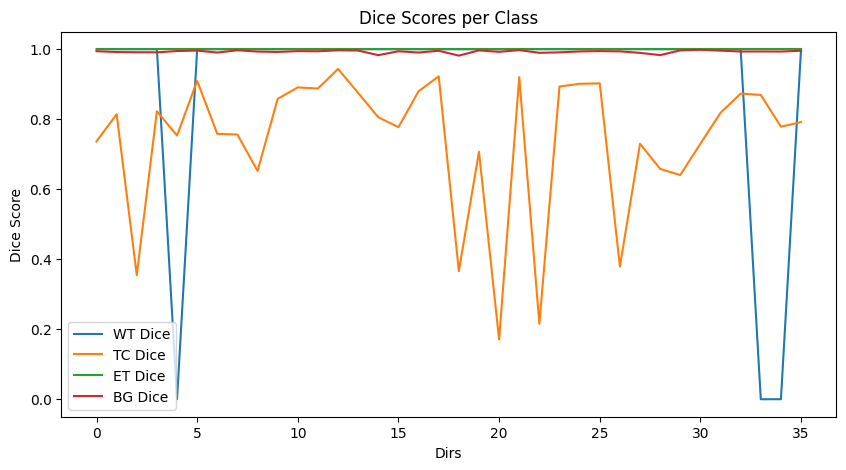

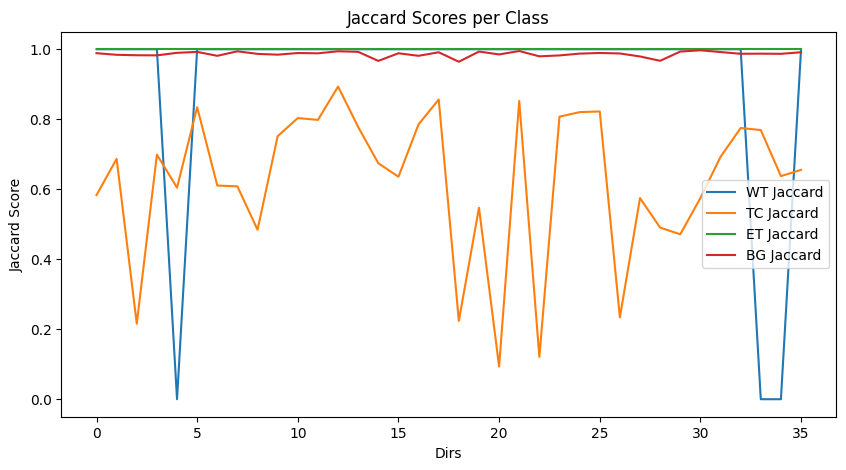

In [117]:
# Plot the Dice scores
plt.figure(figsize=(10, 5))
for key in dice_scores_per_classes.keys():
    plt.plot(dice_scores_per_classes[key], label=f'{key} Dice')
plt.title('Dice Scores per Class')
plt.xlabel('Dirs')
plt.ylabel('Dice Score')
plt.legend()
plt.show()

# Plot the Jaccard scores
plt.figure(figsize=(10, 5))
for key in iou_scores_per_classes.keys():
    plt.plot(iou_scores_per_classes[key], label=f'{key} Jaccard')
plt.title('Jaccard Scores per Class')
plt.xlabel('Dirs')
plt.ylabel('Jaccard Score')
plt.legend()
plt.show()


In [118]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice', 'BG dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard', 'BG jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard',
                                      'TC dice', 'TC jaccard',
                                      'ET dice', 'ET jaccard',
                                      'BG dice', 'BG jaccard']]
val_metics_df.sample(5)

WT dice  WT jaccard   TC dice  TC jaccard  ET dice  ET jaccard   BG dice  \
9       1.0         1.0  0.858151    0.751545      1.0         1.0  0.992154   
30      1.0         1.0  0.730022    0.574830      1.0         1.0  0.998448   
3       1.0         1.0  0.822718    0.698828      1.0         1.0  0.991151   
2       1.0         1.0  0.354776    0.215640      1.0         1.0  0.991327   
17      1.0         1.0  0.922626    0.856366      1.0         1.0  0.995608   

    BG jaccard  
9     0.984430  
30    0.996901  
3     0.982457  
2     0.982804  
17    0.991254

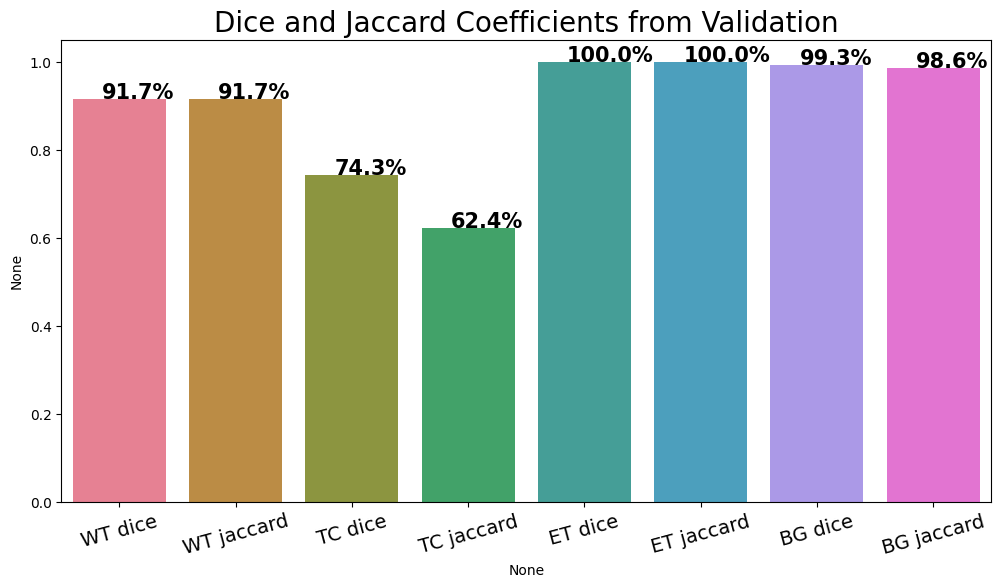

In [119]:
## Prosječne vrijednosti Dice i Jaccard koeficijenata za svaku od klasa na validacijskom skupu

unique_categories = val_metics_df.mean().index
palette = sns.color_palette("husl", len(unique_categories))

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), hue=val_metics_df.mean().index, palette=palette, ax=ax, legend=False)

ax.set_xticks(range(len(val_metics_df.mean().index)))
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15)

ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
    percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
    x = p.get_x() + p.get_width() / 2 - 0.15
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png", pad_inches=0.2, transparent=False, bbox_inches='tight')

plt.show()

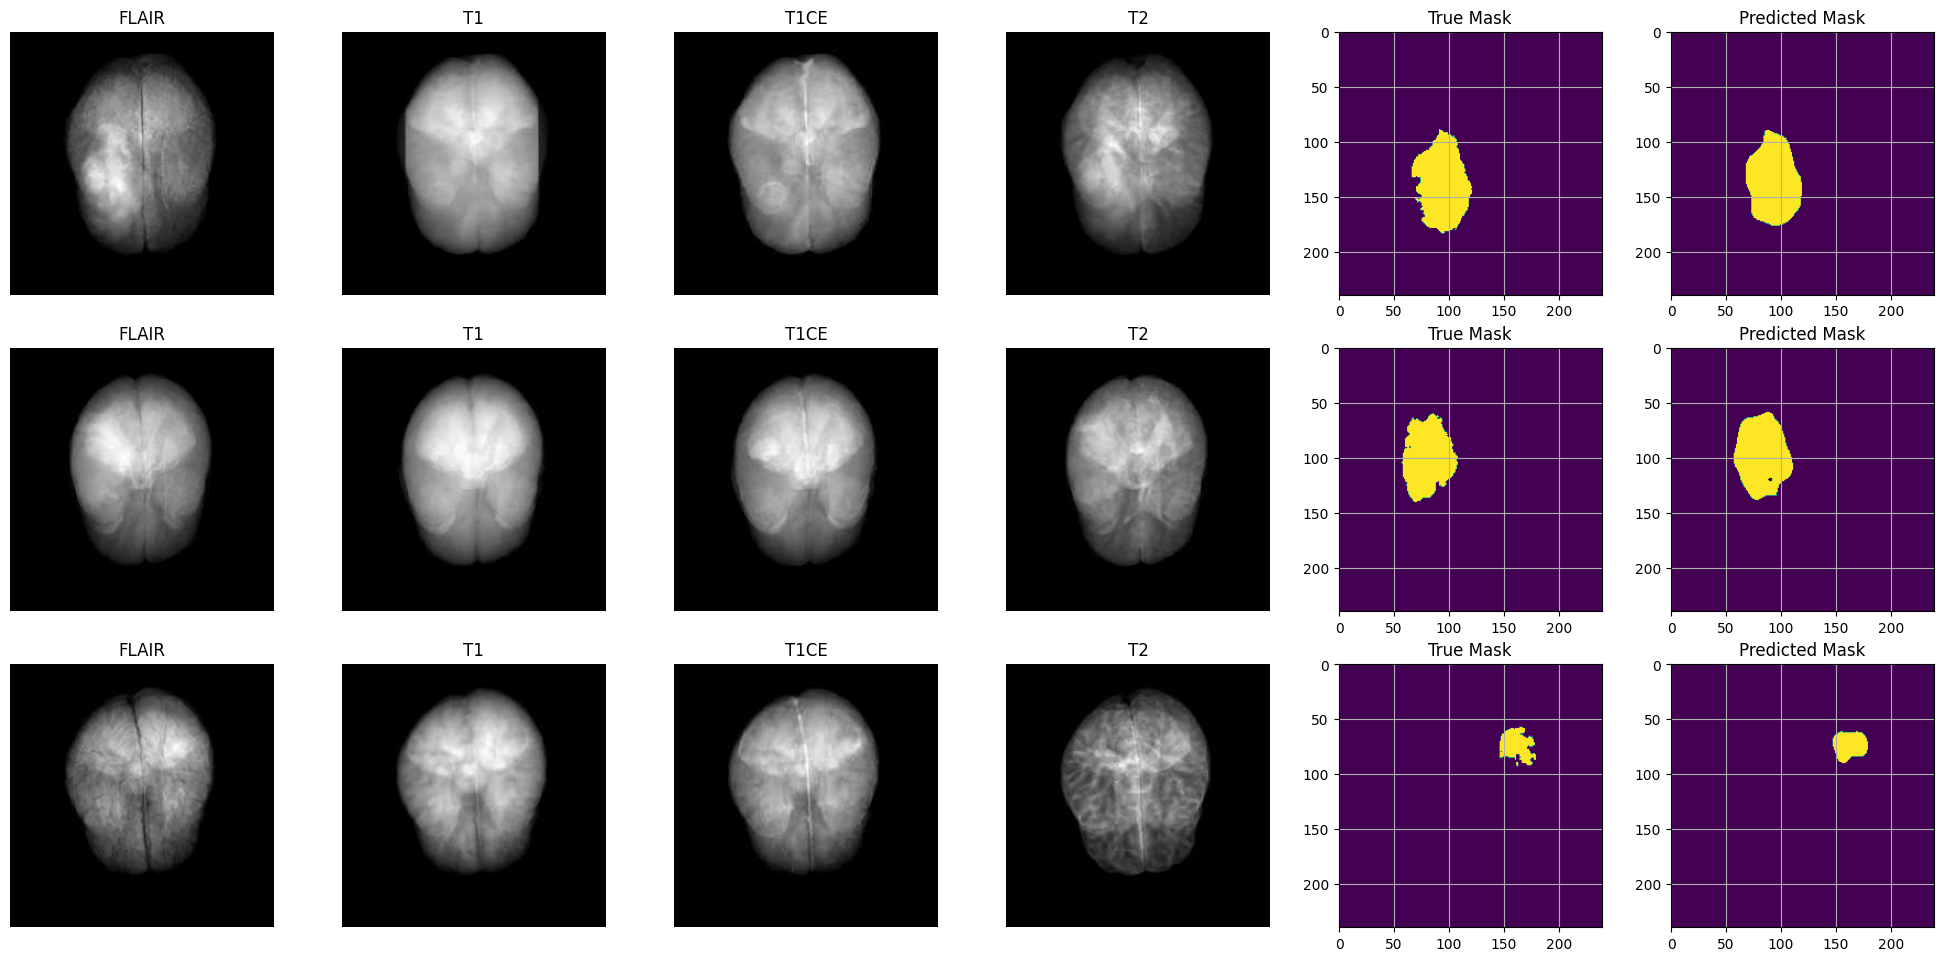

In [126]:
def show_results(model, test_dl):
    dl_iter = iter(test_dl)
    images, masks = next(dl_iter)

    images = images.to(device)
    masks = masks.to(device)
    outputs = model(images.float())

    preds = torch.argmax(outputs, dim=1)
    masks = torch.argmax(masks, dim=1)

    plt.figure(figsize=(25, 65))

    for i in range(3):
        for j in range(len(modality_types)):
            plt.subplot(16, 6, 6 * i + j + 1)
            plt.axis('off')
            plt.title(modality_types[j])
            plt.imshow(images[i][j].cpu(), cmap='gray')

        # show True Mask
        plt.subplot(16, 6, 6 * i + 5)
        plt.title('True Mask')
        plt.grid()
        plt.imshow(255 - masks[i].cpu(), cmap='viridis')

        # show Predicted Mask
        plt.subplot(16, 6, 6 * i + 6)
        plt.title('Predicted Mask')
        plt.grid()
        plt.imshow(255 - preds[i].cpu(), cmap='viridis')

    plt.show()

show_results(model, test_dl)